<h1>Vapor pressure (LogVP) prediction</h1>
<p>Author: Gaokeng Xiao</p>
<p>Date:2019-02-22</p>
<p>Data Set: https://pubs.acs.org.ccindex.cn/doi/10.1021/acs.jcim.6b00625 (accessed Nov 12, 2018).</p>
<h2>1. 加载各个模块</h2>

In [1]:
#Pandas and Numpy
import pandas as pd
import numpy as np
 
#RDkit for fingerprinting and cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors,Descriptors
from rdkit.Chem.EState import Fingerprinter 
 
#Keras for deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.regularizers import l2 as l2_reg
from keras.optimizers import SGD
 
from sklearn.preprocessing import StandardScaler

 
#Matplotlib for plotting
from matplotlib import pyplot as plt

Using TensorFlow backend.


设置保存模型与归一化参数文件的路径

In [2]:
import os
save_dir = "/public/gkxiao/work/VP"

<h2>2. 自定义函数以计算描述符</h2>

In [3]:
#Define a helper function to append the Molweight to the E-state indices
def fps_plus_mw(mol):
    return np.append(Fingerprinter.FingerprintMol(mol)[0],round(Descriptors.MolWt(mol),4))

<h2>3.读入原始数据</h2>
<h3>3.1 从硬盘读入数据</h3>

In [4]:
#Read the data
train = pd.read_csv("/public/gkxiao/work/VP/train.csv",sep=',')
test = pd.read_csv("/public/gkxiao/work/VP/test.csv",sep=',')

<h3>3.2 预览数据</h3>
<p>原始的数据格式是excel的csv,共4列。用head()可以查看看头几行。我们只用到其中的SMILES列（结构）与BP-Measured（沸点）列。</p>
<p>shape用来看训练集与测试集的形状，我们可以发现训练集4074行，4列；测试集1358行，4列</p>

In [5]:
train.head()

CAS RN                               SMILES  LogVP
0  SRC003-80-1             COC(F)(F)C(F)(F)C(F)(F)F   2.75
1  SRC003-80-0                    COC(F)(F)C(F)(F)F   3.21
2  182346-21-0  Brc1cc(Br)c(cc1)Oc1ccc(Br)c(Br)c1Br  -8.14
3  162853-25-0          Clc1c(Oc2ccccc2)c(Cl)ccc1Cl  -3.55
4  162853-24-9        Clc1cc(Oc2ccccc2)c(Cl)c(Cl)c1  -3.66

In [6]:
train.shape

(2034, 3)

In [7]:
test.shape

(679, 3)

<h2>4. 描述符的计算与预处理</h2>
<h3>4.1 计算描述符</h3>
<p>首先要将分子结构从SMILES格式转化为RDKit格式；然后用之间自定义的描述符计算函数计算描述符。</p>

In [8]:
#Add some new columns
train['Mol'] = train['SMILES'].apply(Chem.MolFromSmiles)
test['Mol'] = test['SMILES'].apply(Chem.MolFromSmiles)

In [9]:
train['Descriptors'] = train['Mol'].apply(fps_plus_mw)
test['Descriptors'] = test['Mol'].apply(fps_plus_mw)

预览数据，发现新增了两列：Mol与Descriptors，其中Descriptors列要喂给Keras用来建立QSAR预测模型。

In [10]:
train.head()

CAS RN                               SMILES  LogVP  \
0  SRC003-80-1             COC(F)(F)C(F)(F)C(F)(F)F   2.75   
1  SRC003-80-0                    COC(F)(F)C(F)(F)F   3.21   
2  182346-21-0  Brc1cc(Br)c(cc1)Oc1ccc(Br)c(Br)c1Br  -8.14   
3  162853-25-0          Clc1c(Oc2ccccc2)c(Cl)ccc1Cl  -3.55   
4  162853-24-9        Clc1cc(Oc2ccccc2)c(Cl)c(Cl)c1  -3.66   

                                                Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f90b862bda0>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f90b862be40>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f90b862be90>   
3  <rdkit.Chem.rdchem.Mol object at 0x7f90b862bee0>   
4  <rdkit.Chem.rdchem.Mol object at 0x7f90b862bf30>   

                                         Descriptors  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

<p>Keras或tensorflow需要使用Numpy的数组作为输入，因此需要将数据转为Numpy数组格式。</p>
<p>最后得到四个数据，用于训练与测试模型。</p>

In [11]:
#Convert to Numpy arrays
X_train = np.array(list(train['Descriptors']))
y_train = train['LogVP'].values
X_test = np.array(list(test['Descriptors']))
y_test = test['LogVP'].values 

<h3>4.2 描述符的预处理：将变量进行标准化</h3>
<p>特征变量可能取值范围不同，导致难以收敛，因此有必要进行标准化/归一化/中心化。Keras提供了现成的函数做这个工作，下面是摘自Keras使用说明的一段话：</p>
<p>The preprocessing module further provides a utility class StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set. </p>

In [12]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

In [13]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

查看每一列的均值

In [14]:
scaler.mean_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.91642085e-04, 0.00000000e+00, 1.46411013e+00, 6.88298918e-02,
       2.12143559e+00, 9.34119961e-03, 1.76007866e-01, 2.24532940e+00,
       3.61848574e-01, 9.34119961e-03, 4.57227139e-02, 4.39528024e-01,
       1.38298918e+00, 1.67649951e-01, 2.21730580e-01, 0.00000000e+00,
       5.99803343e-02, 0.00000000e+00, 0.00000000e+00, 1.02261554e-01,
       8.35791544e-03, 3.19567355e-02, 0.00000000e+00, 4.57227139e-02,
       1.40609636e-01, 8.45624385e-02, 6.39134710e-02, 3.49065880e-02,
       4.91642085e-04, 2.03539823e-01, 5.08849558e-01, 5.10324484e-01,
       1.47492625e-02, 2.94493609e-01, 0.00000000e+00, 0.00000000e+00,
       4.91642085e-04, 4.08062930e-02, 0.00000000e+00, 0.00000000e+00,
       4.91642085e-04, 4.67059980e-02, 0.00000000e+00, 1.27826942e-02,
       2.65486726e-02, 6.29301868e-02, 1.42576205e-02, 2.45821042e-03,
       1.67158309e-02, 5.90953786e-01, 0.00000000e+00, 0.00000000e+00,
      

In [15]:
scaler.scale_

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       2.21675522e-02, 1.00000000e+00, 1.67341995e+00, 2.84267776e-01,
       3.46686843e+00, 1.01179177e-01, 5.63119727e-01, 3.09363706e+00,
       7.39289119e-01, 1.14835005e-01, 2.49628817e-01, 7.86770513e-01,
       1.99269208e+00, 8.13429369e-01, 6.95186254e-01, 1.00000000e+00,
       2.82810031e-01, 1.00000000e+00, 1.00000000e+00, 3.71508390e-01,
       9.62878230e-02, 2.06724243e-01, 1.00000000e+00, 2.63054245e-01,
       5.17056967e-01, 3.32931366e-01, 3.25642281e-01, 2.01422708e-01,
       2.21675522e-02, 4.96662664e-01, 7.61131974e-01, 9.43404155e-01,
       1.20547591e-01, 1.34592110e+00, 1.00000000e+00, 1.00000000e+00,
       2.21675522e-02, 4.50943007e-01, 1.00000000e+00, 1.00000000e+00,
       2.21675522e-02, 2.24553452e-01, 1.00000000e+00, 1.12335644e-01,
       1.75386035e-01, 2.87347870e-01, 1.26573730e-01, 4.95193662e-02,
       1.42721927e-01, 1.33290435e+00, 1.00000000e+00, 1.00000000e+00,
      

保存scale的归一化参数到硬盘以便一下次重新使用

In [16]:
scaler_data_ = np.array([scaler.mean_, scaler.scale_])
np.save("/public/gkxiao/work/VP/vp_scaler.npy", scaler_data_)

数据归一化预处理

In [17]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<h2>5. 深度学习</h2>
<h3>5.1 建立网络</h3>

In [18]:
model = Sequential()
#model.add(Dense(output_dim=10, input_dim=X_train.shape[1]))
model.add(Dense(input_dim=X_train.shape[1],units=50))
model.add(Activation("sigmoid"))

#model.add(Dense(output_dim=1))
model.add(Dense(units=1))
model.add(Activation("linear"))

<h3>5.2 训练模型</h3>
<p>试着将batch_size加大，可以加快计算速度。batch_size的意思是将训练集化合物每次分批训练，每次读入的个数就是batch_size。batch_size=100,表示每次读入100个，如果内存足够大，batch_size设大一点可以加速训练过程。在本练习中，batch_size=10000,epochs=10000,只需要2分钟就可以完成训练。</p>

In [19]:
model_name = 'vp_trained_model.h5'
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True),metrics=['accuracy'])
filepath="model_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath), monitor='val_acc',verbose=1, save_best_only=True,period=5,mode='max')
history = model.fit(X_train, y_train,
                    batch_size=3000,
                    epochs=25000,
                    validation_data=(X_test, y_test),
                    shuffle=True,
                    callbacks=[checkpoint]
                   )

Train on 2034 samples, validate on 679 samples
Epoch 1/25000
2034/2034 [==============================] - 2s 1ms/step - loss: 16.1602 - acc: 0.0025 - val_loss: 16.2075 - val_acc: 0.0029
Epoch 2/25000
2034/2034 [==============================] - 0s 4us/step - loss: 15.7557 - acc: 0.0029 - val_loss: 15.6468 - val_acc: 0.0044
Epoch 3/25000
2034/2034 [==============================] - 0s 3us/step - loss: 15.2310 - acc: 0.0029 - val_loss: 15.0162 - val_acc: 0.0044
Epoch 4/25000
2034/2034 [==============================] - 0s 3us/step - loss: 14.6440 - acc: 0.0025 - val_loss: 14.3698 - val_acc: 0.0029
Epoch 5/25000
2034/2034 [==============================] - 0s 3us/step - loss: 14.0466 - acc: 0.0020 - val_loss: 13.7517 - val_acc: 0.0029

Epoch 00005: val_acc improved from -inf to 0.00295, saving model to /public/gkxiao/work/VP/model_05-0.00.hdf5
Epoch 6/25000
2034/2034 [==============================] - 0s 3us/step - loss: 13.4808 - acc: 0.0015 - val_loss: 13.1937 - val_acc: 0.0044
Epoch 7/


Epoch 00055: val_acc did not improve from 0.00295
Epoch 56/25000
2034/2034 [==============================] - 0s 2us/step - loss: 6.1286 - acc: 0.0054 - val_loss: 6.2150 - val_acc: 0.0029
Epoch 57/25000
2034/2034 [==============================] - 0s 3us/step - loss: 6.0129 - acc: 0.0054 - val_loss: 6.1051 - val_acc: 0.0029
Epoch 58/25000
2034/2034 [==============================] - 0s 3us/step - loss: 5.8986 - acc: 0.0059 - val_loss: 5.9968 - val_acc: 0.0029
Epoch 59/25000
2034/2034 [==============================] - 0s 3us/step - loss: 5.7857 - acc: 0.0059 - val_loss: 5.8901 - val_acc: 0.0029
Epoch 60/25000
2034/2034 [==============================] - 0s 3us/step - loss: 5.6742 - acc: 0.0059 - val_loss: 5.7851 - val_acc: 0.0029

Epoch 00060: val_acc did not improve from 0.00295
Epoch 61/25000
2034/2034 [==============================] - 0s 3us/step - loss: 5.5643 - acc: 0.0059 - val_loss: 5.6817 - val_acc: 0.0029
Epoch 62/25000
2034/2034 [==============================] - 0s 3us/ste


Epoch 00110: val_acc did not improve from 0.00589
Epoch 111/25000
2034/2034 [==============================] - 0s 3us/step - loss: 2.3950 - acc: 0.0088 - val_loss: 2.6418 - val_acc: 0.0029
Epoch 112/25000
2034/2034 [==============================] - 0s 2us/step - loss: 2.3684 - acc: 0.0088 - val_loss: 2.6139 - val_acc: 0.0029
Epoch 113/25000
2034/2034 [==============================] - 0s 3us/step - loss: 2.3426 - acc: 0.0084 - val_loss: 2.5868 - val_acc: 0.0029
Epoch 114/25000
2034/2034 [==============================] - 0s 2us/step - loss: 2.3176 - acc: 0.0084 - val_loss: 2.5603 - val_acc: 0.0029
Epoch 115/25000
2034/2034 [==============================] - 0s 3us/step - loss: 2.2932 - acc: 0.0084 - val_loss: 2.5345 - val_acc: 0.0029

Epoch 00115: val_acc did not improve from 0.00589
Epoch 116/25000
2034/2034 [==============================] - 0s 2us/step - loss: 2.2696 - acc: 0.0084 - val_loss: 2.5093 - val_acc: 0.0029
Epoch 117/25000
2034/2034 [==============================] - 0s 


Epoch 00165: val_acc did not improve from 0.00736
Epoch 166/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.5821 - acc: 0.0079 - val_loss: 1.7289 - val_acc: 0.0074
Epoch 167/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.5741 - acc: 0.0079 - val_loss: 1.7194 - val_acc: 0.0074
Epoch 168/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.5663 - acc: 0.0079 - val_loss: 1.7101 - val_acc: 0.0074
Epoch 169/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.5586 - acc: 0.0079 - val_loss: 1.7009 - val_acc: 0.0074
Epoch 170/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.5511 - acc: 0.0079 - val_loss: 1.6919 - val_acc: 0.0074

Epoch 00170: val_acc did not improve from 0.00736
Epoch 171/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.5437 - acc: 0.0079 - val_loss: 1.6831 - val_acc: 0.0074
Epoch 172/25000
2034/2034 [==============================] - 0s 


Epoch 00220: val_acc did not improve from 0.00884
Epoch 221/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.3024 - acc: 0.0088 - val_loss: 1.3927 - val_acc: 0.0074
Epoch 222/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.2995 - acc: 0.0088 - val_loss: 1.3891 - val_acc: 0.0074
Epoch 223/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.2966 - acc: 0.0088 - val_loss: 1.3856 - val_acc: 0.0074
Epoch 224/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.2937 - acc: 0.0088 - val_loss: 1.3821 - val_acc: 0.0074
Epoch 225/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.2909 - acc: 0.0088 - val_loss: 1.3787 - val_acc: 0.0074

Epoch 00225: val_acc did not improve from 0.00884
Epoch 226/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.2881 - acc: 0.0088 - val_loss: 1.3754 - val_acc: 0.0074
Epoch 227/25000
2034/2034 [==============================] - 0s 


Epoch 00275: val_acc did not improve from 0.00884
Epoch 276/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.1942 - acc: 0.0088 - val_loss: 1.2612 - val_acc: 0.0074
Epoch 277/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.1930 - acc: 0.0088 - val_loss: 1.2597 - val_acc: 0.0074
Epoch 278/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1917 - acc: 0.0088 - val_loss: 1.2582 - val_acc: 0.0074
Epoch 279/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1905 - acc: 0.0088 - val_loss: 1.2567 - val_acc: 0.0074
Epoch 280/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.1893 - acc: 0.0088 - val_loss: 1.2553 - val_acc: 0.0074

Epoch 00280: val_acc did not improve from 0.00884
Epoch 281/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.1882 - acc: 0.0088 - val_loss: 1.2538 - val_acc: 0.0074
Epoch 282/25000
2034/2034 [==============================] - 0s 


Epoch 00330: val_acc did not improve from 0.00884
Epoch 331/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1442 - acc: 0.0088 - val_loss: 1.2017 - val_acc: 0.0074
Epoch 332/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1436 - acc: 0.0088 - val_loss: 1.2010 - val_acc: 0.0074
Epoch 333/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1429 - acc: 0.0088 - val_loss: 1.2002 - val_acc: 0.0074
Epoch 334/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1423 - acc: 0.0088 - val_loss: 1.1995 - val_acc: 0.0074
Epoch 335/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1417 - acc: 0.0088 - val_loss: 1.1987 - val_acc: 0.0074

Epoch 00335: val_acc did not improve from 0.00884
Epoch 336/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1410 - acc: 0.0088 - val_loss: 1.1980 - val_acc: 0.0074
Epoch 337/25000
2034/2034 [==============================] - 0s 


Epoch 00385: val_acc did not improve from 0.00884
Epoch 386/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1150 - acc: 0.0088 - val_loss: 1.1695 - val_acc: 0.0074
Epoch 387/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1146 - acc: 0.0088 - val_loss: 1.1691 - val_acc: 0.0074
Epoch 388/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.1142 - acc: 0.0088 - val_loss: 1.1686 - val_acc: 0.0074
Epoch 389/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1137 - acc: 0.0088 - val_loss: 1.1682 - val_acc: 0.0074
Epoch 390/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1133 - acc: 0.0088 - val_loss: 1.1678 - val_acc: 0.0074

Epoch 00390: val_acc did not improve from 0.00884
Epoch 391/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.1129 - acc: 0.0088 - val_loss: 1.1673 - val_acc: 0.0074
Epoch 392/25000
2034/2034 [==============================] - 0s 


Epoch 00440: val_acc did not improve from 0.00884
Epoch 441/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0944 - acc: 0.0093 - val_loss: 1.1493 - val_acc: 0.0074
Epoch 442/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0941 - acc: 0.0093 - val_loss: 1.1490 - val_acc: 0.0074
Epoch 443/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0937 - acc: 0.0093 - val_loss: 1.1487 - val_acc: 0.0074
Epoch 444/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0934 - acc: 0.0093 - val_loss: 1.1484 - val_acc: 0.0074
Epoch 445/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0931 - acc: 0.0093 - val_loss: 1.1481 - val_acc: 0.0074

Epoch 00445: val_acc did not improve from 0.00884
Epoch 446/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0928 - acc: 0.0093 - val_loss: 1.1479 - val_acc: 0.0074
Epoch 447/25000
2034/2034 [==============================] - 0s 


Epoch 00495: val_acc did not improve from 0.00884
Epoch 496/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0783 - acc: 0.0093 - val_loss: 1.1352 - val_acc: 0.0074
Epoch 497/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0781 - acc: 0.0093 - val_loss: 1.1350 - val_acc: 0.0074
Epoch 498/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0778 - acc: 0.0093 - val_loss: 1.1348 - val_acc: 0.0074
Epoch 499/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0776 - acc: 0.0093 - val_loss: 1.1345 - val_acc: 0.0074
Epoch 500/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0773 - acc: 0.0093 - val_loss: 1.1343 - val_acc: 0.0074

Epoch 00500: val_acc did not improve from 0.00884
Epoch 501/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0770 - acc: 0.0093 - val_loss: 1.1341 - val_acc: 0.0074
Epoch 502/25000
2034/2034 [==============================] - 0s 


Epoch 00550: val_acc did not improve from 0.00884
Epoch 551/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0650 - acc: 0.0093 - val_loss: 1.1243 - val_acc: 0.0074
Epoch 552/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0647 - acc: 0.0093 - val_loss: 1.1241 - val_acc: 0.0074
Epoch 553/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0645 - acc: 0.0093 - val_loss: 1.1239 - val_acc: 0.0074
Epoch 554/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0643 - acc: 0.0093 - val_loss: 1.1238 - val_acc: 0.0074
Epoch 555/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0641 - acc: 0.0093 - val_loss: 1.1236 - val_acc: 0.0074

Epoch 00555: val_acc did not improve from 0.00884
Epoch 556/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0638 - acc: 0.0093 - val_loss: 1.1234 - val_acc: 0.0074
Epoch 557/25000
2034/2034 [==============================] - 0s 


Epoch 00605: val_acc did not improve from 0.00884
Epoch 606/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0532 - acc: 0.0093 - val_loss: 1.1152 - val_acc: 0.0074
Epoch 607/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0530 - acc: 0.0093 - val_loss: 1.1151 - val_acc: 0.0074
Epoch 608/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0528 - acc: 0.0093 - val_loss: 1.1149 - val_acc: 0.0074
Epoch 609/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0526 - acc: 0.0093 - val_loss: 1.1148 - val_acc: 0.0074
Epoch 610/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0524 - acc: 0.0093 - val_loss: 1.1146 - val_acc: 0.0074

Epoch 00610: val_acc did not improve from 0.00884
Epoch 611/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0522 - acc: 0.0093 - val_loss: 1.1145 - val_acc: 0.0074
Epoch 612/25000
2034/2034 [==============================] - 0s 


Epoch 00660: val_acc did not improve from 0.00884
Epoch 661/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0426 - acc: 0.0093 - val_loss: 1.1075 - val_acc: 0.0074
Epoch 662/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0424 - acc: 0.0093 - val_loss: 1.1073 - val_acc: 0.0074
Epoch 663/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0422 - acc: 0.0093 - val_loss: 1.1072 - val_acc: 0.0074
Epoch 664/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0420 - acc: 0.0093 - val_loss: 1.1071 - val_acc: 0.0074
Epoch 665/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0418 - acc: 0.0093 - val_loss: 1.1069 - val_acc: 0.0074

Epoch 00665: val_acc did not improve from 0.00884
Epoch 666/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0416 - acc: 0.0093 - val_loss: 1.1068 - val_acc: 0.0074
Epoch 667/25000
2034/2034 [==============================] - 0s 


Epoch 00715: val_acc did not improve from 0.00884
Epoch 716/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0328 - acc: 0.0093 - val_loss: 1.1008 - val_acc: 0.0074
Epoch 717/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0327 - acc: 0.0093 - val_loss: 1.1007 - val_acc: 0.0074
Epoch 718/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0325 - acc: 0.0093 - val_loss: 1.1006 - val_acc: 0.0074
Epoch 719/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0323 - acc: 0.0093 - val_loss: 1.1005 - val_acc: 0.0074
Epoch 720/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0322 - acc: 0.0093 - val_loss: 1.1004 - val_acc: 0.0074

Epoch 00720: val_acc did not improve from 0.00884
Epoch 721/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0320 - acc: 0.0093 - val_loss: 1.1002 - val_acc: 0.0074
Epoch 722/25000
2034/2034 [==============================] - 0s 


Epoch 00770: val_acc did not improve from 0.00884
Epoch 771/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0239 - acc: 0.0093 - val_loss: 1.0950 - val_acc: 0.0074
Epoch 772/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0237 - acc: 0.0093 - val_loss: 1.0949 - val_acc: 0.0074
Epoch 773/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0235 - acc: 0.0093 - val_loss: 1.0948 - val_acc: 0.0074
Epoch 774/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0234 - acc: 0.0093 - val_loss: 1.0947 - val_acc: 0.0074
Epoch 775/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0232 - acc: 0.0093 - val_loss: 1.0946 - val_acc: 0.0074

Epoch 00775: val_acc did not improve from 0.00884
Epoch 776/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0231 - acc: 0.0093 - val_loss: 1.0945 - val_acc: 0.0074
Epoch 777/25000
2034/2034 [==============================] - 0s 


Epoch 00825: val_acc did not improve from 0.00884
Epoch 826/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0154 - acc: 0.0093 - val_loss: 1.0897 - val_acc: 0.0074
Epoch 827/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0153 - acc: 0.0093 - val_loss: 1.0896 - val_acc: 0.0074
Epoch 828/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0151 - acc: 0.0093 - val_loss: 1.0895 - val_acc: 0.0074
Epoch 829/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0150 - acc: 0.0093 - val_loss: 1.0894 - val_acc: 0.0074
Epoch 830/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0148 - acc: 0.0093 - val_loss: 1.0894 - val_acc: 0.0074

Epoch 00830: val_acc did not improve from 0.00884
Epoch 831/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0147 - acc: 0.0093 - val_loss: 1.0893 - val_acc: 0.0074
Epoch 832/25000
2034/2034 [==============================] - 0s 


Epoch 00880: val_acc did not improve from 0.00884
Epoch 881/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0075 - acc: 0.0093 - val_loss: 1.0849 - val_acc: 0.0074
Epoch 882/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0073 - acc: 0.0093 - val_loss: 1.0848 - val_acc: 0.0074
Epoch 883/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0072 - acc: 0.0093 - val_loss: 1.0847 - val_acc: 0.0074
Epoch 884/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0071 - acc: 0.0093 - val_loss: 1.0846 - val_acc: 0.0074
Epoch 885/25000
2034/2034 [==============================] - 0s 2us/step - loss: 1.0069 - acc: 0.0093 - val_loss: 1.0845 - val_acc: 0.0074

Epoch 00885: val_acc did not improve from 0.00884
Epoch 886/25000
2034/2034 [==============================] - 0s 3us/step - loss: 1.0068 - acc: 0.0093 - val_loss: 1.0844 - val_acc: 0.0074
Epoch 887/25000
2034/2034 [==============================] - 0s 


Epoch 00935: val_acc did not improve from 0.00884
Epoch 936/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9999 - acc: 0.0088 - val_loss: 1.0803 - val_acc: 0.0074
Epoch 937/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9998 - acc: 0.0088 - val_loss: 1.0802 - val_acc: 0.0074
Epoch 938/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9997 - acc: 0.0088 - val_loss: 1.0801 - val_acc: 0.0074
Epoch 939/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9995 - acc: 0.0088 - val_loss: 1.0800 - val_acc: 0.0074
Epoch 940/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9994 - acc: 0.0088 - val_loss: 1.0800 - val_acc: 0.0074

Epoch 00940: val_acc did not improve from 0.00884
Epoch 941/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9993 - acc: 0.0088 - val_loss: 1.0799 - val_acc: 0.0074
Epoch 942/25000
2034/2034 [==============================] - 0s 


Epoch 00990: val_acc did not improve from 0.00884
Epoch 991/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9928 - acc: 0.0088 - val_loss: 1.0760 - val_acc: 0.0074
Epoch 992/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9926 - acc: 0.0088 - val_loss: 1.0759 - val_acc: 0.0074
Epoch 993/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9925 - acc: 0.0088 - val_loss: 1.0758 - val_acc: 0.0074
Epoch 994/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9924 - acc: 0.0088 - val_loss: 1.0758 - val_acc: 0.0074
Epoch 995/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9923 - acc: 0.0088 - val_loss: 1.0757 - val_acc: 0.0074

Epoch 00995: val_acc did not improve from 0.00884
Epoch 996/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9921 - acc: 0.0088 - val_loss: 1.0756 - val_acc: 0.0074
Epoch 997/25000
2034/2034 [==============================] - 0s 


Epoch 01045: val_acc did not improve from 0.00884
Epoch 1046/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9859 - acc: 0.0088 - val_loss: 1.0719 - val_acc: 0.0074
Epoch 1047/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9858 - acc: 0.0088 - val_loss: 1.0718 - val_acc: 0.0074
Epoch 1048/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9857 - acc: 0.0088 - val_loss: 1.0718 - val_acc: 0.0074
Epoch 1049/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9856 - acc: 0.0088 - val_loss: 1.0717 - val_acc: 0.0074
Epoch 1050/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9854 - acc: 0.0088 - val_loss: 1.0716 - val_acc: 0.0074

Epoch 01050: val_acc did not improve from 0.00884
Epoch 1051/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9853 - acc: 0.0088 - val_loss: 1.0716 - val_acc: 0.0074
Epoch 1052/25000
2034/2034 [==============================


Epoch 01100: val_acc did not improve from 0.00884
Epoch 1101/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9794 - acc: 0.0088 - val_loss: 1.0681 - val_acc: 0.0074
Epoch 1102/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9793 - acc: 0.0088 - val_loss: 1.0680 - val_acc: 0.0074
Epoch 1103/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9791 - acc: 0.0088 - val_loss: 1.0679 - val_acc: 0.0074
Epoch 1104/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9790 - acc: 0.0088 - val_loss: 1.0679 - val_acc: 0.0074
Epoch 1105/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9789 - acc: 0.0088 - val_loss: 1.0678 - val_acc: 0.0074

Epoch 01105: val_acc did not improve from 0.00884
Epoch 1106/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9788 - acc: 0.0088 - val_loss: 1.0677 - val_acc: 0.0074
Epoch 1107/25000
2034/2034 [==============================


Epoch 01155: val_acc did not improve from 0.00884
Epoch 1156/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9731 - acc: 0.0088 - val_loss: 1.0644 - val_acc: 0.0074
Epoch 1157/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9730 - acc: 0.0088 - val_loss: 1.0644 - val_acc: 0.0074
Epoch 1158/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9729 - acc: 0.0088 - val_loss: 1.0643 - val_acc: 0.0074
Epoch 1159/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9728 - acc: 0.0088 - val_loss: 1.0642 - val_acc: 0.0074
Epoch 1160/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9727 - acc: 0.0093 - val_loss: 1.0642 - val_acc: 0.0074

Epoch 01160: val_acc did not improve from 0.00884
Epoch 1161/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9725 - acc: 0.0093 - val_loss: 1.0641 - val_acc: 0.0074
Epoch 1162/25000
2034/2034 [==============================


Epoch 01210: val_acc did not improve from 0.00884
Epoch 1211/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9671 - acc: 0.0093 - val_loss: 1.0610 - val_acc: 0.0074
Epoch 1212/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9670 - acc: 0.0093 - val_loss: 1.0609 - val_acc: 0.0074
Epoch 1213/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9669 - acc: 0.0093 - val_loss: 1.0609 - val_acc: 0.0074
Epoch 1214/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9668 - acc: 0.0093 - val_loss: 1.0608 - val_acc: 0.0074
Epoch 1215/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9667 - acc: 0.0093 - val_loss: 1.0607 - val_acc: 0.0074

Epoch 01215: val_acc did not improve from 0.00884
Epoch 1216/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9666 - acc: 0.0093 - val_loss: 1.0607 - val_acc: 0.0074
Epoch 1217/25000
2034/2034 [==============================


Epoch 01265: val_acc did not improve from 0.00884
Epoch 1266/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9613 - acc: 0.0093 - val_loss: 1.0577 - val_acc: 0.0074
Epoch 1267/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9612 - acc: 0.0093 - val_loss: 1.0577 - val_acc: 0.0074
Epoch 1268/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9611 - acc: 0.0093 - val_loss: 1.0576 - val_acc: 0.0074
Epoch 1269/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9610 - acc: 0.0093 - val_loss: 1.0575 - val_acc: 0.0074
Epoch 1270/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9609 - acc: 0.0093 - val_loss: 1.0575 - val_acc: 0.0074

Epoch 01270: val_acc did not improve from 0.00884
Epoch 1271/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9608 - acc: 0.0093 - val_loss: 1.0574 - val_acc: 0.0074
Epoch 1272/25000
2034/2034 [==============================


Epoch 01320: val_acc did not improve from 0.00884
Epoch 1321/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9558 - acc: 0.0093 - val_loss: 1.0546 - val_acc: 0.0074
Epoch 1322/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9557 - acc: 0.0093 - val_loss: 1.0546 - val_acc: 0.0074
Epoch 1323/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9556 - acc: 0.0093 - val_loss: 1.0545 - val_acc: 0.0074
Epoch 1324/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9555 - acc: 0.0093 - val_loss: 1.0545 - val_acc: 0.0074
Epoch 1325/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9554 - acc: 0.0093 - val_loss: 1.0544 - val_acc: 0.0074

Epoch 01325: val_acc did not improve from 0.00884
Epoch 1326/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9553 - acc: 0.0093 - val_loss: 1.0544 - val_acc: 0.0074
Epoch 1327/25000
2034/2034 [==============================


Epoch 01375: val_acc did not improve from 0.00884
Epoch 1376/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9505 - acc: 0.0093 - val_loss: 1.0517 - val_acc: 0.0074
Epoch 1377/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9504 - acc: 0.0093 - val_loss: 1.0517 - val_acc: 0.0074
Epoch 1378/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.9504 - acc: 0.0093 - val_loss: 1.0516 - val_acc: 0.0074
Epoch 1379/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9503 - acc: 0.0093 - val_loss: 1.0516 - val_acc: 0.0074
Epoch 1380/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9502 - acc: 0.0093 - val_loss: 1.0515 - val_acc: 0.0074

Epoch 01380: val_acc did not improve from 0.00884
Epoch 1381/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.9501 - acc: 0.0093 - val_loss: 1.0515 - val_acc: 0.0074
Epoch 1382/25000
2034/2034 [==============================


Epoch 01430: val_acc did not improve from 0.00884
Epoch 1431/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9455 - acc: 0.0093 - val_loss: 1.0490 - val_acc: 0.0074
Epoch 1432/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9454 - acc: 0.0093 - val_loss: 1.0489 - val_acc: 0.0074
Epoch 1433/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9453 - acc: 0.0093 - val_loss: 1.0489 - val_acc: 0.0074
Epoch 1434/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9452 - acc: 0.0093 - val_loss: 1.0488 - val_acc: 0.0074
Epoch 1435/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9451 - acc: 0.0093 - val_loss: 1.0488 - val_acc: 0.0074

Epoch 01435: val_acc did not improve from 0.00884
Epoch 1436/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9450 - acc: 0.0093 - val_loss: 1.0487 - val_acc: 0.0074
Epoch 1437/25000
2034/2034 [==============================


Epoch 01485: val_acc did not improve from 0.00884
Epoch 1486/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9406 - acc: 0.0093 - val_loss: 1.0464 - val_acc: 0.0074
Epoch 1487/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9405 - acc: 0.0093 - val_loss: 1.0463 - val_acc: 0.0074
Epoch 1488/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9404 - acc: 0.0093 - val_loss: 1.0463 - val_acc: 0.0074
Epoch 1489/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9403 - acc: 0.0093 - val_loss: 1.0463 - val_acc: 0.0074
Epoch 1490/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9402 - acc: 0.0093 - val_loss: 1.0462 - val_acc: 0.0074

Epoch 01490: val_acc did not improve from 0.00884
Epoch 1491/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9402 - acc: 0.0093 - val_loss: 1.0462 - val_acc: 0.0074
Epoch 1492/25000
2034/2034 [==============================


Epoch 01540: val_acc did not improve from 0.00884
Epoch 1541/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9359 - acc: 0.0103 - val_loss: 1.0439 - val_acc: 0.0074
Epoch 1542/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9358 - acc: 0.0103 - val_loss: 1.0439 - val_acc: 0.0074
Epoch 1543/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9357 - acc: 0.0103 - val_loss: 1.0439 - val_acc: 0.0074
Epoch 1544/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9357 - acc: 0.0103 - val_loss: 1.0438 - val_acc: 0.0074
Epoch 1545/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9356 - acc: 0.0103 - val_loss: 1.0438 - val_acc: 0.0074

Epoch 01545: val_acc did not improve from 0.00884
Epoch 1546/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9355 - acc: 0.0103 - val_loss: 1.0437 - val_acc: 0.0074
Epoch 1547/25000
2034/2034 [==============================


Epoch 01595: val_acc did not improve from 0.00884
Epoch 1596/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9314 - acc: 0.0103 - val_loss: 1.0416 - val_acc: 0.0074
Epoch 1597/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9313 - acc: 0.0103 - val_loss: 1.0416 - val_acc: 0.0074
Epoch 1598/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9312 - acc: 0.0103 - val_loss: 1.0415 - val_acc: 0.0074
Epoch 1599/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9312 - acc: 0.0103 - val_loss: 1.0415 - val_acc: 0.0074
Epoch 1600/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9311 - acc: 0.0103 - val_loss: 1.0415 - val_acc: 0.0074

Epoch 01600: val_acc did not improve from 0.00884
Epoch 1601/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9310 - acc: 0.0103 - val_loss: 1.0414 - val_acc: 0.0074
Epoch 1602/25000
2034/2034 [==============================


Epoch 01650: val_acc did not improve from 0.00884
Epoch 1651/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9271 - acc: 0.0103 - val_loss: 1.0394 - val_acc: 0.0074
Epoch 1652/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9270 - acc: 0.0103 - val_loss: 1.0394 - val_acc: 0.0074
Epoch 1653/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9269 - acc: 0.0103 - val_loss: 1.0394 - val_acc: 0.0074
Epoch 1654/25000
2034/2034 [==============================] - 0s 5us/step - loss: 0.9268 - acc: 0.0103 - val_loss: 1.0393 - val_acc: 0.0074
Epoch 1655/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9268 - acc: 0.0103 - val_loss: 1.0393 - val_acc: 0.0074

Epoch 01655: val_acc did not improve from 0.00884
Epoch 1656/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.9267 - acc: 0.0103 - val_loss: 1.0392 - val_acc: 0.0074
Epoch 1657/25000
2034/2034 [==============================


Epoch 01705: val_acc did not improve from 0.00884
Epoch 1706/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9229 - acc: 0.0103 - val_loss: 1.0374 - val_acc: 0.0074
Epoch 1707/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9228 - acc: 0.0103 - val_loss: 1.0373 - val_acc: 0.0074
Epoch 1708/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9228 - acc: 0.0103 - val_loss: 1.0373 - val_acc: 0.0074
Epoch 1709/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9227 - acc: 0.0103 - val_loss: 1.0373 - val_acc: 0.0074
Epoch 1710/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9226 - acc: 0.0103 - val_loss: 1.0372 - val_acc: 0.0074

Epoch 01710: val_acc did not improve from 0.00884
Epoch 1711/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9225 - acc: 0.0103 - val_loss: 1.0372 - val_acc: 0.0074
Epoch 1712/25000
2034/2034 [==============================


Epoch 01760: val_acc did not improve from 0.00884
Epoch 1761/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9189 - acc: 0.0103 - val_loss: 1.0354 - val_acc: 0.0074
Epoch 1762/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9188 - acc: 0.0103 - val_loss: 1.0354 - val_acc: 0.0074
Epoch 1763/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9187 - acc: 0.0103 - val_loss: 1.0354 - val_acc: 0.0074
Epoch 1764/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9187 - acc: 0.0103 - val_loss: 1.0353 - val_acc: 0.0074
Epoch 1765/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9186 - acc: 0.0103 - val_loss: 1.0353 - val_acc: 0.0074

Epoch 01765: val_acc did not improve from 0.00884
Epoch 1766/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9185 - acc: 0.0103 - val_loss: 1.0352 - val_acc: 0.0074
Epoch 1767/25000
2034/2034 [==============================


Epoch 01815: val_acc did not improve from 0.00884
Epoch 1816/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9150 - acc: 0.0103 - val_loss: 1.0336 - val_acc: 0.0074
Epoch 1817/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9150 - acc: 0.0103 - val_loss: 1.0335 - val_acc: 0.0074
Epoch 1818/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9149 - acc: 0.0103 - val_loss: 1.0335 - val_acc: 0.0074
Epoch 1819/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9148 - acc: 0.0103 - val_loss: 1.0335 - val_acc: 0.0074
Epoch 1820/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9147 - acc: 0.0103 - val_loss: 1.0334 - val_acc: 0.0074

Epoch 01820: val_acc did not improve from 0.00884
Epoch 1821/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9147 - acc: 0.0103 - val_loss: 1.0334 - val_acc: 0.0074
Epoch 1822/25000
2034/2034 [==============================


Epoch 01870: val_acc did not improve from 0.00884
Epoch 1871/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9113 - acc: 0.0103 - val_loss: 1.0318 - val_acc: 0.0074
Epoch 1872/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9112 - acc: 0.0103 - val_loss: 1.0318 - val_acc: 0.0074
Epoch 1873/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9112 - acc: 0.0103 - val_loss: 1.0318 - val_acc: 0.0074
Epoch 1874/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9111 - acc: 0.0103 - val_loss: 1.0317 - val_acc: 0.0074
Epoch 1875/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9110 - acc: 0.0103 - val_loss: 1.0317 - val_acc: 0.0074

Epoch 01875: val_acc did not improve from 0.00884
Epoch 1876/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9110 - acc: 0.0103 - val_loss: 1.0317 - val_acc: 0.0074
Epoch 1877/25000
2034/2034 [==============================


Epoch 01925: val_acc did not improve from 0.00884
Epoch 1926/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9077 - acc: 0.0108 - val_loss: 1.0302 - val_acc: 0.0074
Epoch 1927/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9076 - acc: 0.0108 - val_loss: 1.0301 - val_acc: 0.0074
Epoch 1928/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9076 - acc: 0.0108 - val_loss: 1.0301 - val_acc: 0.0074
Epoch 1929/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9075 - acc: 0.0108 - val_loss: 1.0301 - val_acc: 0.0074
Epoch 1930/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9074 - acc: 0.0108 - val_loss: 1.0301 - val_acc: 0.0074

Epoch 01930: val_acc did not improve from 0.00884
Epoch 1931/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9074 - acc: 0.0108 - val_loss: 1.0300 - val_acc: 0.0074
Epoch 1932/25000
2034/2034 [==============================


Epoch 01980: val_acc did not improve from 0.00884
Epoch 1981/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9042 - acc: 0.0108 - val_loss: 1.0286 - val_acc: 0.0074
Epoch 1982/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9041 - acc: 0.0108 - val_loss: 1.0286 - val_acc: 0.0074
Epoch 1983/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9041 - acc: 0.0108 - val_loss: 1.0285 - val_acc: 0.0074
Epoch 1984/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9040 - acc: 0.0108 - val_loss: 1.0285 - val_acc: 0.0074
Epoch 1985/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9039 - acc: 0.0108 - val_loss: 1.0285 - val_acc: 0.0074

Epoch 01985: val_acc did not improve from 0.00884
Epoch 1986/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9039 - acc: 0.0108 - val_loss: 1.0285 - val_acc: 0.0074
Epoch 1987/25000
2034/2034 [==============================


Epoch 02035: val_acc did not improve from 0.00884
Epoch 2036/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9008 - acc: 0.0108 - val_loss: 1.0271 - val_acc: 0.0074
Epoch 2037/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.9008 - acc: 0.0108 - val_loss: 1.0271 - val_acc: 0.0074
Epoch 2038/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9007 - acc: 0.0108 - val_loss: 1.0271 - val_acc: 0.0074
Epoch 2039/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9006 - acc: 0.0108 - val_loss: 1.0270 - val_acc: 0.0074
Epoch 2040/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9006 - acc: 0.0108 - val_loss: 1.0270 - val_acc: 0.0074

Epoch 02040: val_acc did not improve from 0.00884
Epoch 2041/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.9005 - acc: 0.0108 - val_loss: 1.0270 - val_acc: 0.0074
Epoch 2042/25000
2034/2034 [==============================


Epoch 02090: val_acc did not improve from 0.00884
Epoch 2091/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8975 - acc: 0.0108 - val_loss: 1.0257 - val_acc: 0.0074
Epoch 2092/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8975 - acc: 0.0108 - val_loss: 1.0257 - val_acc: 0.0074
Epoch 2093/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8974 - acc: 0.0108 - val_loss: 1.0257 - val_acc: 0.0074
Epoch 2094/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8974 - acc: 0.0108 - val_loss: 1.0256 - val_acc: 0.0074
Epoch 2095/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8973 - acc: 0.0108 - val_loss: 1.0256 - val_acc: 0.0074

Epoch 02095: val_acc did not improve from 0.00884
Epoch 2096/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8973 - acc: 0.0108 - val_loss: 1.0256 - val_acc: 0.0074
Epoch 2097/25000
2034/2034 [==============================


Epoch 02145: val_acc did not improve from 0.00884
Epoch 2146/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8944 - acc: 0.0108 - val_loss: 1.0244 - val_acc: 0.0074
Epoch 2147/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8943 - acc: 0.0108 - val_loss: 1.0244 - val_acc: 0.0074
Epoch 2148/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8943 - acc: 0.0108 - val_loss: 1.0243 - val_acc: 0.0074
Epoch 2149/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8942 - acc: 0.0108 - val_loss: 1.0243 - val_acc: 0.0074
Epoch 2150/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8941 - acc: 0.0108 - val_loss: 1.0243 - val_acc: 0.0074

Epoch 02150: val_acc did not improve from 0.00884
Epoch 2151/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8941 - acc: 0.0108 - val_loss: 1.0243 - val_acc: 0.0074
Epoch 2152/25000
2034/2034 [==============================


Epoch 02200: val_acc did not improve from 0.00884
Epoch 2201/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8913 - acc: 0.0108 - val_loss: 1.0231 - val_acc: 0.0074
Epoch 2202/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8912 - acc: 0.0108 - val_loss: 1.0231 - val_acc: 0.0074
Epoch 2203/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8912 - acc: 0.0108 - val_loss: 1.0231 - val_acc: 0.0074
Epoch 2204/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8911 - acc: 0.0108 - val_loss: 1.0230 - val_acc: 0.0074
Epoch 2205/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8911 - acc: 0.0108 - val_loss: 1.0230 - val_acc: 0.0074

Epoch 02205: val_acc did not improve from 0.00884
Epoch 2206/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8910 - acc: 0.0108 - val_loss: 1.0230 - val_acc: 0.0074
Epoch 2207/25000
2034/2034 [==============================


Epoch 02255: val_acc did not improve from 0.00884
Epoch 2256/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8883 - acc: 0.0108 - val_loss: 1.0219 - val_acc: 0.0074
Epoch 2257/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8882 - acc: 0.0108 - val_loss: 1.0219 - val_acc: 0.0074
Epoch 2258/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8882 - acc: 0.0108 - val_loss: 1.0219 - val_acc: 0.0074
Epoch 2259/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8881 - acc: 0.0108 - val_loss: 1.0218 - val_acc: 0.0074
Epoch 2260/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8881 - acc: 0.0108 - val_loss: 1.0218 - val_acc: 0.0074

Epoch 02260: val_acc did not improve from 0.00884
Epoch 2261/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8880 - acc: 0.0108 - val_loss: 1.0218 - val_acc: 0.0074
Epoch 2262/25000
2034/2034 [==============================


Epoch 02310: val_acc did not improve from 0.00884
Epoch 2311/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8854 - acc: 0.0108 - val_loss: 1.0207 - val_acc: 0.0074
Epoch 2312/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8853 - acc: 0.0108 - val_loss: 1.0207 - val_acc: 0.0074
Epoch 2313/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8853 - acc: 0.0108 - val_loss: 1.0207 - val_acc: 0.0074
Epoch 2314/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8852 - acc: 0.0108 - val_loss: 1.0207 - val_acc: 0.0074
Epoch 2315/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8852 - acc: 0.0108 - val_loss: 1.0207 - val_acc: 0.0074

Epoch 02315: val_acc did not improve from 0.00884
Epoch 2316/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8851 - acc: 0.0108 - val_loss: 1.0206 - val_acc: 0.0074
Epoch 2317/25000
2034/2034 [==============================


Epoch 02365: val_acc did not improve from 0.00884
Epoch 2366/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8826 - acc: 0.0108 - val_loss: 1.0197 - val_acc: 0.0074
Epoch 2367/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8825 - acc: 0.0108 - val_loss: 1.0196 - val_acc: 0.0074
Epoch 2368/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8825 - acc: 0.0108 - val_loss: 1.0196 - val_acc: 0.0074
Epoch 2369/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8824 - acc: 0.0108 - val_loss: 1.0196 - val_acc: 0.0074
Epoch 2370/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8824 - acc: 0.0108 - val_loss: 1.0196 - val_acc: 0.0074

Epoch 02370: val_acc did not improve from 0.00884
Epoch 2371/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8823 - acc: 0.0108 - val_loss: 1.0196 - val_acc: 0.0074
Epoch 2372/25000
2034/2034 [==============================


Epoch 02420: val_acc did not improve from 0.00884
Epoch 2421/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8798 - acc: 0.0113 - val_loss: 1.0186 - val_acc: 0.0074
Epoch 2422/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8798 - acc: 0.0113 - val_loss: 1.0186 - val_acc: 0.0074
Epoch 2423/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8797 - acc: 0.0113 - val_loss: 1.0186 - val_acc: 0.0074
Epoch 2424/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8797 - acc: 0.0113 - val_loss: 1.0185 - val_acc: 0.0074
Epoch 2425/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8796 - acc: 0.0113 - val_loss: 1.0185 - val_acc: 0.0074

Epoch 02425: val_acc did not improve from 0.00884
Epoch 2426/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8796 - acc: 0.0113 - val_loss: 1.0185 - val_acc: 0.0074
Epoch 2427/25000
2034/2034 [==============================


Epoch 02475: val_acc did not improve from 0.00884
Epoch 2476/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8772 - acc: 0.0113 - val_loss: 1.0176 - val_acc: 0.0074
Epoch 2477/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8771 - acc: 0.0113 - val_loss: 1.0176 - val_acc: 0.0074
Epoch 2478/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8771 - acc: 0.0113 - val_loss: 1.0176 - val_acc: 0.0074
Epoch 2479/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8770 - acc: 0.0113 - val_loss: 1.0175 - val_acc: 0.0074
Epoch 2480/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8770 - acc: 0.0113 - val_loss: 1.0175 - val_acc: 0.0074

Epoch 02480: val_acc did not improve from 0.00884
Epoch 2481/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8769 - acc: 0.0113 - val_loss: 1.0175 - val_acc: 0.0074
Epoch 2482/25000
2034/2034 [==============================


Epoch 02530: val_acc did not improve from 0.00884
Epoch 2531/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8746 - acc: 0.0113 - val_loss: 1.0166 - val_acc: 0.0074
Epoch 2532/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8745 - acc: 0.0113 - val_loss: 1.0166 - val_acc: 0.0074
Epoch 2533/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8745 - acc: 0.0113 - val_loss: 1.0166 - val_acc: 0.0074
Epoch 2534/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8744 - acc: 0.0113 - val_loss: 1.0166 - val_acc: 0.0074
Epoch 2535/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8744 - acc: 0.0113 - val_loss: 1.0166 - val_acc: 0.0074

Epoch 02535: val_acc did not improve from 0.00884
Epoch 2536/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8743 - acc: 0.0113 - val_loss: 1.0166 - val_acc: 0.0074
Epoch 2537/25000
2034/2034 [==============================


Epoch 02585: val_acc did not improve from 0.00884
Epoch 2586/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8720 - acc: 0.0113 - val_loss: 1.0157 - val_acc: 0.0074
Epoch 2587/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8720 - acc: 0.0113 - val_loss: 1.0157 - val_acc: 0.0074
Epoch 2588/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8719 - acc: 0.0113 - val_loss: 1.0157 - val_acc: 0.0074
Epoch 2589/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8719 - acc: 0.0113 - val_loss: 1.0157 - val_acc: 0.0074
Epoch 2590/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8718 - acc: 0.0113 - val_loss: 1.0157 - val_acc: 0.0074

Epoch 02590: val_acc did not improve from 0.00884
Epoch 2591/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8718 - acc: 0.0113 - val_loss: 1.0156 - val_acc: 0.0074
Epoch 2592/25000
2034/2034 [==============================


Epoch 02640: val_acc did not improve from 0.00884
Epoch 2641/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8696 - acc: 0.0113 - val_loss: 1.0148 - val_acc: 0.0074
Epoch 2642/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8695 - acc: 0.0113 - val_loss: 1.0148 - val_acc: 0.0074
Epoch 2643/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8695 - acc: 0.0113 - val_loss: 1.0148 - val_acc: 0.0074
Epoch 2644/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8694 - acc: 0.0113 - val_loss: 1.0148 - val_acc: 0.0074
Epoch 2645/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8694 - acc: 0.0113 - val_loss: 1.0148 - val_acc: 0.0074

Epoch 02645: val_acc did not improve from 0.00884
Epoch 2646/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8693 - acc: 0.0113 - val_loss: 1.0148 - val_acc: 0.0074
Epoch 2647/25000
2034/2034 [==============================


Epoch 02695: val_acc did not improve from 0.00884
Epoch 2696/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8672 - acc: 0.0113 - val_loss: 1.0140 - val_acc: 0.0074
Epoch 2697/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8671 - acc: 0.0113 - val_loss: 1.0140 - val_acc: 0.0074
Epoch 2698/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8671 - acc: 0.0113 - val_loss: 1.0140 - val_acc: 0.0074
Epoch 2699/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8670 - acc: 0.0113 - val_loss: 1.0139 - val_acc: 0.0074
Epoch 2700/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8670 - acc: 0.0113 - val_loss: 1.0139 - val_acc: 0.0074

Epoch 02700: val_acc did not improve from 0.00884
Epoch 2701/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8669 - acc: 0.0113 - val_loss: 1.0139 - val_acc: 0.0074
Epoch 2702/25000
2034/2034 [==============================


Epoch 02750: val_acc did not improve from 0.00884
Epoch 2751/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8648 - acc: 0.0113 - val_loss: 1.0132 - val_acc: 0.0074
Epoch 2752/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8648 - acc: 0.0113 - val_loss: 1.0132 - val_acc: 0.0074
Epoch 2753/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8647 - acc: 0.0113 - val_loss: 1.0131 - val_acc: 0.0074
Epoch 2754/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8647 - acc: 0.0113 - val_loss: 1.0131 - val_acc: 0.0074
Epoch 2755/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8646 - acc: 0.0113 - val_loss: 1.0131 - val_acc: 0.0074

Epoch 02755: val_acc did not improve from 0.00884
Epoch 2756/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8646 - acc: 0.0113 - val_loss: 1.0131 - val_acc: 0.0074
Epoch 2757/25000
2034/2034 [==============================


Epoch 02805: val_acc did not improve from 0.00884
Epoch 2806/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8625 - acc: 0.0113 - val_loss: 1.0124 - val_acc: 0.0074
Epoch 2807/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8624 - acc: 0.0113 - val_loss: 1.0124 - val_acc: 0.0074
Epoch 2808/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8624 - acc: 0.0113 - val_loss: 1.0123 - val_acc: 0.0074
Epoch 2809/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8624 - acc: 0.0113 - val_loss: 1.0123 - val_acc: 0.0074
Epoch 2810/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8623 - acc: 0.0113 - val_loss: 1.0123 - val_acc: 0.0074

Epoch 02810: val_acc did not improve from 0.00884
Epoch 2811/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8623 - acc: 0.0113 - val_loss: 1.0123 - val_acc: 0.0074
Epoch 2812/25000
2034/2034 [==============================


Epoch 02860: val_acc did not improve from 0.00884
Epoch 2861/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8602 - acc: 0.0113 - val_loss: 1.0116 - val_acc: 0.0074
Epoch 2862/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8602 - acc: 0.0113 - val_loss: 1.0116 - val_acc: 0.0074
Epoch 2863/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8601 - acc: 0.0113 - val_loss: 1.0116 - val_acc: 0.0074
Epoch 2864/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8601 - acc: 0.0113 - val_loss: 1.0116 - val_acc: 0.0074
Epoch 2865/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8601 - acc: 0.0113 - val_loss: 1.0116 - val_acc: 0.0074

Epoch 02865: val_acc did not improve from 0.00884
Epoch 2866/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8600 - acc: 0.0113 - val_loss: 1.0115 - val_acc: 0.0074
Epoch 2867/25000
2034/2034 [==============================


Epoch 02915: val_acc did not improve from 0.00884
Epoch 2916/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8580 - acc: 0.0113 - val_loss: 1.0109 - val_acc: 0.0074
Epoch 2917/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8580 - acc: 0.0113 - val_loss: 1.0109 - val_acc: 0.0074
Epoch 2918/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8579 - acc: 0.0113 - val_loss: 1.0108 - val_acc: 0.0074
Epoch 2919/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8579 - acc: 0.0113 - val_loss: 1.0108 - val_acc: 0.0074
Epoch 2920/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8578 - acc: 0.0113 - val_loss: 1.0108 - val_acc: 0.0074

Epoch 02920: val_acc did not improve from 0.00884
Epoch 2921/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8578 - acc: 0.0113 - val_loss: 1.0108 - val_acc: 0.0074
Epoch 2922/25000
2034/2034 [==============================


Epoch 02970: val_acc did not improve from 0.00884
Epoch 2971/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8558 - acc: 0.0113 - val_loss: 1.0101 - val_acc: 0.0074
Epoch 2972/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8558 - acc: 0.0113 - val_loss: 1.0101 - val_acc: 0.0074
Epoch 2973/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8557 - acc: 0.0113 - val_loss: 1.0101 - val_acc: 0.0074
Epoch 2974/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8557 - acc: 0.0113 - val_loss: 1.0101 - val_acc: 0.0074
Epoch 2975/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8557 - acc: 0.0113 - val_loss: 1.0101 - val_acc: 0.0074

Epoch 02975: val_acc did not improve from 0.00884
Epoch 2976/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8556 - acc: 0.0113 - val_loss: 1.0101 - val_acc: 0.0074
Epoch 2977/25000
2034/2034 [==============================


Epoch 03025: val_acc did not improve from 0.00884
Epoch 3026/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8537 - acc: 0.0113 - val_loss: 1.0094 - val_acc: 0.0074
Epoch 3027/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8536 - acc: 0.0113 - val_loss: 1.0094 - val_acc: 0.0074
Epoch 3028/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8536 - acc: 0.0113 - val_loss: 1.0094 - val_acc: 0.0074
Epoch 3029/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8536 - acc: 0.0113 - val_loss: 1.0094 - val_acc: 0.0074
Epoch 3030/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8535 - acc: 0.0113 - val_loss: 1.0094 - val_acc: 0.0074

Epoch 03030: val_acc did not improve from 0.00884
Epoch 3031/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8535 - acc: 0.0113 - val_loss: 1.0094 - val_acc: 0.0074
Epoch 3032/25000
2034/2034 [==============================


Epoch 03080: val_acc did not improve from 0.00884
Epoch 3081/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8516 - acc: 0.0113 - val_loss: 1.0088 - val_acc: 0.0074
Epoch 3082/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8515 - acc: 0.0113 - val_loss: 1.0088 - val_acc: 0.0074
Epoch 3083/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8515 - acc: 0.0113 - val_loss: 1.0087 - val_acc: 0.0074
Epoch 3084/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8514 - acc: 0.0113 - val_loss: 1.0087 - val_acc: 0.0074
Epoch 3085/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8514 - acc: 0.0113 - val_loss: 1.0087 - val_acc: 0.0074

Epoch 03085: val_acc did not improve from 0.00884
Epoch 3086/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8514 - acc: 0.0113 - val_loss: 1.0087 - val_acc: 0.0074
Epoch 3087/25000
2034/2034 [==============================


Epoch 03135: val_acc did not improve from 0.00884
Epoch 3136/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8495 - acc: 0.0113 - val_loss: 1.0081 - val_acc: 0.0074
Epoch 3137/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8494 - acc: 0.0113 - val_loss: 1.0081 - val_acc: 0.0074
Epoch 3138/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8494 - acc: 0.0113 - val_loss: 1.0081 - val_acc: 0.0074
Epoch 3139/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8494 - acc: 0.0113 - val_loss: 1.0081 - val_acc: 0.0074
Epoch 3140/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8493 - acc: 0.0113 - val_loss: 1.0081 - val_acc: 0.0074

Epoch 03140: val_acc did not improve from 0.00884
Epoch 3141/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8493 - acc: 0.0113 - val_loss: 1.0080 - val_acc: 0.0074
Epoch 3142/25000
2034/2034 [==============================


Epoch 03190: val_acc did not improve from 0.00884
Epoch 3191/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8474 - acc: 0.0113 - val_loss: 1.0075 - val_acc: 0.0074
Epoch 3192/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8474 - acc: 0.0113 - val_loss: 1.0074 - val_acc: 0.0074
Epoch 3193/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8474 - acc: 0.0113 - val_loss: 1.0074 - val_acc: 0.0074
Epoch 3194/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8473 - acc: 0.0113 - val_loss: 1.0074 - val_acc: 0.0074
Epoch 3195/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8473 - acc: 0.0113 - val_loss: 1.0074 - val_acc: 0.0074

Epoch 03195: val_acc did not improve from 0.00884
Epoch 3196/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8472 - acc: 0.0113 - val_loss: 1.0074 - val_acc: 0.0074
Epoch 3197/25000
2034/2034 [==============================


Epoch 03245: val_acc did not improve from 0.00884
Epoch 3246/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8454 - acc: 0.0113 - val_loss: 1.0068 - val_acc: 0.0074
Epoch 3247/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8454 - acc: 0.0113 - val_loss: 1.0068 - val_acc: 0.0074
Epoch 3248/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8453 - acc: 0.0113 - val_loss: 1.0068 - val_acc: 0.0074
Epoch 3249/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8453 - acc: 0.0113 - val_loss: 1.0068 - val_acc: 0.0074
Epoch 3250/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8453 - acc: 0.0113 - val_loss: 1.0068 - val_acc: 0.0074

Epoch 03250: val_acc did not improve from 0.00884
Epoch 3251/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8452 - acc: 0.0113 - val_loss: 1.0068 - val_acc: 0.0074
Epoch 3252/25000
2034/2034 [==============================


Epoch 03300: val_acc did not improve from 0.00884
Epoch 3301/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8434 - acc: 0.0113 - val_loss: 1.0062 - val_acc: 0.0074
Epoch 3302/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8434 - acc: 0.0113 - val_loss: 1.0062 - val_acc: 0.0074
Epoch 3303/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8433 - acc: 0.0113 - val_loss: 1.0062 - val_acc: 0.0074
Epoch 3304/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8433 - acc: 0.0113 - val_loss: 1.0062 - val_acc: 0.0074
Epoch 3305/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8433 - acc: 0.0113 - val_loss: 1.0061 - val_acc: 0.0074

Epoch 03305: val_acc did not improve from 0.00884
Epoch 3306/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8432 - acc: 0.0113 - val_loss: 1.0061 - val_acc: 0.0074
Epoch 3307/25000
2034/2034 [==============================


Epoch 03355: val_acc did not improve from 0.00884
Epoch 3356/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8414 - acc: 0.0113 - val_loss: 1.0056 - val_acc: 0.0074
Epoch 3357/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8414 - acc: 0.0113 - val_loss: 1.0056 - val_acc: 0.0074
Epoch 3358/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8414 - acc: 0.0113 - val_loss: 1.0056 - val_acc: 0.0074
Epoch 3359/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8413 - acc: 0.0113 - val_loss: 1.0055 - val_acc: 0.0074
Epoch 3360/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8413 - acc: 0.0113 - val_loss: 1.0055 - val_acc: 0.0074

Epoch 03360: val_acc did not improve from 0.00884
Epoch 3361/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8412 - acc: 0.0113 - val_loss: 1.0055 - val_acc: 0.0074
Epoch 3362/25000
2034/2034 [==============================


Epoch 03410: val_acc did not improve from 0.00884
Epoch 3411/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8395 - acc: 0.0113 - val_loss: 1.0050 - val_acc: 0.0074
Epoch 3412/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8394 - acc: 0.0113 - val_loss: 1.0050 - val_acc: 0.0074
Epoch 3413/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8394 - acc: 0.0113 - val_loss: 1.0050 - val_acc: 0.0074
Epoch 3414/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8394 - acc: 0.0113 - val_loss: 1.0049 - val_acc: 0.0074
Epoch 3415/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8393 - acc: 0.0113 - val_loss: 1.0049 - val_acc: 0.0074

Epoch 03415: val_acc did not improve from 0.00884
Epoch 3416/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8393 - acc: 0.0113 - val_loss: 1.0049 - val_acc: 0.0074
Epoch 3417/25000
2034/2034 [==============================


Epoch 03465: val_acc did not improve from 0.00884
Epoch 3466/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8375 - acc: 0.0113 - val_loss: 1.0044 - val_acc: 0.0074
Epoch 3467/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8375 - acc: 0.0113 - val_loss: 1.0044 - val_acc: 0.0074
Epoch 3468/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8375 - acc: 0.0113 - val_loss: 1.0044 - val_acc: 0.0074
Epoch 3469/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8374 - acc: 0.0113 - val_loss: 1.0044 - val_acc: 0.0074
Epoch 3470/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8374 - acc: 0.0113 - val_loss: 1.0043 - val_acc: 0.0074

Epoch 03470: val_acc did not improve from 0.00884
Epoch 3471/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8374 - acc: 0.0113 - val_loss: 1.0043 - val_acc: 0.0074
Epoch 3472/25000
2034/2034 [==============================


Epoch 03520: val_acc did not improve from 0.00884
Epoch 3521/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8356 - acc: 0.0113 - val_loss: 1.0038 - val_acc: 0.0074
Epoch 3522/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8356 - acc: 0.0113 - val_loss: 1.0038 - val_acc: 0.0074
Epoch 3523/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8356 - acc: 0.0113 - val_loss: 1.0038 - val_acc: 0.0074
Epoch 3524/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8355 - acc: 0.0113 - val_loss: 1.0038 - val_acc: 0.0074
Epoch 3525/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8355 - acc: 0.0113 - val_loss: 1.0038 - val_acc: 0.0074

Epoch 03525: val_acc did not improve from 0.00884
Epoch 3526/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8355 - acc: 0.0113 - val_loss: 1.0037 - val_acc: 0.0074
Epoch 3527/25000
2034/2034 [==============================


Epoch 03575: val_acc did not improve from 0.00884
Epoch 3576/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8337 - acc: 0.0113 - val_loss: 1.0032 - val_acc: 0.0074
Epoch 3577/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8337 - acc: 0.0113 - val_loss: 1.0032 - val_acc: 0.0074
Epoch 3578/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8337 - acc: 0.0113 - val_loss: 1.0032 - val_acc: 0.0074
Epoch 3579/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8336 - acc: 0.0113 - val_loss: 1.0032 - val_acc: 0.0074
Epoch 3580/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8336 - acc: 0.0113 - val_loss: 1.0032 - val_acc: 0.0074

Epoch 03580: val_acc did not improve from 0.00884
Epoch 3581/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8336 - acc: 0.0113 - val_loss: 1.0032 - val_acc: 0.0074
Epoch 3582/25000
2034/2034 [==============================


Epoch 03630: val_acc did not improve from 0.00884
Epoch 3631/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8318 - acc: 0.0113 - val_loss: 1.0026 - val_acc: 0.0074
Epoch 3632/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8318 - acc: 0.0113 - val_loss: 1.0026 - val_acc: 0.0074
Epoch 3633/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8318 - acc: 0.0113 - val_loss: 1.0026 - val_acc: 0.0074
Epoch 3634/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8317 - acc: 0.0113 - val_loss: 1.0026 - val_acc: 0.0074
Epoch 3635/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8317 - acc: 0.0113 - val_loss: 1.0026 - val_acc: 0.0074

Epoch 03635: val_acc did not improve from 0.00884
Epoch 3636/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8317 - acc: 0.0113 - val_loss: 1.0026 - val_acc: 0.0074
Epoch 3637/25000
2034/2034 [==============================


Epoch 03685: val_acc did not improve from 0.00884
Epoch 3686/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8300 - acc: 0.0113 - val_loss: 1.0021 - val_acc: 0.0074
Epoch 3687/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8299 - acc: 0.0113 - val_loss: 1.0021 - val_acc: 0.0074
Epoch 3688/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8299 - acc: 0.0113 - val_loss: 1.0021 - val_acc: 0.0074
Epoch 3689/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8299 - acc: 0.0113 - val_loss: 1.0020 - val_acc: 0.0074
Epoch 3690/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8298 - acc: 0.0113 - val_loss: 1.0020 - val_acc: 0.0074

Epoch 03690: val_acc did not improve from 0.00884
Epoch 3691/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8298 - acc: 0.0113 - val_loss: 1.0020 - val_acc: 0.0074
Epoch 3692/25000
2034/2034 [==============================


Epoch 03740: val_acc did not improve from 0.00884
Epoch 3741/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8281 - acc: 0.0113 - val_loss: 1.0015 - val_acc: 0.0074
Epoch 3742/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8281 - acc: 0.0113 - val_loss: 1.0015 - val_acc: 0.0074
Epoch 3743/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8281 - acc: 0.0113 - val_loss: 1.0015 - val_acc: 0.0074
Epoch 3744/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8280 - acc: 0.0108 - val_loss: 1.0015 - val_acc: 0.0074
Epoch 3745/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8280 - acc: 0.0108 - val_loss: 1.0015 - val_acc: 0.0074

Epoch 03745: val_acc did not improve from 0.00884
Epoch 3746/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8280 - acc: 0.0108 - val_loss: 1.0015 - val_acc: 0.0074
Epoch 3747/25000
2034/2034 [==============================


Epoch 03795: val_acc did not improve from 0.00884
Epoch 3796/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8263 - acc: 0.0108 - val_loss: 1.0010 - val_acc: 0.0074
Epoch 3797/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8263 - acc: 0.0108 - val_loss: 1.0009 - val_acc: 0.0074
Epoch 3798/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8262 - acc: 0.0108 - val_loss: 1.0009 - val_acc: 0.0074
Epoch 3799/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8262 - acc: 0.0108 - val_loss: 1.0009 - val_acc: 0.0074
Epoch 3800/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8262 - acc: 0.0108 - val_loss: 1.0009 - val_acc: 0.0074

Epoch 03800: val_acc did not improve from 0.00884
Epoch 3801/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8261 - acc: 0.0108 - val_loss: 1.0009 - val_acc: 0.0074
Epoch 3802/25000
2034/2034 [==============================


Epoch 03850: val_acc did not improve from 0.00884
Epoch 3851/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8245 - acc: 0.0108 - val_loss: 1.0004 - val_acc: 0.0074
Epoch 3852/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8244 - acc: 0.0108 - val_loss: 1.0004 - val_acc: 0.0074
Epoch 3853/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8244 - acc: 0.0108 - val_loss: 1.0004 - val_acc: 0.0074
Epoch 3854/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8244 - acc: 0.0108 - val_loss: 1.0004 - val_acc: 0.0074
Epoch 3855/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8243 - acc: 0.0108 - val_loss: 1.0004 - val_acc: 0.0074

Epoch 03855: val_acc did not improve from 0.00884
Epoch 3856/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8243 - acc: 0.0108 - val_loss: 1.0003 - val_acc: 0.0074
Epoch 3857/25000
2034/2034 [==============================


Epoch 03905: val_acc did not improve from 0.00884
Epoch 3906/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8227 - acc: 0.0108 - val_loss: 0.9998 - val_acc: 0.0074
Epoch 3907/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8226 - acc: 0.0108 - val_loss: 0.9998 - val_acc: 0.0074
Epoch 3908/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8226 - acc: 0.0108 - val_loss: 0.9998 - val_acc: 0.0074
Epoch 3909/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8226 - acc: 0.0108 - val_loss: 0.9998 - val_acc: 0.0074
Epoch 3910/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8225 - acc: 0.0108 - val_loss: 0.9998 - val_acc: 0.0074

Epoch 03910: val_acc did not improve from 0.00884
Epoch 3911/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8225 - acc: 0.0108 - val_loss: 0.9998 - val_acc: 0.0074
Epoch 3912/25000
2034/2034 [==============================


Epoch 03960: val_acc did not improve from 0.00884
Epoch 3961/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8208 - acc: 0.0108 - val_loss: 0.9993 - val_acc: 0.0074
Epoch 3962/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8208 - acc: 0.0108 - val_loss: 0.9993 - val_acc: 0.0074
Epoch 3963/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8208 - acc: 0.0108 - val_loss: 0.9993 - val_acc: 0.0074
Epoch 3964/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8208 - acc: 0.0108 - val_loss: 0.9992 - val_acc: 0.0074
Epoch 3965/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8207 - acc: 0.0108 - val_loss: 0.9992 - val_acc: 0.0074

Epoch 03965: val_acc did not improve from 0.00884
Epoch 3966/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8207 - acc: 0.0108 - val_loss: 0.9992 - val_acc: 0.0074
Epoch 3967/25000
2034/2034 [==============================


Epoch 04015: val_acc did not improve from 0.00884
Epoch 4016/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8191 - acc: 0.0108 - val_loss: 0.9987 - val_acc: 0.0074
Epoch 4017/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8190 - acc: 0.0108 - val_loss: 0.9987 - val_acc: 0.0074
Epoch 4018/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8190 - acc: 0.0108 - val_loss: 0.9987 - val_acc: 0.0074
Epoch 4019/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8190 - acc: 0.0108 - val_loss: 0.9987 - val_acc: 0.0074
Epoch 4020/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8189 - acc: 0.0108 - val_loss: 0.9987 - val_acc: 0.0074

Epoch 04020: val_acc did not improve from 0.00884
Epoch 4021/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8189 - acc: 0.0108 - val_loss: 0.9987 - val_acc: 0.0074
Epoch 4022/25000
2034/2034 [==============================


Epoch 04070: val_acc did not improve from 0.00884
Epoch 4071/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8173 - acc: 0.0108 - val_loss: 0.9982 - val_acc: 0.0074
Epoch 4072/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8172 - acc: 0.0108 - val_loss: 0.9982 - val_acc: 0.0074
Epoch 4073/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8172 - acc: 0.0108 - val_loss: 0.9981 - val_acc: 0.0074
Epoch 4074/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8172 - acc: 0.0108 - val_loss: 0.9981 - val_acc: 0.0074
Epoch 4075/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8171 - acc: 0.0108 - val_loss: 0.9981 - val_acc: 0.0074

Epoch 04075: val_acc did not improve from 0.00884
Epoch 4076/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8171 - acc: 0.0108 - val_loss: 0.9981 - val_acc: 0.0074
Epoch 4077/25000
2034/2034 [==============================


Epoch 04125: val_acc did not improve from 0.00884
Epoch 4126/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8155 - acc: 0.0108 - val_loss: 0.9976 - val_acc: 0.0074
Epoch 4127/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8155 - acc: 0.0108 - val_loss: 0.9976 - val_acc: 0.0074
Epoch 4128/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8154 - acc: 0.0108 - val_loss: 0.9976 - val_acc: 0.0074
Epoch 4129/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8154 - acc: 0.0108 - val_loss: 0.9976 - val_acc: 0.0074
Epoch 4130/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8154 - acc: 0.0108 - val_loss: 0.9976 - val_acc: 0.0074

Epoch 04130: val_acc did not improve from 0.00884
Epoch 4131/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8153 - acc: 0.0108 - val_loss: 0.9976 - val_acc: 0.0074
Epoch 4132/25000
2034/2034 [==============================


Epoch 04180: val_acc did not improve from 0.00884
Epoch 4181/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8137 - acc: 0.0108 - val_loss: 0.9971 - val_acc: 0.0074
Epoch 4182/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8137 - acc: 0.0108 - val_loss: 0.9970 - val_acc: 0.0074
Epoch 4183/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8136 - acc: 0.0108 - val_loss: 0.9970 - val_acc: 0.0074
Epoch 4184/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8136 - acc: 0.0108 - val_loss: 0.9970 - val_acc: 0.0074
Epoch 4185/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8136 - acc: 0.0108 - val_loss: 0.9970 - val_acc: 0.0074

Epoch 04185: val_acc did not improve from 0.00884
Epoch 4186/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8135 - acc: 0.0108 - val_loss: 0.9970 - val_acc: 0.0074
Epoch 4187/25000
2034/2034 [==============================


Epoch 04235: val_acc did not improve from 0.00884
Epoch 4236/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8119 - acc: 0.0108 - val_loss: 0.9965 - val_acc: 0.0074
Epoch 4237/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8119 - acc: 0.0108 - val_loss: 0.9965 - val_acc: 0.0074
Epoch 4238/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8119 - acc: 0.0108 - val_loss: 0.9965 - val_acc: 0.0074
Epoch 4239/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8118 - acc: 0.0108 - val_loss: 0.9965 - val_acc: 0.0074
Epoch 4240/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8118 - acc: 0.0108 - val_loss: 0.9965 - val_acc: 0.0074

Epoch 04240: val_acc did not improve from 0.00884
Epoch 4241/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8118 - acc: 0.0108 - val_loss: 0.9964 - val_acc: 0.0074
Epoch 4242/25000
2034/2034 [==============================


Epoch 04290: val_acc did not improve from 0.00884
Epoch 4291/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8102 - acc: 0.0108 - val_loss: 0.9959 - val_acc: 0.0074
Epoch 4292/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8101 - acc: 0.0108 - val_loss: 0.9959 - val_acc: 0.0074
Epoch 4293/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8101 - acc: 0.0108 - val_loss: 0.9959 - val_acc: 0.0074
Epoch 4294/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8101 - acc: 0.0108 - val_loss: 0.9959 - val_acc: 0.0074
Epoch 4295/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8101 - acc: 0.0108 - val_loss: 0.9959 - val_acc: 0.0074

Epoch 04295: val_acc did not improve from 0.00884
Epoch 4296/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8100 - acc: 0.0108 - val_loss: 0.9959 - val_acc: 0.0074
Epoch 4297/25000
2034/2034 [==============================


Epoch 04345: val_acc did not improve from 0.00884
Epoch 4346/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8084 - acc: 0.0108 - val_loss: 0.9954 - val_acc: 0.0074
Epoch 4347/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8084 - acc: 0.0108 - val_loss: 0.9954 - val_acc: 0.0074
Epoch 4348/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8084 - acc: 0.0108 - val_loss: 0.9954 - val_acc: 0.0074
Epoch 4349/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8083 - acc: 0.0108 - val_loss: 0.9953 - val_acc: 0.0074
Epoch 4350/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8083 - acc: 0.0108 - val_loss: 0.9953 - val_acc: 0.0074

Epoch 04350: val_acc did not improve from 0.00884
Epoch 4351/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8083 - acc: 0.0108 - val_loss: 0.9953 - val_acc: 0.0074
Epoch 4352/25000
2034/2034 [==============================


Epoch 04400: val_acc did not improve from 0.00884
Epoch 4401/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8067 - acc: 0.0108 - val_loss: 0.9948 - val_acc: 0.0074
Epoch 4402/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8066 - acc: 0.0108 - val_loss: 0.9948 - val_acc: 0.0074
Epoch 4403/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8066 - acc: 0.0108 - val_loss: 0.9948 - val_acc: 0.0074
Epoch 4404/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8066 - acc: 0.0108 - val_loss: 0.9948 - val_acc: 0.0074
Epoch 4405/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8065 - acc: 0.0108 - val_loss: 0.9948 - val_acc: 0.0074

Epoch 04405: val_acc did not improve from 0.00884
Epoch 4406/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8065 - acc: 0.0108 - val_loss: 0.9948 - val_acc: 0.0074
Epoch 4407/25000
2034/2034 [==============================


Epoch 04455: val_acc did not improve from 0.00884
Epoch 4456/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8049 - acc: 0.0108 - val_loss: 0.9943 - val_acc: 0.0074
Epoch 4457/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8049 - acc: 0.0108 - val_loss: 0.9942 - val_acc: 0.0074
Epoch 4458/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8049 - acc: 0.0108 - val_loss: 0.9942 - val_acc: 0.0074
Epoch 4459/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8048 - acc: 0.0108 - val_loss: 0.9942 - val_acc: 0.0074
Epoch 4460/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8048 - acc: 0.0108 - val_loss: 0.9942 - val_acc: 0.0074

Epoch 04460: val_acc did not improve from 0.00884
Epoch 4461/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8048 - acc: 0.0108 - val_loss: 0.9942 - val_acc: 0.0074
Epoch 4462/25000
2034/2034 [==============================


Epoch 04510: val_acc did not improve from 0.00884
Epoch 4511/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8032 - acc: 0.0108 - val_loss: 0.9937 - val_acc: 0.0074
Epoch 4512/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8031 - acc: 0.0108 - val_loss: 0.9937 - val_acc: 0.0074
Epoch 4513/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8031 - acc: 0.0108 - val_loss: 0.9937 - val_acc: 0.0074
Epoch 4514/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8031 - acc: 0.0108 - val_loss: 0.9937 - val_acc: 0.0074
Epoch 4515/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8030 - acc: 0.0108 - val_loss: 0.9936 - val_acc: 0.0074

Epoch 04515: val_acc did not improve from 0.00884
Epoch 4516/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8030 - acc: 0.0108 - val_loss: 0.9936 - val_acc: 0.0074
Epoch 4517/25000
2034/2034 [==============================


Epoch 04565: val_acc did not improve from 0.00884
Epoch 4566/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8014 - acc: 0.0108 - val_loss: 0.9931 - val_acc: 0.0074
Epoch 4567/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8014 - acc: 0.0108 - val_loss: 0.9931 - val_acc: 0.0074
Epoch 4568/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8014 - acc: 0.0108 - val_loss: 0.9931 - val_acc: 0.0074
Epoch 4569/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8013 - acc: 0.0108 - val_loss: 0.9931 - val_acc: 0.0074
Epoch 4570/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.8013 - acc: 0.0108 - val_loss: 0.9931 - val_acc: 0.0074

Epoch 04570: val_acc did not improve from 0.00884
Epoch 4571/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.8013 - acc: 0.0108 - val_loss: 0.9931 - val_acc: 0.0074
Epoch 4572/25000
2034/2034 [==============================


Epoch 04620: val_acc did not improve from 0.00884
Epoch 4621/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7997 - acc: 0.0108 - val_loss: 0.9925 - val_acc: 0.0074
Epoch 4622/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7997 - acc: 0.0108 - val_loss: 0.9925 - val_acc: 0.0074
Epoch 4623/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7996 - acc: 0.0108 - val_loss: 0.9925 - val_acc: 0.0074
Epoch 4624/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7996 - acc: 0.0108 - val_loss: 0.9925 - val_acc: 0.0074
Epoch 4625/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7996 - acc: 0.0108 - val_loss: 0.9925 - val_acc: 0.0074

Epoch 04625: val_acc did not improve from 0.00884
Epoch 4626/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7995 - acc: 0.0108 - val_loss: 0.9925 - val_acc: 0.0074
Epoch 4627/25000
2034/2034 [==============================


Epoch 04675: val_acc did not improve from 0.00884
Epoch 4676/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7979 - acc: 0.0108 - val_loss: 0.9920 - val_acc: 0.0074
Epoch 4677/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7979 - acc: 0.0108 - val_loss: 0.9920 - val_acc: 0.0074
Epoch 4678/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7979 - acc: 0.0108 - val_loss: 0.9919 - val_acc: 0.0074
Epoch 4679/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7979 - acc: 0.0108 - val_loss: 0.9919 - val_acc: 0.0074
Epoch 4680/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7978 - acc: 0.0108 - val_loss: 0.9919 - val_acc: 0.0074

Epoch 04680: val_acc did not improve from 0.00884
Epoch 4681/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7978 - acc: 0.0108 - val_loss: 0.9919 - val_acc: 0.0074
Epoch 4682/25000
2034/2034 [==============================


Epoch 04730: val_acc did not improve from 0.00884
Epoch 4731/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7962 - acc: 0.0108 - val_loss: 0.9914 - val_acc: 0.0074
Epoch 4732/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7962 - acc: 0.0108 - val_loss: 0.9914 - val_acc: 0.0074
Epoch 4733/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7962 - acc: 0.0108 - val_loss: 0.9914 - val_acc: 0.0074
Epoch 4734/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7961 - acc: 0.0108 - val_loss: 0.9914 - val_acc: 0.0074
Epoch 4735/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7961 - acc: 0.0108 - val_loss: 0.9913 - val_acc: 0.0074

Epoch 04735: val_acc did not improve from 0.00884
Epoch 4736/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7961 - acc: 0.0108 - val_loss: 0.9913 - val_acc: 0.0074
Epoch 4737/25000
2034/2034 [==============================


Epoch 04785: val_acc did not improve from 0.00884
Epoch 4786/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7945 - acc: 0.0108 - val_loss: 0.9908 - val_acc: 0.0074
Epoch 4787/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7944 - acc: 0.0108 - val_loss: 0.9908 - val_acc: 0.0074
Epoch 4788/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7944 - acc: 0.0108 - val_loss: 0.9908 - val_acc: 0.0074
Epoch 4789/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7944 - acc: 0.0108 - val_loss: 0.9908 - val_acc: 0.0074
Epoch 4790/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7944 - acc: 0.0108 - val_loss: 0.9908 - val_acc: 0.0074

Epoch 04790: val_acc did not improve from 0.00884
Epoch 4791/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7943 - acc: 0.0108 - val_loss: 0.9907 - val_acc: 0.0074
Epoch 4792/25000
2034/2034 [==============================


Epoch 04840: val_acc did not improve from 0.00884
Epoch 4841/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7927 - acc: 0.0108 - val_loss: 0.9902 - val_acc: 0.0074
Epoch 4842/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7927 - acc: 0.0108 - val_loss: 0.9902 - val_acc: 0.0074
Epoch 4843/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7927 - acc: 0.0108 - val_loss: 0.9902 - val_acc: 0.0074
Epoch 4844/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7927 - acc: 0.0108 - val_loss: 0.9902 - val_acc: 0.0074
Epoch 4845/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7926 - acc: 0.0108 - val_loss: 0.9902 - val_acc: 0.0074

Epoch 04845: val_acc did not improve from 0.00884
Epoch 4846/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7926 - acc: 0.0108 - val_loss: 0.9902 - val_acc: 0.0074
Epoch 4847/25000
2034/2034 [==============================


Epoch 04895: val_acc did not improve from 0.00884
Epoch 4896/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7910 - acc: 0.0108 - val_loss: 0.9896 - val_acc: 0.0074
Epoch 4897/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7910 - acc: 0.0108 - val_loss: 0.9896 - val_acc: 0.0074
Epoch 4898/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7910 - acc: 0.0108 - val_loss: 0.9896 - val_acc: 0.0074
Epoch 4899/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7909 - acc: 0.0108 - val_loss: 0.9896 - val_acc: 0.0074
Epoch 4900/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7909 - acc: 0.0108 - val_loss: 0.9896 - val_acc: 0.0074

Epoch 04900: val_acc did not improve from 0.00884
Epoch 4901/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7909 - acc: 0.0108 - val_loss: 0.9896 - val_acc: 0.0074
Epoch 4902/25000
2034/2034 [==============================


Epoch 04950: val_acc did not improve from 0.00884
Epoch 4951/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7893 - acc: 0.0108 - val_loss: 0.9890 - val_acc: 0.0074
Epoch 4952/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7893 - acc: 0.0108 - val_loss: 0.9890 - val_acc: 0.0074
Epoch 4953/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7892 - acc: 0.0108 - val_loss: 0.9890 - val_acc: 0.0074
Epoch 4954/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7892 - acc: 0.0108 - val_loss: 0.9890 - val_acc: 0.0074
Epoch 4955/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7892 - acc: 0.0108 - val_loss: 0.9890 - val_acc: 0.0074

Epoch 04955: val_acc did not improve from 0.00884
Epoch 4956/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7891 - acc: 0.0108 - val_loss: 0.9890 - val_acc: 0.0074
Epoch 4957/25000
2034/2034 [==============================


Epoch 05005: val_acc did not improve from 0.00884
Epoch 5006/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7876 - acc: 0.0108 - val_loss: 0.9884 - val_acc: 0.0074
Epoch 5007/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7875 - acc: 0.0108 - val_loss: 0.9884 - val_acc: 0.0074
Epoch 5008/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7875 - acc: 0.0108 - val_loss: 0.9884 - val_acc: 0.0074
Epoch 5009/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7875 - acc: 0.0108 - val_loss: 0.9884 - val_acc: 0.0074
Epoch 5010/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7874 - acc: 0.0108 - val_loss: 0.9884 - val_acc: 0.0074

Epoch 05010: val_acc did not improve from 0.00884
Epoch 5011/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7874 - acc: 0.0108 - val_loss: 0.9884 - val_acc: 0.0074
Epoch 5012/25000
2034/2034 [==============================


Epoch 05060: val_acc did not improve from 0.00884
Epoch 5061/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7858 - acc: 0.0108 - val_loss: 0.9878 - val_acc: 0.0074
Epoch 5062/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7858 - acc: 0.0108 - val_loss: 0.9878 - val_acc: 0.0074
Epoch 5063/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7858 - acc: 0.0108 - val_loss: 0.9878 - val_acc: 0.0074
Epoch 5064/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7857 - acc: 0.0108 - val_loss: 0.9878 - val_acc: 0.0074
Epoch 5065/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7857 - acc: 0.0108 - val_loss: 0.9878 - val_acc: 0.0074

Epoch 05065: val_acc did not improve from 0.00884
Epoch 5066/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7857 - acc: 0.0108 - val_loss: 0.9878 - val_acc: 0.0074
Epoch 5067/25000
2034/2034 [==============================


Epoch 05115: val_acc did not improve from 0.00884
Epoch 5116/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7841 - acc: 0.0108 - val_loss: 0.9872 - val_acc: 0.0074
Epoch 5117/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7841 - acc: 0.0108 - val_loss: 0.9872 - val_acc: 0.0074
Epoch 5118/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7840 - acc: 0.0108 - val_loss: 0.9872 - val_acc: 0.0074
Epoch 5119/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7840 - acc: 0.0108 - val_loss: 0.9872 - val_acc: 0.0074
Epoch 5120/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7840 - acc: 0.0108 - val_loss: 0.9872 - val_acc: 0.0074

Epoch 05120: val_acc did not improve from 0.00884
Epoch 5121/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7839 - acc: 0.0108 - val_loss: 0.9872 - val_acc: 0.0074
Epoch 5122/25000
2034/2034 [==============================


Epoch 05170: val_acc did not improve from 0.00884
Epoch 5171/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7824 - acc: 0.0108 - val_loss: 0.9866 - val_acc: 0.0074
Epoch 5172/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7823 - acc: 0.0108 - val_loss: 0.9866 - val_acc: 0.0074
Epoch 5173/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7823 - acc: 0.0108 - val_loss: 0.9866 - val_acc: 0.0074
Epoch 5174/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7823 - acc: 0.0108 - val_loss: 0.9866 - val_acc: 0.0074
Epoch 5175/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7823 - acc: 0.0108 - val_loss: 0.9866 - val_acc: 0.0074

Epoch 05175: val_acc did not improve from 0.00884
Epoch 5176/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7822 - acc: 0.0108 - val_loss: 0.9866 - val_acc: 0.0074
Epoch 5177/25000
2034/2034 [==============================


Epoch 05225: val_acc did not improve from 0.00884
Epoch 5226/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7807 - acc: 0.0108 - val_loss: 0.9860 - val_acc: 0.0074
Epoch 5227/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7806 - acc: 0.0108 - val_loss: 0.9860 - val_acc: 0.0074
Epoch 5228/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7806 - acc: 0.0108 - val_loss: 0.9860 - val_acc: 0.0074
Epoch 5229/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7806 - acc: 0.0108 - val_loss: 0.9860 - val_acc: 0.0074
Epoch 5230/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7805 - acc: 0.0108 - val_loss: 0.9860 - val_acc: 0.0074

Epoch 05230: val_acc did not improve from 0.00884
Epoch 5231/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7805 - acc: 0.0108 - val_loss: 0.9860 - val_acc: 0.0074
Epoch 5232/25000
2034/2034 [==============================


Epoch 05280: val_acc did not improve from 0.00884
Epoch 5281/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7789 - acc: 0.0108 - val_loss: 0.9854 - val_acc: 0.0074
Epoch 5282/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7789 - acc: 0.0108 - val_loss: 0.9854 - val_acc: 0.0074
Epoch 5283/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7789 - acc: 0.0108 - val_loss: 0.9854 - val_acc: 0.0074
Epoch 5284/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7788 - acc: 0.0108 - val_loss: 0.9854 - val_acc: 0.0074
Epoch 5285/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7788 - acc: 0.0108 - val_loss: 0.9854 - val_acc: 0.0074

Epoch 05285: val_acc did not improve from 0.00884
Epoch 5286/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7788 - acc: 0.0108 - val_loss: 0.9854 - val_acc: 0.0074
Epoch 5287/25000
2034/2034 [==============================


Epoch 05335: val_acc did not improve from 0.00884
Epoch 5336/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7772 - acc: 0.0108 - val_loss: 0.9848 - val_acc: 0.0074
Epoch 5337/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7772 - acc: 0.0108 - val_loss: 0.9848 - val_acc: 0.0074
Epoch 5338/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7771 - acc: 0.0108 - val_loss: 0.9848 - val_acc: 0.0074
Epoch 5339/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7771 - acc: 0.0108 - val_loss: 0.9848 - val_acc: 0.0074
Epoch 5340/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7771 - acc: 0.0108 - val_loss: 0.9848 - val_acc: 0.0074

Epoch 05340: val_acc did not improve from 0.00884
Epoch 5341/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7770 - acc: 0.0108 - val_loss: 0.9848 - val_acc: 0.0074
Epoch 5342/25000
2034/2034 [==============================


Epoch 05390: val_acc did not improve from 0.00884
Epoch 5391/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7755 - acc: 0.0108 - val_loss: 0.9842 - val_acc: 0.0074
Epoch 5392/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7754 - acc: 0.0108 - val_loss: 0.9842 - val_acc: 0.0074
Epoch 5393/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7754 - acc: 0.0108 - val_loss: 0.9842 - val_acc: 0.0074
Epoch 5394/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7754 - acc: 0.0108 - val_loss: 0.9842 - val_acc: 0.0074
Epoch 5395/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7754 - acc: 0.0108 - val_loss: 0.9841 - val_acc: 0.0074

Epoch 05395: val_acc did not improve from 0.00884
Epoch 5396/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7753 - acc: 0.0108 - val_loss: 0.9841 - val_acc: 0.0074
Epoch 5397/25000
2034/2034 [==============================


Epoch 05445: val_acc did not improve from 0.00884
Epoch 5446/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7738 - acc: 0.0108 - val_loss: 0.9836 - val_acc: 0.0074
Epoch 5447/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7737 - acc: 0.0108 - val_loss: 0.9836 - val_acc: 0.0074
Epoch 5448/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7737 - acc: 0.0108 - val_loss: 0.9836 - val_acc: 0.0074
Epoch 5449/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7737 - acc: 0.0108 - val_loss: 0.9835 - val_acc: 0.0074
Epoch 5450/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7736 - acc: 0.0108 - val_loss: 0.9835 - val_acc: 0.0074

Epoch 05450: val_acc did not improve from 0.00884
Epoch 5451/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7736 - acc: 0.0108 - val_loss: 0.9835 - val_acc: 0.0074
Epoch 5452/25000
2034/2034 [==============================


Epoch 05500: val_acc did not improve from 0.00884
Epoch 5501/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7720 - acc: 0.0108 - val_loss: 0.9830 - val_acc: 0.0074
Epoch 5502/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7720 - acc: 0.0108 - val_loss: 0.9829 - val_acc: 0.0074
Epoch 5503/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7720 - acc: 0.0108 - val_loss: 0.9829 - val_acc: 0.0074
Epoch 5504/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7719 - acc: 0.0108 - val_loss: 0.9829 - val_acc: 0.0074
Epoch 5505/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7719 - acc: 0.0108 - val_loss: 0.9829 - val_acc: 0.0074

Epoch 05505: val_acc did not improve from 0.00884
Epoch 5506/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7719 - acc: 0.0108 - val_loss: 0.9829 - val_acc: 0.0074
Epoch 5507/25000
2034/2034 [==============================


Epoch 05555: val_acc did not improve from 0.00884
Epoch 5556/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7703 - acc: 0.0108 - val_loss: 0.9823 - val_acc: 0.0074
Epoch 5557/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7703 - acc: 0.0108 - val_loss: 0.9823 - val_acc: 0.0074
Epoch 5558/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7702 - acc: 0.0108 - val_loss: 0.9823 - val_acc: 0.0074
Epoch 5559/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7702 - acc: 0.0108 - val_loss: 0.9823 - val_acc: 0.0074
Epoch 5560/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7702 - acc: 0.0108 - val_loss: 0.9823 - val_acc: 0.0074

Epoch 05560: val_acc did not improve from 0.00884
Epoch 5561/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7701 - acc: 0.0108 - val_loss: 0.9823 - val_acc: 0.0074
Epoch 5562/25000
2034/2034 [==============================


Epoch 05610: val_acc did not improve from 0.00884
Epoch 5611/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7686 - acc: 0.0108 - val_loss: 0.9817 - val_acc: 0.0074
Epoch 5612/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7685 - acc: 0.0108 - val_loss: 0.9817 - val_acc: 0.0074
Epoch 5613/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7685 - acc: 0.0108 - val_loss: 0.9817 - val_acc: 0.0074
Epoch 5614/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7685 - acc: 0.0108 - val_loss: 0.9817 - val_acc: 0.0074
Epoch 5615/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7685 - acc: 0.0108 - val_loss: 0.9817 - val_acc: 0.0074

Epoch 05615: val_acc did not improve from 0.00884
Epoch 5616/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7684 - acc: 0.0108 - val_loss: 0.9817 - val_acc: 0.0074
Epoch 5617/25000
2034/2034 [==============================


Epoch 05665: val_acc did not improve from 0.00884
Epoch 5666/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7669 - acc: 0.0108 - val_loss: 0.9811 - val_acc: 0.0074
Epoch 5667/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7668 - acc: 0.0108 - val_loss: 0.9811 - val_acc: 0.0074
Epoch 5668/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7668 - acc: 0.0108 - val_loss: 0.9811 - val_acc: 0.0074
Epoch 5669/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7668 - acc: 0.0108 - val_loss: 0.9811 - val_acc: 0.0074
Epoch 5670/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7667 - acc: 0.0108 - val_loss: 0.9810 - val_acc: 0.0074

Epoch 05670: val_acc did not improve from 0.00884
Epoch 5671/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7667 - acc: 0.0108 - val_loss: 0.9810 - val_acc: 0.0074
Epoch 5672/25000
2034/2034 [==============================


Epoch 05720: val_acc did not improve from 0.00884
Epoch 5721/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7651 - acc: 0.0108 - val_loss: 0.9805 - val_acc: 0.0074
Epoch 5722/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7651 - acc: 0.0108 - val_loss: 0.9804 - val_acc: 0.0074
Epoch 5723/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7651 - acc: 0.0108 - val_loss: 0.9804 - val_acc: 0.0074
Epoch 5724/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7650 - acc: 0.0108 - val_loss: 0.9804 - val_acc: 0.0074
Epoch 5725/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7650 - acc: 0.0108 - val_loss: 0.9804 - val_acc: 0.0074

Epoch 05725: val_acc did not improve from 0.00884
Epoch 5726/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7650 - acc: 0.0108 - val_loss: 0.9804 - val_acc: 0.0074
Epoch 5727/25000
2034/2034 [==============================


Epoch 05775: val_acc did not improve from 0.00884
Epoch 5776/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7634 - acc: 0.0108 - val_loss: 0.9798 - val_acc: 0.0074
Epoch 5777/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7634 - acc: 0.0108 - val_loss: 0.9798 - val_acc: 0.0074
Epoch 5778/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7633 - acc: 0.0108 - val_loss: 0.9798 - val_acc: 0.0074
Epoch 5779/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7633 - acc: 0.0108 - val_loss: 0.9798 - val_acc: 0.0074
Epoch 5780/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7633 - acc: 0.0108 - val_loss: 0.9798 - val_acc: 0.0074

Epoch 05780: val_acc did not improve from 0.00884
Epoch 5781/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7632 - acc: 0.0108 - val_loss: 0.9798 - val_acc: 0.0074
Epoch 5782/25000
2034/2034 [==============================


Epoch 05830: val_acc did not improve from 0.00884
Epoch 5831/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7617 - acc: 0.0108 - val_loss: 0.9792 - val_acc: 0.0074
Epoch 5832/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7616 - acc: 0.0108 - val_loss: 0.9792 - val_acc: 0.0074
Epoch 5833/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7616 - acc: 0.0108 - val_loss: 0.9792 - val_acc: 0.0074
Epoch 5834/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7616 - acc: 0.0108 - val_loss: 0.9792 - val_acc: 0.0074
Epoch 5835/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7615 - acc: 0.0108 - val_loss: 0.9792 - val_acc: 0.0074

Epoch 05835: val_acc did not improve from 0.00884
Epoch 5836/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7615 - acc: 0.0108 - val_loss: 0.9791 - val_acc: 0.0074
Epoch 5837/25000
2034/2034 [==============================


Epoch 05885: val_acc did not improve from 0.00884
Epoch 5886/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7599 - acc: 0.0108 - val_loss: 0.9786 - val_acc: 0.0074
Epoch 5887/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7599 - acc: 0.0108 - val_loss: 0.9786 - val_acc: 0.0074
Epoch 5888/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7599 - acc: 0.0108 - val_loss: 0.9786 - val_acc: 0.0074
Epoch 5889/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7598 - acc: 0.0108 - val_loss: 0.9785 - val_acc: 0.0074
Epoch 5890/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7598 - acc: 0.0108 - val_loss: 0.9785 - val_acc: 0.0074

Epoch 05890: val_acc did not improve from 0.00884
Epoch 5891/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7598 - acc: 0.0108 - val_loss: 0.9785 - val_acc: 0.0074
Epoch 5892/25000
2034/2034 [==============================


Epoch 05940: val_acc did not improve from 0.00884
Epoch 5941/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7582 - acc: 0.0108 - val_loss: 0.9779 - val_acc: 0.0074
Epoch 5942/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7582 - acc: 0.0108 - val_loss: 0.9779 - val_acc: 0.0074
Epoch 5943/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7581 - acc: 0.0108 - val_loss: 0.9779 - val_acc: 0.0074
Epoch 5944/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7581 - acc: 0.0108 - val_loss: 0.9779 - val_acc: 0.0074
Epoch 5945/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7581 - acc: 0.0108 - val_loss: 0.9779 - val_acc: 0.0074

Epoch 05945: val_acc did not improve from 0.00884
Epoch 5946/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7580 - acc: 0.0108 - val_loss: 0.9779 - val_acc: 0.0074
Epoch 5947/25000
2034/2034 [==============================


Epoch 05995: val_acc did not improve from 0.00884
Epoch 5996/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7565 - acc: 0.0103 - val_loss: 0.9773 - val_acc: 0.0074
Epoch 5997/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7564 - acc: 0.0103 - val_loss: 0.9773 - val_acc: 0.0074
Epoch 5998/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7564 - acc: 0.0103 - val_loss: 0.9773 - val_acc: 0.0074
Epoch 5999/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7564 - acc: 0.0103 - val_loss: 0.9773 - val_acc: 0.0074
Epoch 6000/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7563 - acc: 0.0103 - val_loss: 0.9773 - val_acc: 0.0074

Epoch 06000: val_acc did not improve from 0.00884
Epoch 6001/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7563 - acc: 0.0103 - val_loss: 0.9773 - val_acc: 0.0074
Epoch 6002/25000
2034/2034 [==============================


Epoch 06050: val_acc did not improve from 0.00884
Epoch 6051/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7547 - acc: 0.0103 - val_loss: 0.9767 - val_acc: 0.0074
Epoch 6052/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7547 - acc: 0.0103 - val_loss: 0.9767 - val_acc: 0.0074
Epoch 6053/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7547 - acc: 0.0103 - val_loss: 0.9767 - val_acc: 0.0074
Epoch 6054/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7546 - acc: 0.0103 - val_loss: 0.9767 - val_acc: 0.0074
Epoch 6055/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7546 - acc: 0.0103 - val_loss: 0.9766 - val_acc: 0.0074

Epoch 06055: val_acc did not improve from 0.00884
Epoch 6056/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7546 - acc: 0.0103 - val_loss: 0.9766 - val_acc: 0.0074
Epoch 6057/25000
2034/2034 [==============================


Epoch 06105: val_acc did not improve from 0.00884
Epoch 6106/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7530 - acc: 0.0103 - val_loss: 0.9761 - val_acc: 0.0074
Epoch 6107/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7530 - acc: 0.0103 - val_loss: 0.9761 - val_acc: 0.0074
Epoch 6108/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7529 - acc: 0.0103 - val_loss: 0.9760 - val_acc: 0.0074
Epoch 6109/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7529 - acc: 0.0103 - val_loss: 0.9760 - val_acc: 0.0074
Epoch 6110/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7529 - acc: 0.0103 - val_loss: 0.9760 - val_acc: 0.0074

Epoch 06110: val_acc did not improve from 0.00884
Epoch 6111/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7528 - acc: 0.0103 - val_loss: 0.9760 - val_acc: 0.0074
Epoch 6112/25000
2034/2034 [==============================


Epoch 06160: val_acc did not improve from 0.00884
Epoch 6161/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7513 - acc: 0.0103 - val_loss: 0.9754 - val_acc: 0.0074
Epoch 6162/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7512 - acc: 0.0103 - val_loss: 0.9754 - val_acc: 0.0074
Epoch 6163/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7512 - acc: 0.0103 - val_loss: 0.9754 - val_acc: 0.0074
Epoch 6164/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7512 - acc: 0.0103 - val_loss: 0.9754 - val_acc: 0.0074
Epoch 6165/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7511 - acc: 0.0103 - val_loss: 0.9754 - val_acc: 0.0074

Epoch 06165: val_acc did not improve from 0.00884
Epoch 6166/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7511 - acc: 0.0103 - val_loss: 0.9754 - val_acc: 0.0074
Epoch 6167/25000
2034/2034 [==============================


Epoch 06215: val_acc did not improve from 0.00884
Epoch 6216/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7495 - acc: 0.0103 - val_loss: 0.9748 - val_acc: 0.0074
Epoch 6217/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7495 - acc: 0.0103 - val_loss: 0.9748 - val_acc: 0.0074
Epoch 6218/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7495 - acc: 0.0103 - val_loss: 0.9748 - val_acc: 0.0074
Epoch 6219/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7494 - acc: 0.0103 - val_loss: 0.9748 - val_acc: 0.0074
Epoch 6220/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7494 - acc: 0.0103 - val_loss: 0.9748 - val_acc: 0.0074

Epoch 06220: val_acc did not improve from 0.00884
Epoch 6221/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7494 - acc: 0.0103 - val_loss: 0.9748 - val_acc: 0.0074
Epoch 6222/25000
2034/2034 [==============================


Epoch 06270: val_acc did not improve from 0.00884
Epoch 6271/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7478 - acc: 0.0103 - val_loss: 0.9742 - val_acc: 0.0074
Epoch 6272/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7478 - acc: 0.0103 - val_loss: 0.9742 - val_acc: 0.0074
Epoch 6273/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7477 - acc: 0.0103 - val_loss: 0.9742 - val_acc: 0.0074
Epoch 6274/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7477 - acc: 0.0103 - val_loss: 0.9741 - val_acc: 0.0074
Epoch 6275/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7477 - acc: 0.0103 - val_loss: 0.9741 - val_acc: 0.0074

Epoch 06275: val_acc did not improve from 0.00884
Epoch 6276/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7476 - acc: 0.0103 - val_loss: 0.9741 - val_acc: 0.0074
Epoch 6277/25000
2034/2034 [==============================


Epoch 06325: val_acc did not improve from 0.00884
Epoch 6326/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7461 - acc: 0.0103 - val_loss: 0.9736 - val_acc: 0.0059
Epoch 6327/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7460 - acc: 0.0103 - val_loss: 0.9735 - val_acc: 0.0059
Epoch 6328/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7460 - acc: 0.0103 - val_loss: 0.9735 - val_acc: 0.0059
Epoch 6329/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7460 - acc: 0.0103 - val_loss: 0.9735 - val_acc: 0.0059
Epoch 6330/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7459 - acc: 0.0103 - val_loss: 0.9735 - val_acc: 0.0059

Epoch 06330: val_acc did not improve from 0.00884
Epoch 6331/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7459 - acc: 0.0103 - val_loss: 0.9735 - val_acc: 0.0059
Epoch 6332/25000
2034/2034 [==============================


Epoch 06380: val_acc did not improve from 0.00884
Epoch 6381/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7443 - acc: 0.0103 - val_loss: 0.9729 - val_acc: 0.0059
Epoch 6382/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7443 - acc: 0.0103 - val_loss: 0.9729 - val_acc: 0.0059
Epoch 6383/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7442 - acc: 0.0103 - val_loss: 0.9729 - val_acc: 0.0059
Epoch 6384/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7442 - acc: 0.0103 - val_loss: 0.9729 - val_acc: 0.0059
Epoch 6385/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7442 - acc: 0.0103 - val_loss: 0.9729 - val_acc: 0.0059

Epoch 06385: val_acc did not improve from 0.00884
Epoch 6386/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7442 - acc: 0.0103 - val_loss: 0.9729 - val_acc: 0.0059
Epoch 6387/25000
2034/2034 [==============================


Epoch 06435: val_acc did not improve from 0.00884
Epoch 6436/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7426 - acc: 0.0103 - val_loss: 0.9723 - val_acc: 0.0059
Epoch 6437/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7425 - acc: 0.0103 - val_loss: 0.9723 - val_acc: 0.0059
Epoch 6438/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7425 - acc: 0.0103 - val_loss: 0.9723 - val_acc: 0.0059
Epoch 6439/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7425 - acc: 0.0103 - val_loss: 0.9723 - val_acc: 0.0059
Epoch 6440/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7424 - acc: 0.0103 - val_loss: 0.9723 - val_acc: 0.0059

Epoch 06440: val_acc did not improve from 0.00884
Epoch 6441/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7424 - acc: 0.0103 - val_loss: 0.9723 - val_acc: 0.0059
Epoch 6442/25000
2034/2034 [==============================


Epoch 06490: val_acc did not improve from 0.00884
Epoch 6491/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7408 - acc: 0.0103 - val_loss: 0.9717 - val_acc: 0.0059
Epoch 6492/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7408 - acc: 0.0103 - val_loss: 0.9717 - val_acc: 0.0059
Epoch 6493/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7408 - acc: 0.0103 - val_loss: 0.9717 - val_acc: 0.0059
Epoch 6494/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7407 - acc: 0.0103 - val_loss: 0.9717 - val_acc: 0.0059
Epoch 6495/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7407 - acc: 0.0103 - val_loss: 0.9717 - val_acc: 0.0059

Epoch 06495: val_acc did not improve from 0.00884
Epoch 6496/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7407 - acc: 0.0103 - val_loss: 0.9716 - val_acc: 0.0059
Epoch 6497/25000
2034/2034 [==============================


Epoch 06545: val_acc did not improve from 0.00884
Epoch 6546/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7391 - acc: 0.0103 - val_loss: 0.9711 - val_acc: 0.0059
Epoch 6547/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7390 - acc: 0.0103 - val_loss: 0.9711 - val_acc: 0.0059
Epoch 6548/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7390 - acc: 0.0103 - val_loss: 0.9711 - val_acc: 0.0059
Epoch 6549/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7390 - acc: 0.0103 - val_loss: 0.9711 - val_acc: 0.0059
Epoch 6550/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7390 - acc: 0.0103 - val_loss: 0.9710 - val_acc: 0.0059

Epoch 06550: val_acc did not improve from 0.00884
Epoch 6551/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7389 - acc: 0.0103 - val_loss: 0.9710 - val_acc: 0.0059
Epoch 6552/25000
2034/2034 [==============================


Epoch 06600: val_acc did not improve from 0.00884
Epoch 6601/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7373 - acc: 0.0093 - val_loss: 0.9705 - val_acc: 0.0059
Epoch 6602/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7373 - acc: 0.0093 - val_loss: 0.9705 - val_acc: 0.0059
Epoch 6603/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7373 - acc: 0.0093 - val_loss: 0.9705 - val_acc: 0.0059
Epoch 6604/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7372 - acc: 0.0093 - val_loss: 0.9704 - val_acc: 0.0059
Epoch 6605/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7372 - acc: 0.0093 - val_loss: 0.9704 - val_acc: 0.0059

Epoch 06605: val_acc did not improve from 0.00884
Epoch 6606/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7372 - acc: 0.0093 - val_loss: 0.9704 - val_acc: 0.0059
Epoch 6607/25000
2034/2034 [==============================


Epoch 06655: val_acc did not improve from 0.00884
Epoch 6656/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7356 - acc: 0.0093 - val_loss: 0.9699 - val_acc: 0.0059
Epoch 6657/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7356 - acc: 0.0093 - val_loss: 0.9699 - val_acc: 0.0059
Epoch 6658/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7355 - acc: 0.0093 - val_loss: 0.9698 - val_acc: 0.0059
Epoch 6659/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7355 - acc: 0.0093 - val_loss: 0.9698 - val_acc: 0.0059
Epoch 6660/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7355 - acc: 0.0093 - val_loss: 0.9698 - val_acc: 0.0059

Epoch 06660: val_acc did not improve from 0.00884
Epoch 6661/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7354 - acc: 0.0093 - val_loss: 0.9698 - val_acc: 0.0059
Epoch 6662/25000
2034/2034 [==============================


Epoch 06710: val_acc did not improve from 0.00884
Epoch 6711/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7338 - acc: 0.0093 - val_loss: 0.9693 - val_acc: 0.0059
Epoch 6712/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7338 - acc: 0.0093 - val_loss: 0.9692 - val_acc: 0.0059
Epoch 6713/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7338 - acc: 0.0093 - val_loss: 0.9692 - val_acc: 0.0059
Epoch 6714/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7337 - acc: 0.0093 - val_loss: 0.9692 - val_acc: 0.0059
Epoch 6715/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7337 - acc: 0.0093 - val_loss: 0.9692 - val_acc: 0.0059

Epoch 06715: val_acc did not improve from 0.00884
Epoch 6716/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7337 - acc: 0.0093 - val_loss: 0.9692 - val_acc: 0.0059
Epoch 6717/25000
2034/2034 [==============================


Epoch 06765: val_acc did not improve from 0.00884
Epoch 6766/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7321 - acc: 0.0093 - val_loss: 0.9687 - val_acc: 0.0059
Epoch 6767/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7321 - acc: 0.0093 - val_loss: 0.9686 - val_acc: 0.0059
Epoch 6768/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7320 - acc: 0.0093 - val_loss: 0.9686 - val_acc: 0.0059
Epoch 6769/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7320 - acc: 0.0093 - val_loss: 0.9686 - val_acc: 0.0059
Epoch 6770/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7320 - acc: 0.0093 - val_loss: 0.9686 - val_acc: 0.0059

Epoch 06770: val_acc did not improve from 0.00884
Epoch 6771/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7319 - acc: 0.0093 - val_loss: 0.9686 - val_acc: 0.0059
Epoch 6772/25000
2034/2034 [==============================


Epoch 06820: val_acc did not improve from 0.00884
Epoch 6821/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7303 - acc: 0.0093 - val_loss: 0.9681 - val_acc: 0.0059
Epoch 6822/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7303 - acc: 0.0093 - val_loss: 0.9680 - val_acc: 0.0059
Epoch 6823/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7303 - acc: 0.0093 - val_loss: 0.9680 - val_acc: 0.0059
Epoch 6824/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7303 - acc: 0.0093 - val_loss: 0.9680 - val_acc: 0.0059
Epoch 6825/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7302 - acc: 0.0093 - val_loss: 0.9680 - val_acc: 0.0059

Epoch 06825: val_acc did not improve from 0.00884
Epoch 6826/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7302 - acc: 0.0093 - val_loss: 0.9680 - val_acc: 0.0059
Epoch 6827/25000
2034/2034 [==============================


Epoch 06875: val_acc did not improve from 0.00884
Epoch 6876/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7286 - acc: 0.0093 - val_loss: 0.9675 - val_acc: 0.0059
Epoch 6877/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7286 - acc: 0.0093 - val_loss: 0.9675 - val_acc: 0.0059
Epoch 6878/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7285 - acc: 0.0093 - val_loss: 0.9674 - val_acc: 0.0059
Epoch 6879/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7285 - acc: 0.0093 - val_loss: 0.9674 - val_acc: 0.0059
Epoch 6880/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7285 - acc: 0.0093 - val_loss: 0.9674 - val_acc: 0.0059

Epoch 06880: val_acc did not improve from 0.00884
Epoch 6881/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7284 - acc: 0.0093 - val_loss: 0.9674 - val_acc: 0.0059
Epoch 6882/25000
2034/2034 [==============================


Epoch 06930: val_acc did not improve from 0.00884
Epoch 6931/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7269 - acc: 0.0093 - val_loss: 0.9669 - val_acc: 0.0059
Epoch 6932/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7268 - acc: 0.0093 - val_loss: 0.9669 - val_acc: 0.0059
Epoch 6933/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7268 - acc: 0.0093 - val_loss: 0.9669 - val_acc: 0.0059
Epoch 6934/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7268 - acc: 0.0093 - val_loss: 0.9668 - val_acc: 0.0059
Epoch 6935/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7267 - acc: 0.0093 - val_loss: 0.9668 - val_acc: 0.0059

Epoch 06935: val_acc did not improve from 0.00884
Epoch 6936/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7267 - acc: 0.0093 - val_loss: 0.9668 - val_acc: 0.0059
Epoch 6937/25000
2034/2034 [==============================


Epoch 06985: val_acc did not improve from 0.00884
Epoch 6986/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7251 - acc: 0.0093 - val_loss: 0.9663 - val_acc: 0.0059
Epoch 6987/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7251 - acc: 0.0093 - val_loss: 0.9663 - val_acc: 0.0059
Epoch 6988/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7250 - acc: 0.0093 - val_loss: 0.9663 - val_acc: 0.0059
Epoch 6989/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7250 - acc: 0.0093 - val_loss: 0.9663 - val_acc: 0.0059
Epoch 6990/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7250 - acc: 0.0093 - val_loss: 0.9662 - val_acc: 0.0059

Epoch 06990: val_acc did not improve from 0.00884
Epoch 6991/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7249 - acc: 0.0093 - val_loss: 0.9662 - val_acc: 0.0059
Epoch 6992/25000
2034/2034 [==============================


Epoch 07040: val_acc did not improve from 0.00884
Epoch 7041/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7234 - acc: 0.0093 - val_loss: 0.9657 - val_acc: 0.0059
Epoch 7042/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7233 - acc: 0.0093 - val_loss: 0.9657 - val_acc: 0.0059
Epoch 7043/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7233 - acc: 0.0093 - val_loss: 0.9657 - val_acc: 0.0059
Epoch 7044/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7233 - acc: 0.0093 - val_loss: 0.9657 - val_acc: 0.0059
Epoch 7045/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7232 - acc: 0.0093 - val_loss: 0.9657 - val_acc: 0.0059

Epoch 07045: val_acc did not improve from 0.00884
Epoch 7046/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7232 - acc: 0.0093 - val_loss: 0.9657 - val_acc: 0.0059
Epoch 7047/25000
2034/2034 [==============================


Epoch 07095: val_acc did not improve from 0.00884
Epoch 7096/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7216 - acc: 0.0093 - val_loss: 0.9651 - val_acc: 0.0059
Epoch 7097/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7216 - acc: 0.0093 - val_loss: 0.9651 - val_acc: 0.0059
Epoch 7098/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7215 - acc: 0.0093 - val_loss: 0.9651 - val_acc: 0.0059
Epoch 7099/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7215 - acc: 0.0093 - val_loss: 0.9651 - val_acc: 0.0059
Epoch 7100/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7215 - acc: 0.0093 - val_loss: 0.9651 - val_acc: 0.0059

Epoch 07100: val_acc did not improve from 0.00884
Epoch 7101/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7214 - acc: 0.0093 - val_loss: 0.9651 - val_acc: 0.0059
Epoch 7102/25000
2034/2034 [==============================


Epoch 07150: val_acc did not improve from 0.00884
Epoch 7151/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7199 - acc: 0.0093 - val_loss: 0.9646 - val_acc: 0.0059
Epoch 7152/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7198 - acc: 0.0093 - val_loss: 0.9646 - val_acc: 0.0059
Epoch 7153/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7198 - acc: 0.0093 - val_loss: 0.9645 - val_acc: 0.0059
Epoch 7154/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7198 - acc: 0.0093 - val_loss: 0.9645 - val_acc: 0.0059
Epoch 7155/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7197 - acc: 0.0093 - val_loss: 0.9645 - val_acc: 0.0059

Epoch 07155: val_acc did not improve from 0.00884
Epoch 7156/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7197 - acc: 0.0093 - val_loss: 0.9645 - val_acc: 0.0059
Epoch 7157/25000
2034/2034 [==============================


Epoch 07205: val_acc did not improve from 0.00884
Epoch 7206/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7181 - acc: 0.0093 - val_loss: 0.9640 - val_acc: 0.0059
Epoch 7207/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7181 - acc: 0.0093 - val_loss: 0.9640 - val_acc: 0.0059
Epoch 7208/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7180 - acc: 0.0093 - val_loss: 0.9640 - val_acc: 0.0059
Epoch 7209/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7180 - acc: 0.0093 - val_loss: 0.9640 - val_acc: 0.0059
Epoch 7210/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7180 - acc: 0.0093 - val_loss: 0.9640 - val_acc: 0.0059

Epoch 07210: val_acc did not improve from 0.00884
Epoch 7211/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7179 - acc: 0.0093 - val_loss: 0.9640 - val_acc: 0.0059
Epoch 7212/25000
2034/2034 [==============================


Epoch 07260: val_acc did not improve from 0.00884
Epoch 7261/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7164 - acc: 0.0093 - val_loss: 0.9634 - val_acc: 0.0059
Epoch 7262/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7163 - acc: 0.0093 - val_loss: 0.9634 - val_acc: 0.0059
Epoch 7263/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7163 - acc: 0.0093 - val_loss: 0.9634 - val_acc: 0.0059
Epoch 7264/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7163 - acc: 0.0093 - val_loss: 0.9634 - val_acc: 0.0059
Epoch 7265/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7162 - acc: 0.0093 - val_loss: 0.9634 - val_acc: 0.0059

Epoch 07265: val_acc did not improve from 0.00884
Epoch 7266/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7162 - acc: 0.0093 - val_loss: 0.9634 - val_acc: 0.0059
Epoch 7267/25000
2034/2034 [==============================


Epoch 07315: val_acc did not improve from 0.00884
Epoch 7316/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7146 - acc: 0.0093 - val_loss: 0.9629 - val_acc: 0.0059
Epoch 7317/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7146 - acc: 0.0093 - val_loss: 0.9629 - val_acc: 0.0059
Epoch 7318/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7145 - acc: 0.0093 - val_loss: 0.9629 - val_acc: 0.0059
Epoch 7319/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7145 - acc: 0.0093 - val_loss: 0.9629 - val_acc: 0.0059
Epoch 7320/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7145 - acc: 0.0093 - val_loss: 0.9629 - val_acc: 0.0059

Epoch 07320: val_acc did not improve from 0.00884
Epoch 7321/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7144 - acc: 0.0093 - val_loss: 0.9628 - val_acc: 0.0059
Epoch 7322/25000
2034/2034 [==============================


Epoch 07370: val_acc did not improve from 0.00884
Epoch 7371/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7129 - acc: 0.0093 - val_loss: 0.9623 - val_acc: 0.0059
Epoch 7372/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7128 - acc: 0.0093 - val_loss: 0.9623 - val_acc: 0.0059
Epoch 7373/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7128 - acc: 0.0093 - val_loss: 0.9623 - val_acc: 0.0059
Epoch 7374/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7128 - acc: 0.0093 - val_loss: 0.9623 - val_acc: 0.0059
Epoch 7375/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7127 - acc: 0.0093 - val_loss: 0.9623 - val_acc: 0.0059

Epoch 07375: val_acc did not improve from 0.00884
Epoch 7376/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7127 - acc: 0.0093 - val_loss: 0.9623 - val_acc: 0.0059
Epoch 7377/25000
2034/2034 [==============================


Epoch 07425: val_acc did not improve from 0.00884
Epoch 7426/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7111 - acc: 0.0098 - val_loss: 0.9618 - val_acc: 0.0059
Epoch 7427/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7111 - acc: 0.0098 - val_loss: 0.9618 - val_acc: 0.0059
Epoch 7428/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7110 - acc: 0.0098 - val_loss: 0.9618 - val_acc: 0.0059
Epoch 7429/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7110 - acc: 0.0098 - val_loss: 0.9618 - val_acc: 0.0059
Epoch 7430/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.7110 - acc: 0.0098 - val_loss: 0.9618 - val_acc: 0.0059

Epoch 07430: val_acc did not improve from 0.00884
Epoch 7431/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7109 - acc: 0.0098 - val_loss: 0.9618 - val_acc: 0.0059
Epoch 7432/25000
2034/2034 [==============================


Epoch 07480: val_acc did not improve from 0.00884
Epoch 7481/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7094 - acc: 0.0098 - val_loss: 0.9613 - val_acc: 0.0059
Epoch 7482/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7093 - acc: 0.0098 - val_loss: 0.9613 - val_acc: 0.0059
Epoch 7483/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7093 - acc: 0.0098 - val_loss: 0.9613 - val_acc: 0.0059
Epoch 7484/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7093 - acc: 0.0098 - val_loss: 0.9612 - val_acc: 0.0059
Epoch 7485/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7092 - acc: 0.0098 - val_loss: 0.9612 - val_acc: 0.0059

Epoch 07485: val_acc did not improve from 0.00884
Epoch 7486/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7092 - acc: 0.0098 - val_loss: 0.9612 - val_acc: 0.0059
Epoch 7487/25000
2034/2034 [==============================


Epoch 07535: val_acc did not improve from 0.00884
Epoch 7536/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7076 - acc: 0.0098 - val_loss: 0.9607 - val_acc: 0.0059
Epoch 7537/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7076 - acc: 0.0098 - val_loss: 0.9607 - val_acc: 0.0059
Epoch 7538/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7075 - acc: 0.0098 - val_loss: 0.9607 - val_acc: 0.0059
Epoch 7539/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7075 - acc: 0.0098 - val_loss: 0.9607 - val_acc: 0.0059
Epoch 7540/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7075 - acc: 0.0098 - val_loss: 0.9607 - val_acc: 0.0059

Epoch 07540: val_acc did not improve from 0.00884
Epoch 7541/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7074 - acc: 0.0098 - val_loss: 0.9607 - val_acc: 0.0059
Epoch 7542/25000
2034/2034 [==============================


Epoch 07590: val_acc did not improve from 0.00884
Epoch 7591/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7059 - acc: 0.0098 - val_loss: 0.9602 - val_acc: 0.0074
Epoch 7592/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7058 - acc: 0.0098 - val_loss: 0.9602 - val_acc: 0.0074
Epoch 7593/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7058 - acc: 0.0098 - val_loss: 0.9602 - val_acc: 0.0074
Epoch 7594/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7058 - acc: 0.0098 - val_loss: 0.9602 - val_acc: 0.0074
Epoch 7595/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7057 - acc: 0.0098 - val_loss: 0.9602 - val_acc: 0.0074

Epoch 07595: val_acc did not improve from 0.00884
Epoch 7596/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7057 - acc: 0.0098 - val_loss: 0.9602 - val_acc: 0.0074
Epoch 7597/25000
2034/2034 [==============================


Epoch 07645: val_acc did not improve from 0.00884
Epoch 7646/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7041 - acc: 0.0098 - val_loss: 0.9597 - val_acc: 0.0074
Epoch 7647/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7041 - acc: 0.0098 - val_loss: 0.9597 - val_acc: 0.0074
Epoch 7648/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7040 - acc: 0.0098 - val_loss: 0.9597 - val_acc: 0.0074
Epoch 7649/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7040 - acc: 0.0098 - val_loss: 0.9597 - val_acc: 0.0074
Epoch 7650/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7040 - acc: 0.0098 - val_loss: 0.9597 - val_acc: 0.0074

Epoch 07650: val_acc did not improve from 0.00884
Epoch 7651/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7040 - acc: 0.0098 - val_loss: 0.9597 - val_acc: 0.0074
Epoch 7652/25000
2034/2034 [==============================


Epoch 07700: val_acc did not improve from 0.00884
Epoch 7701/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7024 - acc: 0.0103 - val_loss: 0.9592 - val_acc: 0.0074
Epoch 7702/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7023 - acc: 0.0103 - val_loss: 0.9592 - val_acc: 0.0074
Epoch 7703/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7023 - acc: 0.0103 - val_loss: 0.9592 - val_acc: 0.0074
Epoch 7704/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7023 - acc: 0.0103 - val_loss: 0.9592 - val_acc: 0.0074
Epoch 7705/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7022 - acc: 0.0103 - val_loss: 0.9592 - val_acc: 0.0074

Epoch 07705: val_acc did not improve from 0.00884
Epoch 7706/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7022 - acc: 0.0103 - val_loss: 0.9592 - val_acc: 0.0074
Epoch 7707/25000
2034/2034 [==============================


Epoch 07755: val_acc did not improve from 0.00884
Epoch 7756/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7006 - acc: 0.0103 - val_loss: 0.9587 - val_acc: 0.0074
Epoch 7757/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7006 - acc: 0.0103 - val_loss: 0.9587 - val_acc: 0.0074
Epoch 7758/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7005 - acc: 0.0103 - val_loss: 0.9587 - val_acc: 0.0074
Epoch 7759/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7005 - acc: 0.0103 - val_loss: 0.9587 - val_acc: 0.0074
Epoch 7760/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.7005 - acc: 0.0103 - val_loss: 0.9587 - val_acc: 0.0074

Epoch 07760: val_acc did not improve from 0.00884
Epoch 7761/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.7005 - acc: 0.0103 - val_loss: 0.9587 - val_acc: 0.0074
Epoch 7762/25000
2034/2034 [==============================


Epoch 07810: val_acc did not improve from 0.00884
Epoch 7811/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6989 - acc: 0.0103 - val_loss: 0.9582 - val_acc: 0.0074
Epoch 7812/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6988 - acc: 0.0103 - val_loss: 0.9582 - val_acc: 0.0074
Epoch 7813/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6988 - acc: 0.0103 - val_loss: 0.9582 - val_acc: 0.0074
Epoch 7814/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6988 - acc: 0.0103 - val_loss: 0.9582 - val_acc: 0.0074
Epoch 7815/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6987 - acc: 0.0103 - val_loss: 0.9582 - val_acc: 0.0074

Epoch 07815: val_acc did not improve from 0.00884
Epoch 7816/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6987 - acc: 0.0103 - val_loss: 0.9582 - val_acc: 0.0074
Epoch 7817/25000
2034/2034 [==============================


Epoch 07865: val_acc did not improve from 0.00884
Epoch 7866/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6971 - acc: 0.0103 - val_loss: 0.9577 - val_acc: 0.0074
Epoch 7867/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6971 - acc: 0.0103 - val_loss: 0.9577 - val_acc: 0.0074
Epoch 7868/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6971 - acc: 0.0103 - val_loss: 0.9577 - val_acc: 0.0074
Epoch 7869/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6970 - acc: 0.0103 - val_loss: 0.9577 - val_acc: 0.0074
Epoch 7870/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6970 - acc: 0.0103 - val_loss: 0.9577 - val_acc: 0.0074

Epoch 07870: val_acc did not improve from 0.00884
Epoch 7871/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6970 - acc: 0.0103 - val_loss: 0.9577 - val_acc: 0.0074
Epoch 7872/25000
2034/2034 [==============================


Epoch 07920: val_acc did not improve from 0.00884
Epoch 7921/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6954 - acc: 0.0103 - val_loss: 0.9573 - val_acc: 0.0074
Epoch 7922/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6953 - acc: 0.0103 - val_loss: 0.9572 - val_acc: 0.0074
Epoch 7923/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6953 - acc: 0.0103 - val_loss: 0.9572 - val_acc: 0.0074
Epoch 7924/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6953 - acc: 0.0103 - val_loss: 0.9572 - val_acc: 0.0074
Epoch 7925/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6952 - acc: 0.0103 - val_loss: 0.9572 - val_acc: 0.0074

Epoch 07925: val_acc did not improve from 0.00884
Epoch 7926/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6952 - acc: 0.0103 - val_loss: 0.9572 - val_acc: 0.0074
Epoch 7927/25000
2034/2034 [==============================


Epoch 07975: val_acc did not improve from 0.00884
Epoch 7976/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6936 - acc: 0.0103 - val_loss: 0.9568 - val_acc: 0.0074
Epoch 7977/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6936 - acc: 0.0103 - val_loss: 0.9568 - val_acc: 0.0074
Epoch 7978/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6936 - acc: 0.0103 - val_loss: 0.9568 - val_acc: 0.0074
Epoch 7979/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6935 - acc: 0.0103 - val_loss: 0.9568 - val_acc: 0.0074
Epoch 7980/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6935 - acc: 0.0103 - val_loss: 0.9568 - val_acc: 0.0074

Epoch 07980: val_acc did not improve from 0.00884
Epoch 7981/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6935 - acc: 0.0103 - val_loss: 0.9567 - val_acc: 0.0074
Epoch 7982/25000
2034/2034 [==============================


Epoch 08030: val_acc did not improve from 0.00884
Epoch 8031/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6919 - acc: 0.0103 - val_loss: 0.9563 - val_acc: 0.0074
Epoch 8032/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6918 - acc: 0.0103 - val_loss: 0.9563 - val_acc: 0.0074
Epoch 8033/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6918 - acc: 0.0103 - val_loss: 0.9563 - val_acc: 0.0074
Epoch 8034/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6918 - acc: 0.0103 - val_loss: 0.9563 - val_acc: 0.0074
Epoch 8035/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6917 - acc: 0.0103 - val_loss: 0.9563 - val_acc: 0.0074

Epoch 08035: val_acc did not improve from 0.00884
Epoch 8036/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6917 - acc: 0.0103 - val_loss: 0.9563 - val_acc: 0.0074
Epoch 8037/25000
2034/2034 [==============================


Epoch 08085: val_acc did not improve from 0.00884
Epoch 8086/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6901 - acc: 0.0103 - val_loss: 0.9559 - val_acc: 0.0074
Epoch 8087/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6901 - acc: 0.0103 - val_loss: 0.9559 - val_acc: 0.0074
Epoch 8088/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6901 - acc: 0.0103 - val_loss: 0.9559 - val_acc: 0.0074
Epoch 8089/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6900 - acc: 0.0103 - val_loss: 0.9559 - val_acc: 0.0074
Epoch 8090/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6900 - acc: 0.0103 - val_loss: 0.9558 - val_acc: 0.0074

Epoch 08090: val_acc did not improve from 0.00884
Epoch 8091/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6900 - acc: 0.0103 - val_loss: 0.9558 - val_acc: 0.0074
Epoch 8092/25000
2034/2034 [==============================


Epoch 08140: val_acc did not improve from 0.00884
Epoch 8141/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6884 - acc: 0.0103 - val_loss: 0.9554 - val_acc: 0.0074
Epoch 8142/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6883 - acc: 0.0103 - val_loss: 0.9554 - val_acc: 0.0074
Epoch 8143/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6883 - acc: 0.0103 - val_loss: 0.9554 - val_acc: 0.0074
Epoch 8144/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6883 - acc: 0.0103 - val_loss: 0.9554 - val_acc: 0.0074
Epoch 8145/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6883 - acc: 0.0103 - val_loss: 0.9554 - val_acc: 0.0074

Epoch 08145: val_acc did not improve from 0.00884
Epoch 8146/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6882 - acc: 0.0103 - val_loss: 0.9554 - val_acc: 0.0074
Epoch 8147/25000
2034/2034 [==============================


Epoch 08195: val_acc did not improve from 0.00884
Epoch 8196/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6866 - acc: 0.0103 - val_loss: 0.9550 - val_acc: 0.0074
Epoch 8197/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6866 - acc: 0.0103 - val_loss: 0.9550 - val_acc: 0.0074
Epoch 8198/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6866 - acc: 0.0103 - val_loss: 0.9550 - val_acc: 0.0074
Epoch 8199/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6865 - acc: 0.0103 - val_loss: 0.9550 - val_acc: 0.0074
Epoch 8200/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6865 - acc: 0.0103 - val_loss: 0.9550 - val_acc: 0.0074

Epoch 08200: val_acc did not improve from 0.00884
Epoch 8201/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6865 - acc: 0.0103 - val_loss: 0.9550 - val_acc: 0.0074
Epoch 8202/25000
2034/2034 [==============================


Epoch 08250: val_acc did not improve from 0.00884
Epoch 8251/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6849 - acc: 0.0103 - val_loss: 0.9546 - val_acc: 0.0074
Epoch 8252/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6849 - acc: 0.0103 - val_loss: 0.9546 - val_acc: 0.0074
Epoch 8253/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6848 - acc: 0.0103 - val_loss: 0.9546 - val_acc: 0.0074
Epoch 8254/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6848 - acc: 0.0103 - val_loss: 0.9545 - val_acc: 0.0074
Epoch 8255/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6848 - acc: 0.0103 - val_loss: 0.9545 - val_acc: 0.0074

Epoch 08255: val_acc did not improve from 0.00884
Epoch 8256/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6847 - acc: 0.0103 - val_loss: 0.9545 - val_acc: 0.0074
Epoch 8257/25000
2034/2034 [==============================


Epoch 08305: val_acc did not improve from 0.00884
Epoch 8306/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6831 - acc: 0.0103 - val_loss: 0.9542 - val_acc: 0.0074
Epoch 8307/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6831 - acc: 0.0103 - val_loss: 0.9541 - val_acc: 0.0074
Epoch 8308/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6831 - acc: 0.0103 - val_loss: 0.9541 - val_acc: 0.0074
Epoch 8309/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6831 - acc: 0.0103 - val_loss: 0.9541 - val_acc: 0.0074
Epoch 8310/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6830 - acc: 0.0103 - val_loss: 0.9541 - val_acc: 0.0074

Epoch 08310: val_acc did not improve from 0.00884
Epoch 8311/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6830 - acc: 0.0103 - val_loss: 0.9541 - val_acc: 0.0074
Epoch 8312/25000
2034/2034 [==============================


Epoch 08360: val_acc did not improve from 0.00884
Epoch 8361/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6814 - acc: 0.0103 - val_loss: 0.9537 - val_acc: 0.0074
Epoch 8362/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6814 - acc: 0.0103 - val_loss: 0.9537 - val_acc: 0.0074
Epoch 8363/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.6813 - acc: 0.0103 - val_loss: 0.9537 - val_acc: 0.0074
Epoch 8364/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6813 - acc: 0.0103 - val_loss: 0.9537 - val_acc: 0.0074
Epoch 8365/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6813 - acc: 0.0103 - val_loss: 0.9537 - val_acc: 0.0074

Epoch 08365: val_acc did not improve from 0.00884
Epoch 8366/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6812 - acc: 0.0103 - val_loss: 0.9537 - val_acc: 0.0074
Epoch 8367/25000
2034/2034 [==============================


Epoch 08415: val_acc did not improve from 0.00884
Epoch 8416/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6797 - acc: 0.0103 - val_loss: 0.9533 - val_acc: 0.0074
Epoch 8417/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6796 - acc: 0.0103 - val_loss: 0.9533 - val_acc: 0.0074
Epoch 8418/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6796 - acc: 0.0103 - val_loss: 0.9533 - val_acc: 0.0074
Epoch 8419/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6796 - acc: 0.0103 - val_loss: 0.9533 - val_acc: 0.0074
Epoch 8420/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6795 - acc: 0.0103 - val_loss: 0.9533 - val_acc: 0.0074

Epoch 08420: val_acc did not improve from 0.00884
Epoch 8421/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6795 - acc: 0.0103 - val_loss: 0.9533 - val_acc: 0.0074
Epoch 8422/25000
2034/2034 [==============================


Epoch 08470: val_acc did not improve from 0.00884
Epoch 8471/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6779 - acc: 0.0103 - val_loss: 0.9530 - val_acc: 0.0074
Epoch 8472/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6779 - acc: 0.0103 - val_loss: 0.9529 - val_acc: 0.0074
Epoch 8473/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6779 - acc: 0.0103 - val_loss: 0.9529 - val_acc: 0.0074
Epoch 8474/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6778 - acc: 0.0103 - val_loss: 0.9529 - val_acc: 0.0074
Epoch 8475/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6778 - acc: 0.0103 - val_loss: 0.9529 - val_acc: 0.0074

Epoch 08475: val_acc did not improve from 0.00884
Epoch 8476/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6778 - acc: 0.0103 - val_loss: 0.9529 - val_acc: 0.0074
Epoch 8477/25000
2034/2034 [==============================


Epoch 08525: val_acc did not improve from 0.00884
Epoch 8526/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6762 - acc: 0.0103 - val_loss: 0.9526 - val_acc: 0.0074
Epoch 8527/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6761 - acc: 0.0103 - val_loss: 0.9526 - val_acc: 0.0074
Epoch 8528/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6761 - acc: 0.0103 - val_loss: 0.9526 - val_acc: 0.0074
Epoch 8529/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6761 - acc: 0.0103 - val_loss: 0.9525 - val_acc: 0.0074
Epoch 8530/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6761 - acc: 0.0103 - val_loss: 0.9525 - val_acc: 0.0074

Epoch 08530: val_acc did not improve from 0.00884
Epoch 8531/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6760 - acc: 0.0103 - val_loss: 0.9525 - val_acc: 0.0074
Epoch 8532/25000
2034/2034 [==============================


Epoch 08580: val_acc did not improve from 0.00884
Epoch 8581/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6744 - acc: 0.0103 - val_loss: 0.9522 - val_acc: 0.0074
Epoch 8582/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6744 - acc: 0.0103 - val_loss: 0.9522 - val_acc: 0.0074
Epoch 8583/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6744 - acc: 0.0103 - val_loss: 0.9522 - val_acc: 0.0074
Epoch 8584/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6743 - acc: 0.0103 - val_loss: 0.9522 - val_acc: 0.0074
Epoch 8585/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6743 - acc: 0.0103 - val_loss: 0.9522 - val_acc: 0.0074

Epoch 08585: val_acc did not improve from 0.00884
Epoch 8586/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6743 - acc: 0.0103 - val_loss: 0.9522 - val_acc: 0.0074
Epoch 8587/25000
2034/2034 [==============================


Epoch 08635: val_acc did not improve from 0.00884
Epoch 8636/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6727 - acc: 0.0103 - val_loss: 0.9518 - val_acc: 0.0074
Epoch 8637/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6727 - acc: 0.0103 - val_loss: 0.9518 - val_acc: 0.0074
Epoch 8638/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6726 - acc: 0.0103 - val_loss: 0.9518 - val_acc: 0.0074
Epoch 8639/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6726 - acc: 0.0103 - val_loss: 0.9518 - val_acc: 0.0074
Epoch 8640/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6726 - acc: 0.0103 - val_loss: 0.9518 - val_acc: 0.0074

Epoch 08640: val_acc did not improve from 0.00884
Epoch 8641/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6725 - acc: 0.0103 - val_loss: 0.9518 - val_acc: 0.0074
Epoch 8642/25000
2034/2034 [==============================


Epoch 08690: val_acc did not improve from 0.00884
Epoch 8691/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6710 - acc: 0.0103 - val_loss: 0.9515 - val_acc: 0.0074
Epoch 8692/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6709 - acc: 0.0103 - val_loss: 0.9515 - val_acc: 0.0074
Epoch 8693/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6709 - acc: 0.0103 - val_loss: 0.9515 - val_acc: 0.0074
Epoch 8694/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6709 - acc: 0.0103 - val_loss: 0.9515 - val_acc: 0.0074
Epoch 8695/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6708 - acc: 0.0103 - val_loss: 0.9514 - val_acc: 0.0074

Epoch 08695: val_acc did not improve from 0.00884
Epoch 8696/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6708 - acc: 0.0103 - val_loss: 0.9514 - val_acc: 0.0074
Epoch 8697/25000
2034/2034 [==============================


Epoch 08745: val_acc did not improve from 0.00884
Epoch 8746/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6692 - acc: 0.0103 - val_loss: 0.9511 - val_acc: 0.0074
Epoch 8747/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6692 - acc: 0.0103 - val_loss: 0.9511 - val_acc: 0.0074
Epoch 8748/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6692 - acc: 0.0103 - val_loss: 0.9511 - val_acc: 0.0074
Epoch 8749/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6691 - acc: 0.0103 - val_loss: 0.9511 - val_acc: 0.0074
Epoch 8750/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6691 - acc: 0.0103 - val_loss: 0.9511 - val_acc: 0.0074

Epoch 08750: val_acc did not improve from 0.00884
Epoch 8751/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6691 - acc: 0.0103 - val_loss: 0.9511 - val_acc: 0.0074
Epoch 8752/25000
2034/2034 [==============================


Epoch 08800: val_acc did not improve from 0.00884
Epoch 8801/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6675 - acc: 0.0103 - val_loss: 0.9508 - val_acc: 0.0074
Epoch 8802/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6675 - acc: 0.0103 - val_loss: 0.9508 - val_acc: 0.0074
Epoch 8803/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6674 - acc: 0.0103 - val_loss: 0.9508 - val_acc: 0.0074
Epoch 8804/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6674 - acc: 0.0103 - val_loss: 0.9508 - val_acc: 0.0074
Epoch 8805/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6674 - acc: 0.0103 - val_loss: 0.9508 - val_acc: 0.0074

Epoch 08805: val_acc did not improve from 0.00884
Epoch 8806/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6673 - acc: 0.0103 - val_loss: 0.9508 - val_acc: 0.0074
Epoch 8807/25000
2034/2034 [==============================


Epoch 08855: val_acc did not improve from 0.00884
Epoch 8856/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6658 - acc: 0.0103 - val_loss: 0.9505 - val_acc: 0.0074
Epoch 8857/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6657 - acc: 0.0103 - val_loss: 0.9505 - val_acc: 0.0074
Epoch 8858/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6657 - acc: 0.0103 - val_loss: 0.9504 - val_acc: 0.0074
Epoch 8859/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6657 - acc: 0.0103 - val_loss: 0.9504 - val_acc: 0.0074
Epoch 8860/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6656 - acc: 0.0103 - val_loss: 0.9504 - val_acc: 0.0074

Epoch 08860: val_acc did not improve from 0.00884
Epoch 8861/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6656 - acc: 0.0103 - val_loss: 0.9504 - val_acc: 0.0074
Epoch 8862/25000
2034/2034 [==============================


Epoch 08910: val_acc did not improve from 0.00884
Epoch 8911/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6640 - acc: 0.0103 - val_loss: 0.9501 - val_acc: 0.0074
Epoch 8912/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6640 - acc: 0.0103 - val_loss: 0.9501 - val_acc: 0.0074
Epoch 8913/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6640 - acc: 0.0103 - val_loss: 0.9501 - val_acc: 0.0074
Epoch 8914/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6639 - acc: 0.0103 - val_loss: 0.9501 - val_acc: 0.0074
Epoch 8915/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6639 - acc: 0.0103 - val_loss: 0.9501 - val_acc: 0.0074

Epoch 08915: val_acc did not improve from 0.00884
Epoch 8916/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6639 - acc: 0.0103 - val_loss: 0.9501 - val_acc: 0.0074
Epoch 8917/25000
2034/2034 [==============================


Epoch 08965: val_acc did not improve from 0.00884
Epoch 8966/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6623 - acc: 0.0103 - val_loss: 0.9498 - val_acc: 0.0074
Epoch 8967/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6623 - acc: 0.0103 - val_loss: 0.9498 - val_acc: 0.0074
Epoch 8968/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6622 - acc: 0.0103 - val_loss: 0.9498 - val_acc: 0.0074
Epoch 8969/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6622 - acc: 0.0103 - val_loss: 0.9498 - val_acc: 0.0074
Epoch 8970/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6622 - acc: 0.0103 - val_loss: 0.9498 - val_acc: 0.0074

Epoch 08970: val_acc did not improve from 0.00884
Epoch 8971/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6621 - acc: 0.0103 - val_loss: 0.9498 - val_acc: 0.0074
Epoch 8972/25000
2034/2034 [==============================


Epoch 09020: val_acc did not improve from 0.00884
Epoch 9021/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6606 - acc: 0.0103 - val_loss: 0.9495 - val_acc: 0.0074
Epoch 9022/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6605 - acc: 0.0103 - val_loss: 0.9495 - val_acc: 0.0074
Epoch 9023/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6605 - acc: 0.0103 - val_loss: 0.9495 - val_acc: 0.0074
Epoch 9024/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6605 - acc: 0.0103 - val_loss: 0.9495 - val_acc: 0.0074
Epoch 9025/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6604 - acc: 0.0103 - val_loss: 0.9495 - val_acc: 0.0074

Epoch 09025: val_acc did not improve from 0.00884
Epoch 9026/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6604 - acc: 0.0103 - val_loss: 0.9495 - val_acc: 0.0074
Epoch 9027/25000
2034/2034 [==============================


Epoch 09075: val_acc did not improve from 0.00884
Epoch 9076/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6588 - acc: 0.0103 - val_loss: 0.9492 - val_acc: 0.0059
Epoch 9077/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6588 - acc: 0.0103 - val_loss: 0.9492 - val_acc: 0.0059
Epoch 9078/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6588 - acc: 0.0103 - val_loss: 0.9492 - val_acc: 0.0059
Epoch 9079/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6587 - acc: 0.0103 - val_loss: 0.9492 - val_acc: 0.0059
Epoch 9080/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6587 - acc: 0.0103 - val_loss: 0.9492 - val_acc: 0.0059

Epoch 09080: val_acc did not improve from 0.00884
Epoch 9081/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6587 - acc: 0.0103 - val_loss: 0.9492 - val_acc: 0.0059
Epoch 9082/25000
2034/2034 [==============================


Epoch 09130: val_acc did not improve from 0.00884
Epoch 9131/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6571 - acc: 0.0103 - val_loss: 0.9489 - val_acc: 0.0059
Epoch 9132/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6571 - acc: 0.0103 - val_loss: 0.9489 - val_acc: 0.0059
Epoch 9133/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6570 - acc: 0.0103 - val_loss: 0.9489 - val_acc: 0.0059
Epoch 9134/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6570 - acc: 0.0103 - val_loss: 0.9489 - val_acc: 0.0059
Epoch 9135/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6570 - acc: 0.0103 - val_loss: 0.9489 - val_acc: 0.0059

Epoch 09135: val_acc did not improve from 0.00884
Epoch 9136/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6569 - acc: 0.0103 - val_loss: 0.9489 - val_acc: 0.0059
Epoch 9137/25000
2034/2034 [==============================


Epoch 09185: val_acc did not improve from 0.00884
Epoch 9186/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6554 - acc: 0.0103 - val_loss: 0.9487 - val_acc: 0.0059
Epoch 9187/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6553 - acc: 0.0103 - val_loss: 0.9487 - val_acc: 0.0059
Epoch 9188/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6553 - acc: 0.0103 - val_loss: 0.9487 - val_acc: 0.0059
Epoch 9189/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6553 - acc: 0.0103 - val_loss: 0.9487 - val_acc: 0.0059
Epoch 9190/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6552 - acc: 0.0103 - val_loss: 0.9486 - val_acc: 0.0059

Epoch 09190: val_acc did not improve from 0.00884
Epoch 9191/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6552 - acc: 0.0103 - val_loss: 0.9486 - val_acc: 0.0059
Epoch 9192/25000
2034/2034 [==============================


Epoch 09240: val_acc did not improve from 0.00884
Epoch 9241/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6536 - acc: 0.0103 - val_loss: 0.9484 - val_acc: 0.0059
Epoch 9242/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6536 - acc: 0.0103 - val_loss: 0.9484 - val_acc: 0.0059
Epoch 9243/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6536 - acc: 0.0103 - val_loss: 0.9484 - val_acc: 0.0059
Epoch 9244/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6535 - acc: 0.0103 - val_loss: 0.9484 - val_acc: 0.0059
Epoch 9245/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6535 - acc: 0.0103 - val_loss: 0.9484 - val_acc: 0.0059

Epoch 09245: val_acc did not improve from 0.00884
Epoch 9246/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6535 - acc: 0.0103 - val_loss: 0.9484 - val_acc: 0.0059
Epoch 9247/25000
2034/2034 [==============================


Epoch 09295: val_acc did not improve from 0.00884
Epoch 9296/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6519 - acc: 0.0103 - val_loss: 0.9481 - val_acc: 0.0059
Epoch 9297/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6519 - acc: 0.0103 - val_loss: 0.9481 - val_acc: 0.0059
Epoch 9298/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6518 - acc: 0.0103 - val_loss: 0.9481 - val_acc: 0.0059
Epoch 9299/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6518 - acc: 0.0103 - val_loss: 0.9481 - val_acc: 0.0059
Epoch 9300/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6518 - acc: 0.0103 - val_loss: 0.9481 - val_acc: 0.0059

Epoch 09300: val_acc did not improve from 0.00884
Epoch 9301/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6518 - acc: 0.0103 - val_loss: 0.9481 - val_acc: 0.0059
Epoch 9302/25000
2034/2034 [==============================


Epoch 09350: val_acc did not improve from 0.00884
Epoch 9351/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6502 - acc: 0.0103 - val_loss: 0.9479 - val_acc: 0.0059
Epoch 9352/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6502 - acc: 0.0103 - val_loss: 0.9479 - val_acc: 0.0059
Epoch 9353/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6501 - acc: 0.0103 - val_loss: 0.9479 - val_acc: 0.0059
Epoch 9354/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6501 - acc: 0.0103 - val_loss: 0.9479 - val_acc: 0.0059
Epoch 9355/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6501 - acc: 0.0103 - val_loss: 0.9479 - val_acc: 0.0059

Epoch 09355: val_acc did not improve from 0.00884
Epoch 9356/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6500 - acc: 0.0103 - val_loss: 0.9479 - val_acc: 0.0059
Epoch 9357/25000
2034/2034 [==============================


Epoch 09405: val_acc did not improve from 0.00884
Epoch 9406/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6485 - acc: 0.0103 - val_loss: 0.9476 - val_acc: 0.0059
Epoch 9407/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6484 - acc: 0.0103 - val_loss: 0.9476 - val_acc: 0.0059
Epoch 9408/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6484 - acc: 0.0103 - val_loss: 0.9476 - val_acc: 0.0059
Epoch 9409/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6484 - acc: 0.0103 - val_loss: 0.9476 - val_acc: 0.0059
Epoch 9410/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6483 - acc: 0.0103 - val_loss: 0.9476 - val_acc: 0.0059

Epoch 09410: val_acc did not improve from 0.00884
Epoch 9411/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6483 - acc: 0.0103 - val_loss: 0.9476 - val_acc: 0.0059
Epoch 9412/25000
2034/2034 [==============================


Epoch 09460: val_acc did not improve from 0.00884
Epoch 9461/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6467 - acc: 0.0103 - val_loss: 0.9474 - val_acc: 0.0059
Epoch 9462/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6467 - acc: 0.0103 - val_loss: 0.9474 - val_acc: 0.0059
Epoch 9463/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6467 - acc: 0.0103 - val_loss: 0.9474 - val_acc: 0.0059
Epoch 9464/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6466 - acc: 0.0103 - val_loss: 0.9474 - val_acc: 0.0059
Epoch 9465/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6466 - acc: 0.0103 - val_loss: 0.9474 - val_acc: 0.0059

Epoch 09465: val_acc did not improve from 0.00884
Epoch 9466/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6466 - acc: 0.0103 - val_loss: 0.9474 - val_acc: 0.0059
Epoch 9467/25000
2034/2034 [==============================


Epoch 09515: val_acc did not improve from 0.00884
Epoch 9516/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6450 - acc: 0.0098 - val_loss: 0.9472 - val_acc: 0.0059
Epoch 9517/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6450 - acc: 0.0098 - val_loss: 0.9472 - val_acc: 0.0059
Epoch 9518/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6450 - acc: 0.0098 - val_loss: 0.9472 - val_acc: 0.0059
Epoch 9519/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6449 - acc: 0.0098 - val_loss: 0.9472 - val_acc: 0.0059
Epoch 9520/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6449 - acc: 0.0098 - val_loss: 0.9472 - val_acc: 0.0059

Epoch 09520: val_acc did not improve from 0.00884
Epoch 9521/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6449 - acc: 0.0098 - val_loss: 0.9472 - val_acc: 0.0059
Epoch 9522/25000
2034/2034 [==============================


Epoch 09570: val_acc did not improve from 0.00884
Epoch 9571/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6433 - acc: 0.0098 - val_loss: 0.9470 - val_acc: 0.0059
Epoch 9572/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6433 - acc: 0.0098 - val_loss: 0.9470 - val_acc: 0.0059
Epoch 9573/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6432 - acc: 0.0098 - val_loss: 0.9470 - val_acc: 0.0059
Epoch 9574/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6432 - acc: 0.0098 - val_loss: 0.9470 - val_acc: 0.0059
Epoch 9575/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6432 - acc: 0.0098 - val_loss: 0.9470 - val_acc: 0.0059

Epoch 09575: val_acc did not improve from 0.00884
Epoch 9576/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6431 - acc: 0.0098 - val_loss: 0.9469 - val_acc: 0.0059
Epoch 9577/25000
2034/2034 [==============================


Epoch 09625: val_acc did not improve from 0.00884
Epoch 9626/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6416 - acc: 0.0098 - val_loss: 0.9468 - val_acc: 0.0059
Epoch 9627/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6415 - acc: 0.0098 - val_loss: 0.9468 - val_acc: 0.0059
Epoch 9628/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6415 - acc: 0.0098 - val_loss: 0.9467 - val_acc: 0.0059
Epoch 9629/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6415 - acc: 0.0098 - val_loss: 0.9467 - val_acc: 0.0059
Epoch 9630/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6415 - acc: 0.0098 - val_loss: 0.9467 - val_acc: 0.0059

Epoch 09630: val_acc did not improve from 0.00884
Epoch 9631/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6414 - acc: 0.0098 - val_loss: 0.9467 - val_acc: 0.0059
Epoch 9632/25000
2034/2034 [==============================


Epoch 09680: val_acc did not improve from 0.00884
Epoch 9681/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6399 - acc: 0.0098 - val_loss: 0.9466 - val_acc: 0.0059
Epoch 9682/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6398 - acc: 0.0098 - val_loss: 0.9465 - val_acc: 0.0059
Epoch 9683/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6398 - acc: 0.0098 - val_loss: 0.9465 - val_acc: 0.0059
Epoch 9684/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6398 - acc: 0.0098 - val_loss: 0.9465 - val_acc: 0.0059
Epoch 9685/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6397 - acc: 0.0098 - val_loss: 0.9465 - val_acc: 0.0059

Epoch 09685: val_acc did not improve from 0.00884
Epoch 9686/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6397 - acc: 0.0098 - val_loss: 0.9465 - val_acc: 0.0059
Epoch 9687/25000
2034/2034 [==============================


Epoch 09735: val_acc did not improve from 0.00884
Epoch 9736/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6381 - acc: 0.0098 - val_loss: 0.9464 - val_acc: 0.0059
Epoch 9737/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6381 - acc: 0.0098 - val_loss: 0.9464 - val_acc: 0.0059
Epoch 9738/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6381 - acc: 0.0098 - val_loss: 0.9464 - val_acc: 0.0059
Epoch 9739/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6381 - acc: 0.0098 - val_loss: 0.9463 - val_acc: 0.0059
Epoch 9740/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6380 - acc: 0.0098 - val_loss: 0.9463 - val_acc: 0.0059

Epoch 09740: val_acc did not improve from 0.00884
Epoch 9741/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6380 - acc: 0.0098 - val_loss: 0.9463 - val_acc: 0.0059
Epoch 9742/25000
2034/2034 [==============================


Epoch 09790: val_acc did not improve from 0.00884
Epoch 9791/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6364 - acc: 0.0098 - val_loss: 0.9462 - val_acc: 0.0059
Epoch 9792/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6364 - acc: 0.0098 - val_loss: 0.9462 - val_acc: 0.0059
Epoch 9793/25000
2034/2034 [==============================] - 0s 50us/step - loss: 0.6364 - acc: 0.0098 - val_loss: 0.9462 - val_acc: 0.0059
Epoch 9794/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6363 - acc: 0.0098 - val_loss: 0.9462 - val_acc: 0.0059
Epoch 9795/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6363 - acc: 0.0098 - val_loss: 0.9462 - val_acc: 0.0059

Epoch 09795: val_acc did not improve from 0.00884
Epoch 9796/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6363 - acc: 0.0098 - val_loss: 0.9462 - val_acc: 0.0059
Epoch 9797/25000
2034/2034 [=============================


Epoch 09845: val_acc did not improve from 0.00884
Epoch 9846/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6347 - acc: 0.0098 - val_loss: 0.9460 - val_acc: 0.0059
Epoch 9847/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6347 - acc: 0.0098 - val_loss: 0.9460 - val_acc: 0.0059
Epoch 9848/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6347 - acc: 0.0098 - val_loss: 0.9460 - val_acc: 0.0059
Epoch 9849/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6346 - acc: 0.0098 - val_loss: 0.9460 - val_acc: 0.0059
Epoch 9850/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6346 - acc: 0.0098 - val_loss: 0.9460 - val_acc: 0.0059

Epoch 09850: val_acc did not improve from 0.00884
Epoch 9851/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6346 - acc: 0.0098 - val_loss: 0.9460 - val_acc: 0.0059
Epoch 9852/25000
2034/2034 [==============================


Epoch 09900: val_acc did not improve from 0.00884
Epoch 9901/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6330 - acc: 0.0098 - val_loss: 0.9458 - val_acc: 0.0059
Epoch 9902/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6330 - acc: 0.0098 - val_loss: 0.9458 - val_acc: 0.0059
Epoch 9903/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6330 - acc: 0.0098 - val_loss: 0.9458 - val_acc: 0.0059
Epoch 9904/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6329 - acc: 0.0098 - val_loss: 0.9458 - val_acc: 0.0059
Epoch 9905/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6329 - acc: 0.0098 - val_loss: 0.9458 - val_acc: 0.0059

Epoch 09905: val_acc did not improve from 0.00884
Epoch 9906/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6329 - acc: 0.0098 - val_loss: 0.9458 - val_acc: 0.0059
Epoch 9907/25000
2034/2034 [==============================


Epoch 09955: val_acc did not improve from 0.00884
Epoch 9956/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6313 - acc: 0.0098 - val_loss: 0.9456 - val_acc: 0.0059
Epoch 9957/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6313 - acc: 0.0098 - val_loss: 0.9456 - val_acc: 0.0059
Epoch 9958/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6312 - acc: 0.0098 - val_loss: 0.9456 - val_acc: 0.0059
Epoch 9959/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6312 - acc: 0.0098 - val_loss: 0.9456 - val_acc: 0.0059
Epoch 9960/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6312 - acc: 0.0098 - val_loss: 0.9456 - val_acc: 0.0059

Epoch 09960: val_acc did not improve from 0.00884
Epoch 9961/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6312 - acc: 0.0098 - val_loss: 0.9456 - val_acc: 0.0059
Epoch 9962/25000
2034/2034 [==============================


Epoch 10010: val_acc did not improve from 0.00884
Epoch 10011/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6296 - acc: 0.0098 - val_loss: 0.9455 - val_acc: 0.0059
Epoch 10012/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6296 - acc: 0.0098 - val_loss: 0.9455 - val_acc: 0.0059
Epoch 10013/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6295 - acc: 0.0098 - val_loss: 0.9455 - val_acc: 0.0059
Epoch 10014/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6295 - acc: 0.0098 - val_loss: 0.9455 - val_acc: 0.0059
Epoch 10015/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6295 - acc: 0.0098 - val_loss: 0.9455 - val_acc: 0.0059

Epoch 10015: val_acc did not improve from 0.00884
Epoch 10016/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6295 - acc: 0.0098 - val_loss: 0.9455 - val_acc: 0.0059
Epoch 10017/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.6279 - acc: 0.0098 - val_loss: 0.9453 - val_acc: 0.0059

Epoch 10065: val_acc did not improve from 0.00884
Epoch 10066/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6279 - acc: 0.0098 - val_loss: 0.9453 - val_acc: 0.0059
Epoch 10067/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6279 - acc: 0.0098 - val_loss: 0.9453 - val_acc: 0.0059
Epoch 10068/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6278 - acc: 0.0098 - val_loss: 0.9453 - val_acc: 0.0059
Epoch 10069/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6278 - acc: 0.0098 - val_loss: 0.9453 - val_acc: 0.0059
Epoch 10070/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6278 - acc: 0.0098 - val_loss: 0.9453 - val_acc: 0.0059

Epoch 10070: val_acc did not improve from 0.00884
Epoch 10071/25000
2034/2034 [==============================] - 0s 3us/

Epoch 10120/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6262 - acc: 0.0103 - val_loss: 0.9452 - val_acc: 0.0059

Epoch 10120: val_acc did not improve from 0.00884
Epoch 10121/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6262 - acc: 0.0103 - val_loss: 0.9452 - val_acc: 0.0059
Epoch 10122/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6262 - acc: 0.0103 - val_loss: 0.9452 - val_acc: 0.0059
Epoch 10123/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6261 - acc: 0.0103 - val_loss: 0.9452 - val_acc: 0.0059
Epoch 10124/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6261 - acc: 0.0103 - val_loss: 0.9452 - val_acc: 0.0059
Epoch 10125/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6261 - acc: 0.0103 - val_loss: 0.9452 - val_acc: 0.0059

Epoch 10125: val_acc did not improve from 0.00884
Epoch 10126/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.6246 - acc: 0.0103 - val_loss: 0.9450 - val_acc: 0.0059
Epoch 10175/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6245 - acc: 0.0103 - val_loss: 0.9450 - val_acc: 0.0059

Epoch 10175: val_acc did not improve from 0.00884
Epoch 10176/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6245 - acc: 0.0103 - val_loss: 0.9450 - val_acc: 0.0059
Epoch 10177/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6245 - acc: 0.0103 - val_loss: 0.9450 - val_acc: 0.0059
Epoch 10178/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6244 - acc: 0.0103 - val_loss: 0.9450 - val_acc: 0.0059
Epoch 10179/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6244 - acc: 0.0103 - val_loss: 0.9450 - val_acc: 0.0059
Epoch 10180/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6244 - acc: 0.0103 - val_loss: 0.945

Epoch 10229/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6229 - acc: 0.0103 - val_loss: 0.9449 - val_acc: 0.0059
Epoch 10230/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6228 - acc: 0.0103 - val_loss: 0.9449 - val_acc: 0.0059

Epoch 10230: val_acc did not improve from 0.00884
Epoch 10231/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6228 - acc: 0.0103 - val_loss: 0.9449 - val_acc: 0.0059
Epoch 10232/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6228 - acc: 0.0103 - val_loss: 0.9449 - val_acc: 0.0059
Epoch 10233/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6228 - acc: 0.0103 - val_loss: 0.9449 - val_acc: 0.0059
Epoch 10234/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6227 - acc: 0.0103 - val_loss: 0.9449 - val_acc: 0.0059
Epoch 10235/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6227 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.6212 - acc: 0.0103 - val_loss: 0.9448 - val_acc: 0.0059
Epoch 10284/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6212 - acc: 0.0103 - val_loss: 0.9448 - val_acc: 0.0059
Epoch 10285/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6212 - acc: 0.0103 - val_loss: 0.9448 - val_acc: 0.0059

Epoch 10285: val_acc did not improve from 0.00884
Epoch 10286/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6211 - acc: 0.0103 - val_loss: 0.9448 - val_acc: 0.0059
Epoch 10287/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6211 - acc: 0.0103 - val_loss: 0.9448 - val_acc: 0.0059
Epoch 10288/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6211 - acc: 0.0103 - val_loss: 0.9448 - val_acc: 0.0059
Epoch 10289/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6210 - acc: 0.0103 - val_loss: 0.944

Epoch 10338/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6195 - acc: 0.0103 - val_loss: 0.9446 - val_acc: 0.0059
Epoch 10339/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6195 - acc: 0.0103 - val_loss: 0.9446 - val_acc: 0.0059
Epoch 10340/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6195 - acc: 0.0103 - val_loss: 0.9446 - val_acc: 0.0059

Epoch 10340: val_acc did not improve from 0.00884
Epoch 10341/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6194 - acc: 0.0103 - val_loss: 0.9446 - val_acc: 0.0059
Epoch 10342/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6194 - acc: 0.0103 - val_loss: 0.9446 - val_acc: 0.0059
Epoch 10343/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6194 - acc: 0.0103 - val_loss: 0.9446 - val_acc: 0.0059
Epoch 10344/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6193 - acc: 0.0103

2034/2034 [==============================] - 0s 2us/step - loss: 0.6179 - acc: 0.0103 - val_loss: 0.9445 - val_acc: 0.0059
Epoch 10393/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6178 - acc: 0.0103 - val_loss: 0.9445 - val_acc: 0.0059
Epoch 10394/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6178 - acc: 0.0103 - val_loss: 0.9445 - val_acc: 0.0059
Epoch 10395/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6178 - acc: 0.0103 - val_loss: 0.9445 - val_acc: 0.0059

Epoch 10395: val_acc did not improve from 0.00884
Epoch 10396/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6178 - acc: 0.0103 - val_loss: 0.9445 - val_acc: 0.0059
Epoch 10397/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6177 - acc: 0.0103 - val_loss: 0.9445 - val_acc: 0.0059
Epoch 10398/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6177 - acc: 0.0103 - val_loss: 0.944

Epoch 10447/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6162 - acc: 0.0103 - val_loss: 0.9444 - val_acc: 0.0059
Epoch 10448/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6162 - acc: 0.0103 - val_loss: 0.9444 - val_acc: 0.0059
Epoch 10449/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6161 - acc: 0.0103 - val_loss: 0.9444 - val_acc: 0.0059
Epoch 10450/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6161 - acc: 0.0103 - val_loss: 0.9444 - val_acc: 0.0059

Epoch 10450: val_acc did not improve from 0.00884
Epoch 10451/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6161 - acc: 0.0103 - val_loss: 0.9444 - val_acc: 0.0059
Epoch 10452/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6160 - acc: 0.0103 - val_loss: 0.9444 - val_acc: 0.0059
Epoch 10453/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6160 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.6146 - acc: 0.0103 - val_loss: 0.9443 - val_acc: 0.0059
Epoch 10502/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6145 - acc: 0.0103 - val_loss: 0.9443 - val_acc: 0.0059
Epoch 10503/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6145 - acc: 0.0103 - val_loss: 0.9442 - val_acc: 0.0059
Epoch 10504/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6145 - acc: 0.0103 - val_loss: 0.9442 - val_acc: 0.0059
Epoch 10505/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6144 - acc: 0.0103 - val_loss: 0.9442 - val_acc: 0.0059

Epoch 10505: val_acc did not improve from 0.00884
Epoch 10506/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6144 - acc: 0.0103 - val_loss: 0.9442 - val_acc: 0.0059
Epoch 10507/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6144 - acc: 0.0103 - val_loss: 0.944


Epoch 10555: val_acc did not improve from 0.00884
Epoch 10556/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6129 - acc: 0.0103 - val_loss: 0.9441 - val_acc: 0.0059
Epoch 10557/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6128 - acc: 0.0103 - val_loss: 0.9441 - val_acc: 0.0059
Epoch 10558/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6128 - acc: 0.0103 - val_loss: 0.9441 - val_acc: 0.0059
Epoch 10559/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6128 - acc: 0.0103 - val_loss: 0.9441 - val_acc: 0.0059
Epoch 10560/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6128 - acc: 0.0103 - val_loss: 0.9441 - val_acc: 0.0059

Epoch 10560: val_acc did not improve from 0.00884
Epoch 10561/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6127 - acc: 0.0103 - val_loss: 0.9441 - val_acc: 0.0059
Epoch 10562/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.6112 - acc: 0.0103 - val_loss: 0.9440 - val_acc: 0.0059

Epoch 10610: val_acc did not improve from 0.00884
Epoch 10611/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6112 - acc: 0.0103 - val_loss: 0.9440 - val_acc: 0.0059
Epoch 10612/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6112 - acc: 0.0103 - val_loss: 0.9440 - val_acc: 0.0059
Epoch 10613/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6111 - acc: 0.0103 - val_loss: 0.9440 - val_acc: 0.0059
Epoch 10614/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6111 - acc: 0.0103 - val_loss: 0.9440 - val_acc: 0.0059
Epoch 10615/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6111 - acc: 0.0103 - val_loss: 0.9440 - val_acc: 0.0059

Epoch 10615: val_acc did not improve from 0.00884
Epoch 10616/25000
2034/2034 [==============================] - 0s 3us/

Epoch 10665/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6096 - acc: 0.0103 - val_loss: 0.9439 - val_acc: 0.0059

Epoch 10665: val_acc did not improve from 0.00884
Epoch 10666/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6095 - acc: 0.0103 - val_loss: 0.9439 - val_acc: 0.0059
Epoch 10667/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6095 - acc: 0.0103 - val_loss: 0.9439 - val_acc: 0.0059
Epoch 10668/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6095 - acc: 0.0103 - val_loss: 0.9439 - val_acc: 0.0059
Epoch 10669/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6095 - acc: 0.0103 - val_loss: 0.9439 - val_acc: 0.0059
Epoch 10670/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6094 - acc: 0.0103 - val_loss: 0.9439 - val_acc: 0.0059

Epoch 10670: val_acc did not improve from 0.00884
Epoch 10671/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.6079 - acc: 0.0103 - val_loss: 0.9438 - val_acc: 0.0059
Epoch 10720/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6079 - acc: 0.0103 - val_loss: 0.9438 - val_acc: 0.0059

Epoch 10720: val_acc did not improve from 0.00884
Epoch 10721/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6079 - acc: 0.0103 - val_loss: 0.9438 - val_acc: 0.0059
Epoch 10722/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6078 - acc: 0.0103 - val_loss: 0.9438 - val_acc: 0.0059
Epoch 10723/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6078 - acc: 0.0103 - val_loss: 0.9438 - val_acc: 0.0059
Epoch 10724/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6078 - acc: 0.0103 - val_loss: 0.9438 - val_acc: 0.0059
Epoch 10725/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6078 - acc: 0.0103 - val_loss: 0.943

Epoch 10774/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6063 - acc: 0.0103 - val_loss: 0.9437 - val_acc: 0.0059
Epoch 10775/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6062 - acc: 0.0103 - val_loss: 0.9437 - val_acc: 0.0059

Epoch 10775: val_acc did not improve from 0.00884
Epoch 10776/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6062 - acc: 0.0103 - val_loss: 0.9437 - val_acc: 0.0059
Epoch 10777/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6062 - acc: 0.0103 - val_loss: 0.9437 - val_acc: 0.0059
Epoch 10778/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6062 - acc: 0.0103 - val_loss: 0.9437 - val_acc: 0.0059
Epoch 10779/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6061 - acc: 0.0103 - val_loss: 0.9437 - val_acc: 0.0059
Epoch 10780/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6061 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.6047 - acc: 0.0103 - val_loss: 0.9436 - val_acc: 0.0059
Epoch 10829/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6046 - acc: 0.0103 - val_loss: 0.9435 - val_acc: 0.0059
Epoch 10830/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6046 - acc: 0.0103 - val_loss: 0.9435 - val_acc: 0.0059

Epoch 10830: val_acc did not improve from 0.00884
Epoch 10831/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6046 - acc: 0.0103 - val_loss: 0.9435 - val_acc: 0.0059
Epoch 10832/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6045 - acc: 0.0103 - val_loss: 0.9435 - val_acc: 0.0059
Epoch 10833/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6045 - acc: 0.0103 - val_loss: 0.9435 - val_acc: 0.0059
Epoch 10834/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6045 - acc: 0.0103 - val_loss: 0.943

Epoch 10883/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6030 - acc: 0.0103 - val_loss: 0.9434 - val_acc: 0.0059
Epoch 10884/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6030 - acc: 0.0103 - val_loss: 0.9434 - val_acc: 0.0059
Epoch 10885/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6029 - acc: 0.0103 - val_loss: 0.9434 - val_acc: 0.0059

Epoch 10885: val_acc did not improve from 0.00884
Epoch 10886/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6029 - acc: 0.0103 - val_loss: 0.9434 - val_acc: 0.0059
Epoch 10887/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6029 - acc: 0.0103 - val_loss: 0.9434 - val_acc: 0.0059
Epoch 10888/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6029 - acc: 0.0103 - val_loss: 0.9434 - val_acc: 0.0059
Epoch 10889/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6028 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.6014 - acc: 0.0103 - val_loss: 0.9433 - val_acc: 0.0059
Epoch 10938/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6013 - acc: 0.0103 - val_loss: 0.9433 - val_acc: 0.0059
Epoch 10939/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6013 - acc: 0.0103 - val_loss: 0.9433 - val_acc: 0.0059
Epoch 10940/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6013 - acc: 0.0103 - val_loss: 0.9433 - val_acc: 0.0059

Epoch 10940: val_acc did not improve from 0.00884
Epoch 10941/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6013 - acc: 0.0103 - val_loss: 0.9433 - val_acc: 0.0059
Epoch 10942/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.6012 - acc: 0.0103 - val_loss: 0.9433 - val_acc: 0.0059
Epoch 10943/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.6012 - acc: 0.0103 - val_loss: 0.943

Epoch 10992/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5997 - acc: 0.0103 - val_loss: 0.9432 - val_acc: 0.0059
Epoch 10993/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5997 - acc: 0.0103 - val_loss: 0.9432 - val_acc: 0.0059
Epoch 10994/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5997 - acc: 0.0103 - val_loss: 0.9432 - val_acc: 0.0059
Epoch 10995/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5996 - acc: 0.0103 - val_loss: 0.9432 - val_acc: 0.0059

Epoch 10995: val_acc did not improve from 0.00884
Epoch 10996/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5996 - acc: 0.0103 - val_loss: 0.9432 - val_acc: 0.0059
Epoch 10997/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5996 - acc: 0.0103 - val_loss: 0.9432 - val_acc: 0.0059
Epoch 10998/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5996 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.5981 - acc: 0.0103 - val_loss: 0.9431 - val_acc: 0.0059
Epoch 11047/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5981 - acc: 0.0103 - val_loss: 0.9431 - val_acc: 0.0059
Epoch 11048/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5981 - acc: 0.0103 - val_loss: 0.9431 - val_acc: 0.0059
Epoch 11049/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5980 - acc: 0.0103 - val_loss: 0.9431 - val_acc: 0.0059
Epoch 11050/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5980 - acc: 0.0103 - val_loss: 0.9431 - val_acc: 0.0059

Epoch 11050: val_acc did not improve from 0.00884
Epoch 11051/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5980 - acc: 0.0103 - val_loss: 0.9431 - val_acc: 0.0059
Epoch 11052/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5979 - acc: 0.0103 - val_loss: 0.943


Epoch 11100: val_acc did not improve from 0.00884
Epoch 11101/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5965 - acc: 0.0103 - val_loss: 0.9430 - val_acc: 0.0059
Epoch 11102/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5964 - acc: 0.0103 - val_loss: 0.9430 - val_acc: 0.0059
Epoch 11103/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5964 - acc: 0.0103 - val_loss: 0.9430 - val_acc: 0.0059
Epoch 11104/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5964 - acc: 0.0103 - val_loss: 0.9430 - val_acc: 0.0059
Epoch 11105/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5964 - acc: 0.0103 - val_loss: 0.9430 - val_acc: 0.0059

Epoch 11105: val_acc did not improve from 0.00884
Epoch 11106/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5963 - acc: 0.0103 - val_loss: 0.9430 - val_acc: 0.0059
Epoch 11107/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5949 - acc: 0.0103 - val_loss: 0.9429 - val_acc: 0.0059

Epoch 11155: val_acc did not improve from 0.00884
Epoch 11156/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5948 - acc: 0.0103 - val_loss: 0.9429 - val_acc: 0.0059
Epoch 11157/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5948 - acc: 0.0103 - val_loss: 0.9429 - val_acc: 0.0059
Epoch 11158/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5948 - acc: 0.0103 - val_loss: 0.9429 - val_acc: 0.0059
Epoch 11159/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5947 - acc: 0.0103 - val_loss: 0.9429 - val_acc: 0.0059
Epoch 11160/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5947 - acc: 0.0103 - val_loss: 0.9429 - val_acc: 0.0059

Epoch 11160: val_acc did not improve from 0.00884
Epoch 11161/25000
2034/2034 [==============================] - 0s 3us/

Epoch 11210/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5932 - acc: 0.0103 - val_loss: 0.9427 - val_acc: 0.0059

Epoch 11210: val_acc did not improve from 0.00884
Epoch 11211/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5932 - acc: 0.0103 - val_loss: 0.9427 - val_acc: 0.0059
Epoch 11212/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5932 - acc: 0.0103 - val_loss: 0.9427 - val_acc: 0.0059
Epoch 11213/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5931 - acc: 0.0103 - val_loss: 0.9427 - val_acc: 0.0059
Epoch 11214/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5931 - acc: 0.0103 - val_loss: 0.9427 - val_acc: 0.0059
Epoch 11215/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5931 - acc: 0.0103 - val_loss: 0.9427 - val_acc: 0.0059

Epoch 11215: val_acc did not improve from 0.00884
Epoch 11216/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.5916 - acc: 0.0103 - val_loss: 0.9426 - val_acc: 0.0059
Epoch 11265/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5916 - acc: 0.0103 - val_loss: 0.9426 - val_acc: 0.0059

Epoch 11265: val_acc did not improve from 0.00884
Epoch 11266/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5916 - acc: 0.0103 - val_loss: 0.9426 - val_acc: 0.0059
Epoch 11267/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5915 - acc: 0.0103 - val_loss: 0.9426 - val_acc: 0.0059
Epoch 11268/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5915 - acc: 0.0103 - val_loss: 0.9426 - val_acc: 0.0059
Epoch 11269/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5915 - acc: 0.0103 - val_loss: 0.9426 - val_acc: 0.0059
Epoch 11270/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5914 - acc: 0.0103 - val_loss: 0.942

Epoch 11319/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5900 - acc: 0.0103 - val_loss: 0.9425 - val_acc: 0.0059
Epoch 11320/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5900 - acc: 0.0103 - val_loss: 0.9425 - val_acc: 0.0059

Epoch 11320: val_acc did not improve from 0.00884
Epoch 11321/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5899 - acc: 0.0103 - val_loss: 0.9425 - val_acc: 0.0059
Epoch 11322/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5899 - acc: 0.0103 - val_loss: 0.9425 - val_acc: 0.0059
Epoch 11323/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5899 - acc: 0.0103 - val_loss: 0.9425 - val_acc: 0.0059
Epoch 11324/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5898 - acc: 0.0103 - val_loss: 0.9425 - val_acc: 0.0059
Epoch 11325/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5898 - acc: 0.0103

2034/2034 [==============================] - 0s 2us/step - loss: 0.5884 - acc: 0.0103 - val_loss: 0.9424 - val_acc: 0.0059
Epoch 11374/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5884 - acc: 0.0103 - val_loss: 0.9424 - val_acc: 0.0059
Epoch 11375/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5883 - acc: 0.0103 - val_loss: 0.9424 - val_acc: 0.0059

Epoch 11375: val_acc did not improve from 0.00884
Epoch 11376/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5883 - acc: 0.0103 - val_loss: 0.9424 - val_acc: 0.0059
Epoch 11377/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5883 - acc: 0.0103 - val_loss: 0.9424 - val_acc: 0.0059
Epoch 11378/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5882 - acc: 0.0103 - val_loss: 0.9424 - val_acc: 0.0059
Epoch 11379/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5882 - acc: 0.0103 - val_loss: 0.942

Epoch 11428/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5868 - acc: 0.0103 - val_loss: 0.9423 - val_acc: 0.0059
Epoch 11429/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5867 - acc: 0.0103 - val_loss: 0.9423 - val_acc: 0.0059
Epoch 11430/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5867 - acc: 0.0103 - val_loss: 0.9423 - val_acc: 0.0059

Epoch 11430: val_acc did not improve from 0.00884
Epoch 11431/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5867 - acc: 0.0103 - val_loss: 0.9423 - val_acc: 0.0059
Epoch 11432/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5866 - acc: 0.0103 - val_loss: 0.9423 - val_acc: 0.0059
Epoch 11433/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5866 - acc: 0.0103 - val_loss: 0.9423 - val_acc: 0.0059
Epoch 11434/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5866 - acc: 0.0103

Epoch 11483/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5851 - acc: 0.0103 - val_loss: 0.9421 - val_acc: 0.0059
Epoch 11484/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5851 - acc: 0.0103 - val_loss: 0.9421 - val_acc: 0.0059
Epoch 11485/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5851 - acc: 0.0103 - val_loss: 0.9421 - val_acc: 0.0059

Epoch 11485: val_acc did not improve from 0.00884
Epoch 11486/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5851 - acc: 0.0103 - val_loss: 0.9421 - val_acc: 0.0059
Epoch 11487/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5850 - acc: 0.0103 - val_loss: 0.9421 - val_acc: 0.0059
Epoch 11488/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5850 - acc: 0.0103 - val_loss: 0.9421 - val_acc: 0.0059
Epoch 11489/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5850 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.5835 - acc: 0.0103 - val_loss: 0.9420 - val_acc: 0.0059
Epoch 11538/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5835 - acc: 0.0103 - val_loss: 0.9420 - val_acc: 0.0059
Epoch 11539/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5835 - acc: 0.0103 - val_loss: 0.9420 - val_acc: 0.0059
Epoch 11540/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5835 - acc: 0.0103 - val_loss: 0.9420 - val_acc: 0.0059

Epoch 11540: val_acc did not improve from 0.00884
Epoch 11541/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5834 - acc: 0.0103 - val_loss: 0.9420 - val_acc: 0.0059
Epoch 11542/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5834 - acc: 0.0103 - val_loss: 0.9420 - val_acc: 0.0059
Epoch 11543/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5834 - acc: 0.0103 - val_loss: 0.942

Epoch 11592/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5819 - acc: 0.0103 - val_loss: 0.9419 - val_acc: 0.0059
Epoch 11593/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5819 - acc: 0.0103 - val_loss: 0.9419 - val_acc: 0.0059
Epoch 11594/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5819 - acc: 0.0103 - val_loss: 0.9419 - val_acc: 0.0059
Epoch 11595/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5818 - acc: 0.0103 - val_loss: 0.9419 - val_acc: 0.0059

Epoch 11595: val_acc did not improve from 0.00884
Epoch 11596/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5818 - acc: 0.0103 - val_loss: 0.9419 - val_acc: 0.0059
Epoch 11597/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5818 - acc: 0.0103 - val_loss: 0.9419 - val_acc: 0.0059
Epoch 11598/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5817 - acc: 0.0103

2034/2034 [==============================] - 0s 2us/step - loss: 0.5803 - acc: 0.0103 - val_loss: 0.9418 - val_acc: 0.0059
Epoch 11647/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5803 - acc: 0.0103 - val_loss: 0.9418 - val_acc: 0.0059
Epoch 11648/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5803 - acc: 0.0103 - val_loss: 0.9418 - val_acc: 0.0059
Epoch 11649/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5802 - acc: 0.0103 - val_loss: 0.9417 - val_acc: 0.0059
Epoch 11650/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5802 - acc: 0.0103 - val_loss: 0.9417 - val_acc: 0.0059

Epoch 11650: val_acc did not improve from 0.00884
Epoch 11651/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5802 - acc: 0.0103 - val_loss: 0.9417 - val_acc: 0.0059
Epoch 11652/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5802 - acc: 0.0103 - val_loss: 0.941


Epoch 11700: val_acc did not improve from 0.00884
Epoch 11701/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5787 - acc: 0.0103 - val_loss: 0.9416 - val_acc: 0.0059
Epoch 11702/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5787 - acc: 0.0103 - val_loss: 0.9416 - val_acc: 0.0059
Epoch 11703/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5787 - acc: 0.0103 - val_loss: 0.9416 - val_acc: 0.0059
Epoch 11704/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5786 - acc: 0.0103 - val_loss: 0.9416 - val_acc: 0.0059
Epoch 11705/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5786 - acc: 0.0103 - val_loss: 0.9416 - val_acc: 0.0059

Epoch 11705: val_acc did not improve from 0.00884
Epoch 11706/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5786 - acc: 0.0103 - val_loss: 0.9416 - val_acc: 0.0059
Epoch 11707/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5771 - acc: 0.0103 - val_loss: 0.9415 - val_acc: 0.0059

Epoch 11755: val_acc did not improve from 0.00884
Epoch 11756/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5771 - acc: 0.0103 - val_loss: 0.9415 - val_acc: 0.0059
Epoch 11757/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5771 - acc: 0.0103 - val_loss: 0.9415 - val_acc: 0.0059
Epoch 11758/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5770 - acc: 0.0103 - val_loss: 0.9415 - val_acc: 0.0059
Epoch 11759/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5770 - acc: 0.0103 - val_loss: 0.9415 - val_acc: 0.0059
Epoch 11760/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5770 - acc: 0.0103 - val_loss: 0.9415 - val_acc: 0.0059

Epoch 11760: val_acc did not improve from 0.00884
Epoch 11761/25000
2034/2034 [==============================] - 0s 3us/

Epoch 11810/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5755 - acc: 0.0103 - val_loss: 0.9414 - val_acc: 0.0059

Epoch 11810: val_acc did not improve from 0.00884
Epoch 11811/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5755 - acc: 0.0103 - val_loss: 0.9414 - val_acc: 0.0059
Epoch 11812/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5755 - acc: 0.0103 - val_loss: 0.9414 - val_acc: 0.0059
Epoch 11813/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5754 - acc: 0.0103 - val_loss: 0.9413 - val_acc: 0.0059
Epoch 11814/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5754 - acc: 0.0103 - val_loss: 0.9413 - val_acc: 0.0059
Epoch 11815/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5754 - acc: 0.0103 - val_loss: 0.9413 - val_acc: 0.0059

Epoch 11815: val_acc did not improve from 0.00884
Epoch 11816/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5739 - acc: 0.0103 - val_loss: 0.9412 - val_acc: 0.0059
Epoch 11865/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5739 - acc: 0.0103 - val_loss: 0.9412 - val_acc: 0.0059

Epoch 11865: val_acc did not improve from 0.00884
Epoch 11866/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5739 - acc: 0.0103 - val_loss: 0.9412 - val_acc: 0.0059
Epoch 11867/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5738 - acc: 0.0103 - val_loss: 0.9412 - val_acc: 0.0059
Epoch 11868/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5738 - acc: 0.0103 - val_loss: 0.9412 - val_acc: 0.0059
Epoch 11869/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5738 - acc: 0.0103 - val_loss: 0.9412 - val_acc: 0.0059
Epoch 11870/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5738 - acc: 0.0103 - val_loss: 0.941

Epoch 11919/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5723 - acc: 0.0103 - val_loss: 0.9411 - val_acc: 0.0059
Epoch 11920/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5723 - acc: 0.0103 - val_loss: 0.9411 - val_acc: 0.0059

Epoch 11920: val_acc did not improve from 0.00884
Epoch 11921/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5723 - acc: 0.0103 - val_loss: 0.9411 - val_acc: 0.0059
Epoch 11922/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5722 - acc: 0.0103 - val_loss: 0.9411 - val_acc: 0.0059
Epoch 11923/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5722 - acc: 0.0103 - val_loss: 0.9411 - val_acc: 0.0059
Epoch 11924/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5722 - acc: 0.0103 - val_loss: 0.9411 - val_acc: 0.0059
Epoch 11925/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5721 - acc: 0.0103

Epoch 11974/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5707 - acc: 0.0103 - val_loss: 0.9409 - val_acc: 0.0059
Epoch 11975/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5707 - acc: 0.0103 - val_loss: 0.9409 - val_acc: 0.0059

Epoch 11975: val_acc did not improve from 0.00884
Epoch 11976/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5707 - acc: 0.0103 - val_loss: 0.9409 - val_acc: 0.0059
Epoch 11977/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5706 - acc: 0.0103 - val_loss: 0.9409 - val_acc: 0.0059
Epoch 11978/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5706 - acc: 0.0103 - val_loss: 0.9409 - val_acc: 0.0059
Epoch 11979/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5706 - acc: 0.0103 - val_loss: 0.9409 - val_acc: 0.0059
Epoch 11980/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5705 - acc: 0.0103

2034/2034 [==============================] - 0s 2us/step - loss: 0.5691 - acc: 0.0103 - val_loss: 0.9408 - val_acc: 0.0059
Epoch 12029/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5691 - acc: 0.0103 - val_loss: 0.9408 - val_acc: 0.0059
Epoch 12030/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5691 - acc: 0.0103 - val_loss: 0.9408 - val_acc: 0.0059

Epoch 12030: val_acc did not improve from 0.00884
Epoch 12031/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5690 - acc: 0.0103 - val_loss: 0.9408 - val_acc: 0.0059
Epoch 12032/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5690 - acc: 0.0103 - val_loss: 0.9408 - val_acc: 0.0059
Epoch 12033/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5690 - acc: 0.0103 - val_loss: 0.9408 - val_acc: 0.0059
Epoch 12034/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5690 - acc: 0.0103 - val_loss: 0.940

Epoch 12083/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5675 - acc: 0.0103 - val_loss: 0.9406 - val_acc: 0.0059
Epoch 12084/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5675 - acc: 0.0103 - val_loss: 0.9406 - val_acc: 0.0059
Epoch 12085/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5675 - acc: 0.0103 - val_loss: 0.9406 - val_acc: 0.0059

Epoch 12085: val_acc did not improve from 0.00884
Epoch 12086/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5674 - acc: 0.0103 - val_loss: 0.9406 - val_acc: 0.0059
Epoch 12087/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5674 - acc: 0.0103 - val_loss: 0.9406 - val_acc: 0.0059
Epoch 12088/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5674 - acc: 0.0103 - val_loss: 0.9406 - val_acc: 0.0059
Epoch 12089/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5674 - acc: 0.0103

2034/2034 [==============================] - 0s 2us/step - loss: 0.5660 - acc: 0.0103 - val_loss: 0.9405 - val_acc: 0.0059
Epoch 12138/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5659 - acc: 0.0103 - val_loss: 0.9405 - val_acc: 0.0059
Epoch 12139/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5659 - acc: 0.0103 - val_loss: 0.9405 - val_acc: 0.0059
Epoch 12140/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5659 - acc: 0.0103 - val_loss: 0.9405 - val_acc: 0.0059

Epoch 12140: val_acc did not improve from 0.00884
Epoch 12141/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5658 - acc: 0.0103 - val_loss: 0.9405 - val_acc: 0.0059
Epoch 12142/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5658 - acc: 0.0103 - val_loss: 0.9405 - val_acc: 0.0059
Epoch 12143/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5658 - acc: 0.0103 - val_loss: 0.940

Epoch 12192/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5644 - acc: 0.0103 - val_loss: 0.9404 - val_acc: 0.0059
Epoch 12193/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5643 - acc: 0.0103 - val_loss: 0.9404 - val_acc: 0.0059
Epoch 12194/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5643 - acc: 0.0103 - val_loss: 0.9404 - val_acc: 0.0059
Epoch 12195/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5643 - acc: 0.0103 - val_loss: 0.9403 - val_acc: 0.0059

Epoch 12195: val_acc did not improve from 0.00884
Epoch 12196/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5642 - acc: 0.0103 - val_loss: 0.9403 - val_acc: 0.0059
Epoch 12197/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5642 - acc: 0.0103 - val_loss: 0.9403 - val_acc: 0.0059
Epoch 12198/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5642 - acc: 0.0103

2034/2034 [==============================] - 0s 2us/step - loss: 0.5628 - acc: 0.0103 - val_loss: 0.9402 - val_acc: 0.0059
Epoch 12247/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5628 - acc: 0.0103 - val_loss: 0.9402 - val_acc: 0.0059
Epoch 12248/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5627 - acc: 0.0103 - val_loss: 0.9402 - val_acc: 0.0059
Epoch 12249/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5627 - acc: 0.0103 - val_loss: 0.9402 - val_acc: 0.0059
Epoch 12250/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5627 - acc: 0.0103 - val_loss: 0.9402 - val_acc: 0.0059

Epoch 12250: val_acc did not improve from 0.00884
Epoch 12251/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5626 - acc: 0.0103 - val_loss: 0.9402 - val_acc: 0.0059
Epoch 12252/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5626 - acc: 0.0103 - val_loss: 0.940


Epoch 12300: val_acc did not improve from 0.00884
Epoch 12301/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5612 - acc: 0.0103 - val_loss: 0.9401 - val_acc: 0.0059
Epoch 12302/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5612 - acc: 0.0103 - val_loss: 0.9401 - val_acc: 0.0059
Epoch 12303/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5611 - acc: 0.0103 - val_loss: 0.9401 - val_acc: 0.0059
Epoch 12304/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5611 - acc: 0.0103 - val_loss: 0.9400 - val_acc: 0.0059
Epoch 12305/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5611 - acc: 0.0103 - val_loss: 0.9400 - val_acc: 0.0059

Epoch 12305: val_acc did not improve from 0.00884
Epoch 12306/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5611 - acc: 0.0103 - val_loss: 0.9400 - val_acc: 0.0059
Epoch 12307/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.5596 - acc: 0.0098 - val_loss: 0.9399 - val_acc: 0.0059

Epoch 12355: val_acc did not improve from 0.00884
Epoch 12356/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5596 - acc: 0.0098 - val_loss: 0.9399 - val_acc: 0.0059
Epoch 12357/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5596 - acc: 0.0098 - val_loss: 0.9399 - val_acc: 0.0059
Epoch 12358/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5596 - acc: 0.0098 - val_loss: 0.9399 - val_acc: 0.0059
Epoch 12359/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5595 - acc: 0.0098 - val_loss: 0.9399 - val_acc: 0.0059
Epoch 12360/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5595 - acc: 0.0098 - val_loss: 0.9399 - val_acc: 0.0059

Epoch 12360: val_acc did not improve from 0.00884
Epoch 12361/25000
2034/2034 [==============================] - 0s 3us/

Epoch 12410/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5581 - acc: 0.0098 - val_loss: 0.9398 - val_acc: 0.0059

Epoch 12410: val_acc did not improve from 0.00884
Epoch 12411/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5580 - acc: 0.0098 - val_loss: 0.9398 - val_acc: 0.0059
Epoch 12412/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5580 - acc: 0.0098 - val_loss: 0.9397 - val_acc: 0.0059
Epoch 12413/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5580 - acc: 0.0098 - val_loss: 0.9397 - val_acc: 0.0059
Epoch 12414/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5579 - acc: 0.0098 - val_loss: 0.9397 - val_acc: 0.0059
Epoch 12415/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5579 - acc: 0.0098 - val_loss: 0.9397 - val_acc: 0.0059

Epoch 12415: val_acc did not improve from 0.00884
Epoch 12416/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5565 - acc: 0.0098 - val_loss: 0.9396 - val_acc: 0.0059
Epoch 12465/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5565 - acc: 0.0098 - val_loss: 0.9396 - val_acc: 0.0059

Epoch 12465: val_acc did not improve from 0.00884
Epoch 12466/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5564 - acc: 0.0098 - val_loss: 0.9396 - val_acc: 0.0059
Epoch 12467/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5564 - acc: 0.0098 - val_loss: 0.9396 - val_acc: 0.0059
Epoch 12468/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5564 - acc: 0.0098 - val_loss: 0.9396 - val_acc: 0.0059
Epoch 12469/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5564 - acc: 0.0098 - val_loss: 0.9396 - val_acc: 0.0059
Epoch 12470/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5563 - acc: 0.0098 - val_loss: 0.939

Epoch 12519/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5549 - acc: 0.0098 - val_loss: 0.9394 - val_acc: 0.0059
Epoch 12520/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5549 - acc: 0.0098 - val_loss: 0.9394 - val_acc: 0.0059

Epoch 12520: val_acc did not improve from 0.00884
Epoch 12521/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5549 - acc: 0.0098 - val_loss: 0.9394 - val_acc: 0.0059
Epoch 12522/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5548 - acc: 0.0098 - val_loss: 0.9394 - val_acc: 0.0059
Epoch 12523/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5548 - acc: 0.0098 - val_loss: 0.9394 - val_acc: 0.0059
Epoch 12524/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5548 - acc: 0.0098 - val_loss: 0.9394 - val_acc: 0.0059
Epoch 12525/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5548 - acc: 0.0098

2034/2034 [==============================] - 0s 2us/step - loss: 0.5534 - acc: 0.0098 - val_loss: 0.9393 - val_acc: 0.0059
Epoch 12574/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5534 - acc: 0.0098 - val_loss: 0.9393 - val_acc: 0.0059
Epoch 12575/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5533 - acc: 0.0098 - val_loss: 0.9393 - val_acc: 0.0059

Epoch 12575: val_acc did not improve from 0.00884
Epoch 12576/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5533 - acc: 0.0098 - val_loss: 0.9393 - val_acc: 0.0059
Epoch 12577/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5533 - acc: 0.0098 - val_loss: 0.9393 - val_acc: 0.0059
Epoch 12578/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5532 - acc: 0.0098 - val_loss: 0.9393 - val_acc: 0.0059
Epoch 12579/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5532 - acc: 0.0098 - val_loss: 0.939

Epoch 12628/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5518 - acc: 0.0098 - val_loss: 0.9391 - val_acc: 0.0059
Epoch 12629/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5518 - acc: 0.0098 - val_loss: 0.9391 - val_acc: 0.0059
Epoch 12630/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5518 - acc: 0.0098 - val_loss: 0.9391 - val_acc: 0.0059

Epoch 12630: val_acc did not improve from 0.00884
Epoch 12631/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5517 - acc: 0.0098 - val_loss: 0.9391 - val_acc: 0.0059
Epoch 12632/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5517 - acc: 0.0098 - val_loss: 0.9391 - val_acc: 0.0059
Epoch 12633/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5517 - acc: 0.0098 - val_loss: 0.9391 - val_acc: 0.0059
Epoch 12634/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5517 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5503 - acc: 0.0098 - val_loss: 0.9390 - val_acc: 0.0059
Epoch 12683/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5503 - acc: 0.0098 - val_loss: 0.9390 - val_acc: 0.0059
Epoch 12684/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5502 - acc: 0.0098 - val_loss: 0.9390 - val_acc: 0.0059
Epoch 12685/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5502 - acc: 0.0098 - val_loss: 0.9390 - val_acc: 0.0059

Epoch 12685: val_acc did not improve from 0.00884
Epoch 12686/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5502 - acc: 0.0098 - val_loss: 0.9390 - val_acc: 0.0059
Epoch 12687/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5501 - acc: 0.0098 - val_loss: 0.9390 - val_acc: 0.0059
Epoch 12688/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5501 - acc: 0.0098 - val_loss: 0.939

Epoch 12737/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5487 - acc: 0.0098 - val_loss: 0.9388 - val_acc: 0.0059
Epoch 12738/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5487 - acc: 0.0098 - val_loss: 0.9388 - val_acc: 0.0059
Epoch 12739/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5487 - acc: 0.0098 - val_loss: 0.9388 - val_acc: 0.0059
Epoch 12740/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5487 - acc: 0.0098 - val_loss: 0.9388 - val_acc: 0.0059

Epoch 12740: val_acc did not improve from 0.00884
Epoch 12741/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5486 - acc: 0.0098 - val_loss: 0.9388 - val_acc: 0.0059
Epoch 12742/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5486 - acc: 0.0098 - val_loss: 0.9388 - val_acc: 0.0059
Epoch 12743/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5486 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5472 - acc: 0.0098 - val_loss: 0.9387 - val_acc: 0.0059
Epoch 12792/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5472 - acc: 0.0098 - val_loss: 0.9387 - val_acc: 0.0059
Epoch 12793/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5472 - acc: 0.0098 - val_loss: 0.9387 - val_acc: 0.0059
Epoch 12794/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5471 - acc: 0.0098 - val_loss: 0.9387 - val_acc: 0.0059
Epoch 12795/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5471 - acc: 0.0098 - val_loss: 0.9387 - val_acc: 0.0059

Epoch 12795: val_acc did not improve from 0.00884
Epoch 12796/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5471 - acc: 0.0098 - val_loss: 0.9387 - val_acc: 0.0059
Epoch 12797/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5470 - acc: 0.0098 - val_loss: 0.938


Epoch 12845: val_acc did not improve from 0.00884
Epoch 12846/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5457 - acc: 0.0098 - val_loss: 0.9385 - val_acc: 0.0059
Epoch 12847/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5456 - acc: 0.0098 - val_loss: 0.9385 - val_acc: 0.0059
Epoch 12848/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5456 - acc: 0.0098 - val_loss: 0.9385 - val_acc: 0.0059
Epoch 12849/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5456 - acc: 0.0098 - val_loss: 0.9385 - val_acc: 0.0059
Epoch 12850/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5456 - acc: 0.0098 - val_loss: 0.9385 - val_acc: 0.0059

Epoch 12850: val_acc did not improve from 0.00884
Epoch 12851/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5455 - acc: 0.0098 - val_loss: 0.9385 - val_acc: 0.0059
Epoch 12852/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5442 - acc: 0.0098 - val_loss: 0.9384 - val_acc: 0.0059

Epoch 12900: val_acc did not improve from 0.00884
Epoch 12901/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5441 - acc: 0.0098 - val_loss: 0.9384 - val_acc: 0.0059
Epoch 12902/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5441 - acc: 0.0098 - val_loss: 0.9384 - val_acc: 0.0059
Epoch 12903/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5441 - acc: 0.0098 - val_loss: 0.9384 - val_acc: 0.0059
Epoch 12904/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5441 - acc: 0.0098 - val_loss: 0.9384 - val_acc: 0.0059
Epoch 12905/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5440 - acc: 0.0098 - val_loss: 0.9384 - val_acc: 0.0059

Epoch 12905: val_acc did not improve from 0.00884
Epoch 12906/25000
2034/2034 [==============================] - 0s 3us/

Epoch 12955/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5426 - acc: 0.0098 - val_loss: 0.9382 - val_acc: 0.0059

Epoch 12955: val_acc did not improve from 0.00884
Epoch 12956/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5426 - acc: 0.0098 - val_loss: 0.9382 - val_acc: 0.0059
Epoch 12957/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5426 - acc: 0.0098 - val_loss: 0.9382 - val_acc: 0.0059
Epoch 12958/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5425 - acc: 0.0098 - val_loss: 0.9382 - val_acc: 0.0059
Epoch 12959/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5425 - acc: 0.0098 - val_loss: 0.9382 - val_acc: 0.0059
Epoch 12960/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5425 - acc: 0.0098 - val_loss: 0.9382 - val_acc: 0.0059

Epoch 12960: val_acc did not improve from 0.00884
Epoch 12961/25000
2034/2034 [=======================

Epoch 13010/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5411 - acc: 0.0098 - val_loss: 0.9381 - val_acc: 0.0059

Epoch 13010: val_acc did not improve from 0.00884
Epoch 13011/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5411 - acc: 0.0098 - val_loss: 0.9381 - val_acc: 0.0059
Epoch 13012/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5411 - acc: 0.0098 - val_loss: 0.9381 - val_acc: 0.0059
Epoch 13013/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5410 - acc: 0.0098 - val_loss: 0.9381 - val_acc: 0.0059
Epoch 13014/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5410 - acc: 0.0098 - val_loss: 0.9381 - val_acc: 0.0059
Epoch 13015/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5410 - acc: 0.0098 - val_loss: 0.9381 - val_acc: 0.0059

Epoch 13015: val_acc did not improve from 0.00884
Epoch 13016/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5396 - acc: 0.0093 - val_loss: 0.9379 - val_acc: 0.0059
Epoch 13065/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5396 - acc: 0.0093 - val_loss: 0.9379 - val_acc: 0.0059

Epoch 13065: val_acc did not improve from 0.00884
Epoch 13066/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5396 - acc: 0.0093 - val_loss: 0.9379 - val_acc: 0.0059
Epoch 13067/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5395 - acc: 0.0093 - val_loss: 0.9379 - val_acc: 0.0059
Epoch 13068/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5395 - acc: 0.0093 - val_loss: 0.9379 - val_acc: 0.0059
Epoch 13069/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5395 - acc: 0.0093 - val_loss: 0.9379 - val_acc: 0.0059
Epoch 13070/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5395 - acc: 0.0093 - val_loss: 0.937

Epoch 13119/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5381 - acc: 0.0093 - val_loss: 0.9378 - val_acc: 0.0059
Epoch 13120/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5381 - acc: 0.0093 - val_loss: 0.9378 - val_acc: 0.0059

Epoch 13120: val_acc did not improve from 0.00884
Epoch 13121/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5380 - acc: 0.0093 - val_loss: 0.9378 - val_acc: 0.0059
Epoch 13122/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5380 - acc: 0.0093 - val_loss: 0.9378 - val_acc: 0.0059
Epoch 13123/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5380 - acc: 0.0098 - val_loss: 0.9378 - val_acc: 0.0059
Epoch 13124/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5380 - acc: 0.0098 - val_loss: 0.9378 - val_acc: 0.0059
Epoch 13125/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5379 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5366 - acc: 0.0098 - val_loss: 0.9376 - val_acc: 0.0059
Epoch 13174/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5366 - acc: 0.0098 - val_loss: 0.9376 - val_acc: 0.0059
Epoch 13175/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5366 - acc: 0.0098 - val_loss: 0.9376 - val_acc: 0.0059

Epoch 13175: val_acc did not improve from 0.00884
Epoch 13176/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5365 - acc: 0.0098 - val_loss: 0.9376 - val_acc: 0.0059
Epoch 13177/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5365 - acc: 0.0098 - val_loss: 0.9376 - val_acc: 0.0059
Epoch 13178/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5365 - acc: 0.0098 - val_loss: 0.9376 - val_acc: 0.0059
Epoch 13179/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5365 - acc: 0.0098 - val_loss: 0.937

Epoch 13228/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5351 - acc: 0.0098 - val_loss: 0.9375 - val_acc: 0.0059
Epoch 13229/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5351 - acc: 0.0098 - val_loss: 0.9375 - val_acc: 0.0059
Epoch 13230/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5351 - acc: 0.0098 - val_loss: 0.9375 - val_acc: 0.0059

Epoch 13230: val_acc did not improve from 0.00884
Epoch 13231/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5350 - acc: 0.0098 - val_loss: 0.9375 - val_acc: 0.0059
Epoch 13232/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.5350 - acc: 0.0098 - val_loss: 0.9375 - val_acc: 0.0059
Epoch 13233/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.5350 - acc: 0.0098 - val_loss: 0.9375 - val_acc: 0.0059
Epoch 13234/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5350 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5337 - acc: 0.0098 - val_loss: 0.9373 - val_acc: 0.0059
Epoch 13283/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5336 - acc: 0.0098 - val_loss: 0.9373 - val_acc: 0.0059
Epoch 13284/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5336 - acc: 0.0098 - val_loss: 0.9373 - val_acc: 0.0059
Epoch 13285/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5336 - acc: 0.0098 - val_loss: 0.9373 - val_acc: 0.0059

Epoch 13285: val_acc did not improve from 0.00884
Epoch 13286/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5336 - acc: 0.0098 - val_loss: 0.9373 - val_acc: 0.0059
Epoch 13287/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5335 - acc: 0.0098 - val_loss: 0.9373 - val_acc: 0.0059
Epoch 13288/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5335 - acc: 0.0098 - val_loss: 0.937

Epoch 13337/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5322 - acc: 0.0098 - val_loss: 0.9372 - val_acc: 0.0059
Epoch 13338/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5322 - acc: 0.0098 - val_loss: 0.9372 - val_acc: 0.0059
Epoch 13339/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5321 - acc: 0.0098 - val_loss: 0.9372 - val_acc: 0.0059
Epoch 13340/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5321 - acc: 0.0098 - val_loss: 0.9372 - val_acc: 0.0059

Epoch 13340: val_acc did not improve from 0.00884
Epoch 13341/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5321 - acc: 0.0098 - val_loss: 0.9372 - val_acc: 0.0059
Epoch 13342/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5320 - acc: 0.0098 - val_loss: 0.9372 - val_acc: 0.0059
Epoch 13343/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5320 - acc: 0.0098

Epoch 13392/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5307 - acc: 0.0098 - val_loss: 0.9371 - val_acc: 0.0059
Epoch 13393/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5307 - acc: 0.0098 - val_loss: 0.9370 - val_acc: 0.0059
Epoch 13394/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5306 - acc: 0.0098 - val_loss: 0.9370 - val_acc: 0.0059
Epoch 13395/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5306 - acc: 0.0098 - val_loss: 0.9370 - val_acc: 0.0059

Epoch 13395: val_acc did not improve from 0.00884
Epoch 13396/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5306 - acc: 0.0098 - val_loss: 0.9370 - val_acc: 0.0059
Epoch 13397/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5306 - acc: 0.0098 - val_loss: 0.9370 - val_acc: 0.0059
Epoch 13398/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5305 - acc: 0.0098

2034/2034 [==============================] - 0s 2us/step - loss: 0.5293 - acc: 0.0098 - val_loss: 0.9369 - val_acc: 0.0059
Epoch 13447/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5292 - acc: 0.0098 - val_loss: 0.9369 - val_acc: 0.0059
Epoch 13448/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5292 - acc: 0.0098 - val_loss: 0.9369 - val_acc: 0.0059
Epoch 13449/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5292 - acc: 0.0098 - val_loss: 0.9369 - val_acc: 0.0059
Epoch 13450/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5292 - acc: 0.0098 - val_loss: 0.9369 - val_acc: 0.0059

Epoch 13450: val_acc did not improve from 0.00884
Epoch 13451/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5291 - acc: 0.0098 - val_loss: 0.9369 - val_acc: 0.0059
Epoch 13452/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5291 - acc: 0.0098 - val_loss: 0.936


Epoch 13500: val_acc did not improve from 0.00884
Epoch 13501/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5278 - acc: 0.0098 - val_loss: 0.9368 - val_acc: 0.0059
Epoch 13502/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5278 - acc: 0.0098 - val_loss: 0.9368 - val_acc: 0.0059
Epoch 13503/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5277 - acc: 0.0098 - val_loss: 0.9368 - val_acc: 0.0059
Epoch 13504/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5277 - acc: 0.0098 - val_loss: 0.9368 - val_acc: 0.0059
Epoch 13505/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5277 - acc: 0.0098 - val_loss: 0.9368 - val_acc: 0.0059

Epoch 13505: val_acc did not improve from 0.00884
Epoch 13506/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5277 - acc: 0.0098 - val_loss: 0.9368 - val_acc: 0.0059
Epoch 13507/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5264 - acc: 0.0098 - val_loss: 0.9366 - val_acc: 0.0059

Epoch 13555: val_acc did not improve from 0.00884
Epoch 13556/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5263 - acc: 0.0098 - val_loss: 0.9366 - val_acc: 0.0059
Epoch 13557/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5263 - acc: 0.0098 - val_loss: 0.9366 - val_acc: 0.0059
Epoch 13558/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5263 - acc: 0.0098 - val_loss: 0.9366 - val_acc: 0.0059
Epoch 13559/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5263 - acc: 0.0098 - val_loss: 0.9366 - val_acc: 0.0059
Epoch 13560/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5262 - acc: 0.0098 - val_loss: 0.9366 - val_acc: 0.0059

Epoch 13560: val_acc did not improve from 0.00884
Epoch 13561/25000
2034/2034 [==============================] - 0s 3us/

Epoch 13610/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5249 - acc: 0.0098 - val_loss: 0.9365 - val_acc: 0.0059

Epoch 13610: val_acc did not improve from 0.00884
Epoch 13611/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5249 - acc: 0.0098 - val_loss: 0.9365 - val_acc: 0.0059
Epoch 13612/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5249 - acc: 0.0098 - val_loss: 0.9365 - val_acc: 0.0059
Epoch 13613/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5248 - acc: 0.0098 - val_loss: 0.9365 - val_acc: 0.0059
Epoch 13614/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5248 - acc: 0.0098 - val_loss: 0.9365 - val_acc: 0.0059
Epoch 13615/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5248 - acc: 0.0098 - val_loss: 0.9365 - val_acc: 0.0059

Epoch 13615: val_acc did not improve from 0.00884
Epoch 13616/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.5235 - acc: 0.0098 - val_loss: 0.9364 - val_acc: 0.0059
Epoch 13665/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5235 - acc: 0.0098 - val_loss: 0.9364 - val_acc: 0.0059

Epoch 13665: val_acc did not improve from 0.00884
Epoch 13666/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5235 - acc: 0.0098 - val_loss: 0.9364 - val_acc: 0.0059
Epoch 13667/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5234 - acc: 0.0098 - val_loss: 0.9364 - val_acc: 0.0059
Epoch 13668/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5234 - acc: 0.0098 - val_loss: 0.9364 - val_acc: 0.0059
Epoch 13669/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5234 - acc: 0.0098 - val_loss: 0.9364 - val_acc: 0.0059
Epoch 13670/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5234 - acc: 0.0098 - val_loss: 0.936

Epoch 13719/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5221 - acc: 0.0098 - val_loss: 0.9363 - val_acc: 0.0059
Epoch 13720/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5220 - acc: 0.0098 - val_loss: 0.9362 - val_acc: 0.0059

Epoch 13720: val_acc did not improve from 0.00884
Epoch 13721/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5220 - acc: 0.0098 - val_loss: 0.9362 - val_acc: 0.0059
Epoch 13722/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5220 - acc: 0.0098 - val_loss: 0.9362 - val_acc: 0.0059
Epoch 13723/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5220 - acc: 0.0098 - val_loss: 0.9362 - val_acc: 0.0059
Epoch 13724/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5219 - acc: 0.0098 - val_loss: 0.9362 - val_acc: 0.0059
Epoch 13725/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5219 - acc: 0.0098

Epoch 13774/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5206 - acc: 0.0098 - val_loss: 0.9361 - val_acc: 0.0059
Epoch 13775/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5206 - acc: 0.0098 - val_loss: 0.9361 - val_acc: 0.0059

Epoch 13775: val_acc did not improve from 0.00884
Epoch 13776/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5206 - acc: 0.0098 - val_loss: 0.9361 - val_acc: 0.0059
Epoch 13777/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5206 - acc: 0.0098 - val_loss: 0.9361 - val_acc: 0.0059
Epoch 13778/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5205 - acc: 0.0098 - val_loss: 0.9361 - val_acc: 0.0059
Epoch 13779/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.5205 - acc: 0.0098 - val_loss: 0.9361 - val_acc: 0.0059
Epoch 13780/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5205 - acc: 0.0098

Epoch 13829/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5192 - acc: 0.0098 - val_loss: 0.9360 - val_acc: 0.0059
Epoch 13830/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5192 - acc: 0.0098 - val_loss: 0.9360 - val_acc: 0.0059

Epoch 13830: val_acc did not improve from 0.00884
Epoch 13831/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5192 - acc: 0.0098 - val_loss: 0.9360 - val_acc: 0.0059
Epoch 13832/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5192 - acc: 0.0098 - val_loss: 0.9360 - val_acc: 0.0059
Epoch 13833/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5191 - acc: 0.0098 - val_loss: 0.9360 - val_acc: 0.0059
Epoch 13834/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5191 - acc: 0.0098 - val_loss: 0.9360 - val_acc: 0.0059
Epoch 13835/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5191 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5178 - acc: 0.0098 - val_loss: 0.9359 - val_acc: 0.0059
Epoch 13884/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5178 - acc: 0.0098 - val_loss: 0.9359 - val_acc: 0.0059
Epoch 13885/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5178 - acc: 0.0098 - val_loss: 0.9359 - val_acc: 0.0059

Epoch 13885: val_acc did not improve from 0.00884
Epoch 13886/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5178 - acc: 0.0098 - val_loss: 0.9359 - val_acc: 0.0059
Epoch 13887/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5177 - acc: 0.0098 - val_loss: 0.9359 - val_acc: 0.0059
Epoch 13888/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5177 - acc: 0.0098 - val_loss: 0.9359 - val_acc: 0.0059
Epoch 13889/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5177 - acc: 0.0098 - val_loss: 0.935

Epoch 13938/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5164 - acc: 0.0098 - val_loss: 0.9358 - val_acc: 0.0059
Epoch 13939/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5164 - acc: 0.0098 - val_loss: 0.9358 - val_acc: 0.0059
Epoch 13940/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5164 - acc: 0.0098 - val_loss: 0.9358 - val_acc: 0.0059

Epoch 13940: val_acc did not improve from 0.00884
Epoch 13941/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5164 - acc: 0.0098 - val_loss: 0.9358 - val_acc: 0.0059
Epoch 13942/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5163 - acc: 0.0098 - val_loss: 0.9358 - val_acc: 0.0059
Epoch 13943/25000
2034/2034 [==============================] - 0s 5us/step - loss: 0.5163 - acc: 0.0098 - val_loss: 0.9358 - val_acc: 0.0059
Epoch 13944/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5163 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5151 - acc: 0.0098 - val_loss: 0.9356 - val_acc: 0.0059
Epoch 13993/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5150 - acc: 0.0098 - val_loss: 0.9356 - val_acc: 0.0059
Epoch 13994/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5150 - acc: 0.0098 - val_loss: 0.9356 - val_acc: 0.0059
Epoch 13995/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5150 - acc: 0.0098 - val_loss: 0.9356 - val_acc: 0.0059

Epoch 13995: val_acc did not improve from 0.00884
Epoch 13996/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5150 - acc: 0.0098 - val_loss: 0.9356 - val_acc: 0.0059
Epoch 13997/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5149 - acc: 0.0098 - val_loss: 0.9356 - val_acc: 0.0059
Epoch 13998/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5149 - acc: 0.0098 - val_loss: 0.935

Epoch 14047/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5137 - acc: 0.0098 - val_loss: 0.9355 - val_acc: 0.0059
Epoch 14048/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5137 - acc: 0.0098 - val_loss: 0.9355 - val_acc: 0.0059
Epoch 14049/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5136 - acc: 0.0098 - val_loss: 0.9355 - val_acc: 0.0059
Epoch 14050/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5136 - acc: 0.0098 - val_loss: 0.9355 - val_acc: 0.0059

Epoch 14050: val_acc did not improve from 0.00884
Epoch 14051/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5136 - acc: 0.0098 - val_loss: 0.9355 - val_acc: 0.0059
Epoch 14052/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5136 - acc: 0.0098 - val_loss: 0.9355 - val_acc: 0.0059
Epoch 14053/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5135 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5123 - acc: 0.0098 - val_loss: 0.9354 - val_acc: 0.0059
Epoch 14102/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5123 - acc: 0.0098 - val_loss: 0.9354 - val_acc: 0.0059
Epoch 14103/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5123 - acc: 0.0098 - val_loss: 0.9354 - val_acc: 0.0059
Epoch 14104/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5122 - acc: 0.0098 - val_loss: 0.9354 - val_acc: 0.0059
Epoch 14105/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5122 - acc: 0.0098 - val_loss: 0.9354 - val_acc: 0.0059

Epoch 14105: val_acc did not improve from 0.00884
Epoch 14106/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5122 - acc: 0.0098 - val_loss: 0.9354 - val_acc: 0.0059
Epoch 14107/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5122 - acc: 0.0098 - val_loss: 0.935


Epoch 14155: val_acc did not improve from 0.00884
Epoch 14156/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5110 - acc: 0.0098 - val_loss: 0.9353 - val_acc: 0.0059
Epoch 14157/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5109 - acc: 0.0098 - val_loss: 0.9353 - val_acc: 0.0059
Epoch 14158/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5109 - acc: 0.0098 - val_loss: 0.9353 - val_acc: 0.0059
Epoch 14159/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5109 - acc: 0.0098 - val_loss: 0.9353 - val_acc: 0.0059
Epoch 14160/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5109 - acc: 0.0098 - val_loss: 0.9353 - val_acc: 0.0059

Epoch 14160: val_acc did not improve from 0.00884
Epoch 14161/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5108 - acc: 0.0098 - val_loss: 0.9353 - val_acc: 0.0059
Epoch 14162/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5096 - acc: 0.0098 - val_loss: 0.9352 - val_acc: 0.0059

Epoch 14210: val_acc did not improve from 0.00884
Epoch 14211/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5096 - acc: 0.0098 - val_loss: 0.9352 - val_acc: 0.0059
Epoch 14212/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5096 - acc: 0.0098 - val_loss: 0.9352 - val_acc: 0.0059
Epoch 14213/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5095 - acc: 0.0098 - val_loss: 0.9352 - val_acc: 0.0059
Epoch 14214/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5095 - acc: 0.0098 - val_loss: 0.9352 - val_acc: 0.0059
Epoch 14215/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5095 - acc: 0.0098 - val_loss: 0.9352 - val_acc: 0.0059

Epoch 14215: val_acc did not improve from 0.00884
Epoch 14216/25000
2034/2034 [==============================] - 0s 3us/

Epoch 14265/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5082 - acc: 0.0098 - val_loss: 0.9351 - val_acc: 0.0059

Epoch 14265: val_acc did not improve from 0.00884
Epoch 14266/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5082 - acc: 0.0098 - val_loss: 0.9351 - val_acc: 0.0059
Epoch 14267/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5082 - acc: 0.0098 - val_loss: 0.9351 - val_acc: 0.0059
Epoch 14268/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5082 - acc: 0.0098 - val_loss: 0.9351 - val_acc: 0.0059
Epoch 14269/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5082 - acc: 0.0098 - val_loss: 0.9351 - val_acc: 0.0059
Epoch 14270/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5081 - acc: 0.0098 - val_loss: 0.9351 - val_acc: 0.0059

Epoch 14270: val_acc did not improve from 0.00884
Epoch 14271/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.5069 - acc: 0.0098 - val_loss: 0.9350 - val_acc: 0.0059
Epoch 14320/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5069 - acc: 0.0098 - val_loss: 0.9350 - val_acc: 0.0059

Epoch 14320: val_acc did not improve from 0.00884
Epoch 14321/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5069 - acc: 0.0098 - val_loss: 0.9350 - val_acc: 0.0059
Epoch 14322/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5068 - acc: 0.0098 - val_loss: 0.9350 - val_acc: 0.0059
Epoch 14323/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5068 - acc: 0.0098 - val_loss: 0.9350 - val_acc: 0.0059
Epoch 14324/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5068 - acc: 0.0098 - val_loss: 0.9350 - val_acc: 0.0059
Epoch 14325/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5068 - acc: 0.0098 - val_loss: 0.935

Epoch 14374/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5056 - acc: 0.0098 - val_loss: 0.9349 - val_acc: 0.0059
Epoch 14375/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5056 - acc: 0.0098 - val_loss: 0.9349 - val_acc: 0.0059

Epoch 14375: val_acc did not improve from 0.00884
Epoch 14376/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5055 - acc: 0.0098 - val_loss: 0.9349 - val_acc: 0.0059
Epoch 14377/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5055 - acc: 0.0098 - val_loss: 0.9349 - val_acc: 0.0059
Epoch 14378/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5055 - acc: 0.0098 - val_loss: 0.9349 - val_acc: 0.0059
Epoch 14379/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5055 - acc: 0.0098 - val_loss: 0.9349 - val_acc: 0.0059
Epoch 14380/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5054 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5043 - acc: 0.0098 - val_loss: 0.9348 - val_acc: 0.0059
Epoch 14429/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5042 - acc: 0.0098 - val_loss: 0.9348 - val_acc: 0.0059
Epoch 14430/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5042 - acc: 0.0098 - val_loss: 0.9348 - val_acc: 0.0059

Epoch 14430: val_acc did not improve from 0.00884
Epoch 14431/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5042 - acc: 0.0098 - val_loss: 0.9348 - val_acc: 0.0059
Epoch 14432/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5042 - acc: 0.0098 - val_loss: 0.9348 - val_acc: 0.0059
Epoch 14433/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5041 - acc: 0.0098 - val_loss: 0.9348 - val_acc: 0.0059
Epoch 14434/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5041 - acc: 0.0098 - val_loss: 0.934

Epoch 14483/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5029 - acc: 0.0098 - val_loss: 0.9347 - val_acc: 0.0059
Epoch 14484/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5029 - acc: 0.0098 - val_loss: 0.9347 - val_acc: 0.0059
Epoch 14485/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5029 - acc: 0.0098 - val_loss: 0.9347 - val_acc: 0.0059

Epoch 14485: val_acc did not improve from 0.00884
Epoch 14486/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5029 - acc: 0.0098 - val_loss: 0.9347 - val_acc: 0.0059
Epoch 14487/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5028 - acc: 0.0098 - val_loss: 0.9347 - val_acc: 0.0059
Epoch 14488/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5028 - acc: 0.0098 - val_loss: 0.9347 - val_acc: 0.0059
Epoch 14489/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5028 - acc: 0.0098

2034/2034 [==============================] - 0s 3us/step - loss: 0.5016 - acc: 0.0098 - val_loss: 0.9346 - val_acc: 0.0059
Epoch 14538/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5016 - acc: 0.0098 - val_loss: 0.9346 - val_acc: 0.0059
Epoch 14539/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5016 - acc: 0.0098 - val_loss: 0.9346 - val_acc: 0.0059
Epoch 14540/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5016 - acc: 0.0098 - val_loss: 0.9346 - val_acc: 0.0059

Epoch 14540: val_acc did not improve from 0.00884
Epoch 14541/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5015 - acc: 0.0098 - val_loss: 0.9346 - val_acc: 0.0059
Epoch 14542/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5015 - acc: 0.0098 - val_loss: 0.9346 - val_acc: 0.0059
Epoch 14543/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5015 - acc: 0.0098 - val_loss: 0.934

Epoch 14592/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5003 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0059
Epoch 14593/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5003 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0059
Epoch 14594/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5003 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0059
Epoch 14595/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5002 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0059

Epoch 14595: val_acc did not improve from 0.00884
Epoch 14596/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5002 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0059
Epoch 14597/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5002 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0059
Epoch 14598/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.5002 - acc: 0.0098

2034/2034 [==============================] - 0s 4us/step - loss: 0.4990 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 14647/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4990 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 14648/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4990 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 14649/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4990 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 14650/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4989 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0074

Epoch 14650: val_acc did not improve from 0.00884
Epoch 14651/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4989 - acc: 0.0098 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 14652/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4989 - acc: 0.0098 - val_loss: 0.934


Epoch 14700: val_acc did not improve from 0.00884
Epoch 14701/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4977 - acc: 0.0098 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 14702/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4977 - acc: 0.0098 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 14703/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4977 - acc: 0.0098 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 14704/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4977 - acc: 0.0098 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 14705/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4976 - acc: 0.0098 - val_loss: 0.9344 - val_acc: 0.0074

Epoch 14705: val_acc did not improve from 0.00884
Epoch 14706/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4976 - acc: 0.0098 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 14707/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4965 - acc: 0.0103 - val_loss: 0.9343 - val_acc: 0.0074

Epoch 14755: val_acc did not improve from 0.00884
Epoch 14756/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4964 - acc: 0.0103 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 14757/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4964 - acc: 0.0103 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 14758/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4964 - acc: 0.0103 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 14759/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4964 - acc: 0.0103 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 14760/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4963 - acc: 0.0103 - val_loss: 0.9343 - val_acc: 0.0074

Epoch 14760: val_acc did not improve from 0.00884
Epoch 14761/25000
2034/2034 [==============================] - 0s 3us/

Epoch 14810/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4952 - acc: 0.0103 - val_loss: 0.9342 - val_acc: 0.0074

Epoch 14810: val_acc did not improve from 0.00884
Epoch 14811/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4951 - acc: 0.0103 - val_loss: 0.9342 - val_acc: 0.0074
Epoch 14812/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4951 - acc: 0.0103 - val_loss: 0.9342 - val_acc: 0.0074
Epoch 14813/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4951 - acc: 0.0103 - val_loss: 0.9342 - val_acc: 0.0074
Epoch 14814/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4951 - acc: 0.0103 - val_loss: 0.9342 - val_acc: 0.0074
Epoch 14815/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4951 - acc: 0.0103 - val_loss: 0.9342 - val_acc: 0.0074

Epoch 14815: val_acc did not improve from 0.00884
Epoch 14816/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4939 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14865/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4939 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074

Epoch 14865: val_acc did not improve from 0.00884
Epoch 14866/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4939 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14867/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4938 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14868/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4938 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14869/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4938 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14870/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4938 - acc: 0.0103 - val_loss: 0.934

Epoch 14919/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4926 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14920/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4926 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074

Epoch 14920: val_acc did not improve from 0.00884
Epoch 14921/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4926 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14922/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4926 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14923/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4925 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14924/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4925 - acc: 0.0103 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 14925/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4925 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.4914 - acc: 0.0103 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 14974/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4914 - acc: 0.0103 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 14975/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4913 - acc: 0.0103 - val_loss: 0.9340 - val_acc: 0.0074

Epoch 14975: val_acc did not improve from 0.00884
Epoch 14976/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4913 - acc: 0.0103 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 14977/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4913 - acc: 0.0103 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 14978/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4913 - acc: 0.0103 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 14979/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4913 - acc: 0.0103 - val_loss: 0.934

Epoch 15028/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4901 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15029/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4901 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15030/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4901 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074

Epoch 15030: val_acc did not improve from 0.00884
Epoch 15031/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4901 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15032/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4900 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15033/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4900 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15034/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4900 - acc: 0.0103

2034/2034 [==============================] - 0s 3us/step - loss: 0.4889 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15083/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4889 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15084/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4889 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15085/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4888 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074

Epoch 15085: val_acc did not improve from 0.00884
Epoch 15086/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4888 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15087/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4888 - acc: 0.0103 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 15088/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4888 - acc: 0.0103 - val_loss: 0.933

Epoch 15137/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4877 - acc: 0.0108 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 15138/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4876 - acc: 0.0108 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 15139/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4876 - acc: 0.0108 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 15140/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4876 - acc: 0.0108 - val_loss: 0.9338 - val_acc: 0.0074

Epoch 15140: val_acc did not improve from 0.00884
Epoch 15141/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4876 - acc: 0.0108 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 15142/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4875 - acc: 0.0108 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 15143/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4875 - acc: 0.0108

2034/2034 [==============================] - 0s 3us/step - loss: 0.4864 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15192/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4864 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15193/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4864 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15194/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4864 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15195/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4863 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074

Epoch 15195: val_acc did not improve from 0.00884
Epoch 15196/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4863 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15197/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4863 - acc: 0.0108 - val_loss: 0.933


Epoch 15245: val_acc did not improve from 0.00884
Epoch 15246/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4852 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15247/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4852 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15248/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4852 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15249/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4851 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15250/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4851 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074

Epoch 15250: val_acc did not improve from 0.00884
Epoch 15251/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4851 - acc: 0.0108 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 15252/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4840 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074

Epoch 15300: val_acc did not improve from 0.00884
Epoch 15301/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4840 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15302/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4840 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15303/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4839 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15304/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.4839 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15305/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4839 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074

Epoch 15305: val_acc did not improve from 0.00884
Epoch 15306/25000
2034/2034 [==============================] - 0s 3us/

Epoch 15355/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4828 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074

Epoch 15355: val_acc did not improve from 0.00884
Epoch 15356/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4828 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15357/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4827 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15358/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4827 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15359/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4827 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 15360/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4827 - acc: 0.0108 - val_loss: 0.9336 - val_acc: 0.0074

Epoch 15360: val_acc did not improve from 0.00884
Epoch 15361/25000
2034/2034 [=======================

Epoch 15410/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4816 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074

Epoch 15410: val_acc did not improve from 0.00884
Epoch 15411/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4815 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15412/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4815 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15413/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4815 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15414/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4815 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15415/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4814 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074

Epoch 15415: val_acc did not improve from 0.00884
Epoch 15416/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4804 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15465/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4803 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074

Epoch 15465: val_acc did not improve from 0.00884
Epoch 15466/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4803 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15467/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4803 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15468/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4803 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15469/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4803 - acc: 0.0108 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 15470/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4802 - acc: 0.0108 - val_loss: 0.933

Epoch 15519/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4792 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15520/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4791 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074

Epoch 15520: val_acc did not improve from 0.00884
Epoch 15521/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4791 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15522/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4791 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15523/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4791 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15524/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4791 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15525/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4790 - acc: 0.0108

2034/2034 [==============================] - 0s 3us/step - loss: 0.4780 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15574/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4780 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15575/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4779 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074

Epoch 15575: val_acc did not improve from 0.00884
Epoch 15576/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4779 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15577/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4779 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15578/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4779 - acc: 0.0108 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 15579/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4779 - acc: 0.0108 - val_loss: 0.933

Epoch 15628/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4768 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15629/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4768 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15630/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4768 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074

Epoch 15630: val_acc did not improve from 0.00884
Epoch 15631/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4767 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15632/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4767 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15633/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4767 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15634/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4767 - acc: 0.0108

2034/2034 [==============================] - 0s 3us/step - loss: 0.4756 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15683/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4756 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15684/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4756 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15685/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4756 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074

Epoch 15685: val_acc did not improve from 0.00884
Epoch 15686/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4755 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15687/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4755 - acc: 0.0108 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 15688/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4755 - acc: 0.0108 - val_loss: 0.933

Epoch 15737/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4745 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15738/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4744 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15739/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4744 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15740/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4744 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074

Epoch 15740: val_acc did not improve from 0.00884
Epoch 15741/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4744 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15742/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4743 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15743/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4743 - acc: 0.0113

2034/2034 [==============================] - 0s 3us/step - loss: 0.4733 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15792/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4733 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15793/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4733 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15794/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4732 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15795/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4732 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074

Epoch 15795: val_acc did not improve from 0.00884
Epoch 15796/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4732 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15797/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4732 - acc: 0.0113 - val_loss: 0.933


Epoch 15845: val_acc did not improve from 0.00884
Epoch 15846/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4721 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15847/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4721 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15848/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4721 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15849/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4721 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15850/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4720 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074

Epoch 15850: val_acc did not improve from 0.00884
Epoch 15851/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4720 - acc: 0.0113 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 15852/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4710 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074

Epoch 15900: val_acc did not improve from 0.00884
Epoch 15901/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4710 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15902/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4710 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15903/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4709 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15904/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4709 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15905/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4709 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074

Epoch 15905: val_acc did not improve from 0.00884
Epoch 15906/25000
2034/2034 [==============================] - 0s 3us/

Epoch 15955/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4698 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074

Epoch 15955: val_acc did not improve from 0.00884
Epoch 15956/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4698 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15957/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4698 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15958/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4698 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15959/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4698 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 15960/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4697 - acc: 0.0113 - val_loss: 0.9331 - val_acc: 0.0074

Epoch 15960: val_acc did not improve from 0.00884
Epoch 15961/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4687 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16010/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4687 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074

Epoch 16010: val_acc did not improve from 0.00884
Epoch 16011/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4687 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16012/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4686 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16013/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4686 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16014/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4686 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16015/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4686 - acc: 0.0113 - val_loss: 0.933

Epoch 16064/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4676 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16065/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4675 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074

Epoch 16065: val_acc did not improve from 0.00884
Epoch 16066/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4675 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16067/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4675 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16068/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4675 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16069/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4675 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16070/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4674 - acc: 0.0113

2034/2034 [==============================] - 0s 2us/step - loss: 0.4664 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16119/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4664 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16120/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4664 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074

Epoch 16120: val_acc did not improve from 0.00884
Epoch 16121/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4664 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16122/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4664 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16123/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4663 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16124/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4663 - acc: 0.0113 - val_loss: 0.933

Epoch 16173/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4653 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16174/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4653 - acc: 0.0113 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 16175/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4653 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074

Epoch 16175: val_acc did not improve from 0.00884
Epoch 16176/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4652 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16177/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4652 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16178/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4652 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16179/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4652 - acc: 0.0113

Epoch 16228/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4642 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16229/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4642 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16230/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4641 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074

Epoch 16230: val_acc did not improve from 0.00884
Epoch 16231/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4641 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16232/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4641 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16233/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4641 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16234/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4640 - acc: 0.0113

2034/2034 [==============================] - 0s 2us/step - loss: 0.4631 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16283/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4630 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16284/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4630 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16285/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4630 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074

Epoch 16285: val_acc did not improve from 0.00884
Epoch 16286/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4630 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16287/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4630 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16288/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4629 - acc: 0.0113 - val_loss: 0.932

Epoch 16337/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4619 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16338/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4619 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16339/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16340/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074

Epoch 16340: val_acc did not improve from 0.00884
Epoch 16341/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16342/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4618 - acc: 0.0113 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 16343/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4618 - acc: 0.0113

2034/2034 [==============================] - 0s 3us/step - loss: 0.4609 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16392/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4608 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16393/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4608 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16394/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4608 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16395/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4608 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 16395: val_acc did not improve from 0.00884
Epoch 16396/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4608 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16397/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4607 - acc: 0.0113 - val_loss: 0.932


Epoch 16445: val_acc did not improve from 0.00884
Epoch 16446/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4597 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16447/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4597 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16448/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4597 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16449/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4597 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16450/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4597 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 16450: val_acc did not improve from 0.00884
Epoch 16451/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4596 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16452/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4587 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 16500: val_acc did not improve from 0.00884
Epoch 16501/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4586 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16502/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4586 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16503/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4586 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16504/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4586 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16505/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4586 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 16505: val_acc did not improve from 0.00884
Epoch 16506/25000
2034/2034 [==============================] - 0s 3us/

Epoch 16555/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4576 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 16555: val_acc did not improve from 0.00884
Epoch 16556/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4575 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16557/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4575 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16558/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4575 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16559/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4575 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 16560/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4575 - acc: 0.0113 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 16560: val_acc did not improve from 0.00884
Epoch 16561/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.0113 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16610/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.0113 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 16610: val_acc did not improve from 0.00884
Epoch 16611/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4564 - acc: 0.0113 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16612/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4564 - acc: 0.0113 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16613/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4564 - acc: 0.0113 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16614/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4564 - acc: 0.0113 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16615/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4564 - acc: 0.0113 - val_loss: 0.932

Epoch 16664/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4554 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16665/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4554 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 16665: val_acc did not improve from 0.00884
Epoch 16666/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4554 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16667/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16668/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4553 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16669/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16670/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.0118

2034/2034 [==============================] - 0s 3us/step - loss: 0.4543 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16719/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4543 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16720/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4543 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 16720: val_acc did not improve from 0.00884
Epoch 16721/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4543 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16722/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4542 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16723/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4542 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16724/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.0118 - val_loss: 0.932

Epoch 16773/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4532 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16774/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4532 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16775/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4532 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 16775: val_acc did not improve from 0.00884
Epoch 16776/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4532 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16777/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4532 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16778/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4531 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16779/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4531 - acc: 0.0118

2034/2034 [==============================] - 0s 3us/step - loss: 0.4522 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16828/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4522 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16829/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16830/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 16830: val_acc did not improve from 0.00884
Epoch 16831/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4521 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16832/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16833/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.0118 - val_loss: 0.932

Epoch 16882/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16883/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4511 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16884/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4511 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16885/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4510 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 16885: val_acc did not improve from 0.00884
Epoch 16886/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4510 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16887/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4510 - acc: 0.0118 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 16888/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4510 - acc: 0.0118

2034/2034 [==============================] - 0s 3us/step - loss: 0.4501 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16937/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4500 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16938/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4500 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16939/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4500 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16940/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4500 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 16940: val_acc did not improve from 0.00884
Epoch 16941/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4500 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16942/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4499 - acc: 0.0118 - val_loss: 0.932


Epoch 16990: val_acc did not improve from 0.00884
Epoch 16991/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4490 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16992/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4490 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16993/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4489 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16994/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4489 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16995/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4489 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 16995: val_acc did not improve from 0.00884
Epoch 16996/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4489 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 16997/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4479 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17045: val_acc did not improve from 0.00884
Epoch 17046/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4479 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17047/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4479 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17048/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4479 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17049/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4479 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17050/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4478 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17050: val_acc did not improve from 0.00884
Epoch 17051/25000
2034/2034 [==============================] - 0s 3us/

Epoch 17100/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4469 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17100: val_acc did not improve from 0.00884
Epoch 17101/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4469 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17102/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4468 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17103/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4468 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17104/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4468 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17105/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4468 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17105: val_acc did not improve from 0.00884
Epoch 17106/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17155/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17155: val_acc did not improve from 0.00884
Epoch 17156/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17157/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17158/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17159/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17160/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.0118 - val_loss: 0.932

Epoch 17209/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4448 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17210/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4448 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17210: val_acc did not improve from 0.00884
Epoch 17211/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4447 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17212/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4447 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17213/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4447 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17214/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4447 - acc: 0.0118 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17215/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4447 - acc: 0.0118

2034/2034 [==============================] - 0s 3us/step - loss: 0.4438 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17264/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4437 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17265/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4437 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17265: val_acc did not improve from 0.00884
Epoch 17266/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4437 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17267/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4437 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17268/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4437 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17269/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4436 - acc: 0.0123 - val_loss: 0.932

Epoch 17318/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4427 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17319/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4427 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17320/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4427 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 17320: val_acc did not improve from 0.00884
Epoch 17321/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4426 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17322/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4426 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17323/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4426 - acc: 0.0123 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 17324/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4426 - acc: 0.0123

Epoch 17373/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4417 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17374/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4416 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17375/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4416 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074

Epoch 17375: val_acc did not improve from 0.00884
Epoch 17376/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4416 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17377/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4416 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17378/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4416 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17379/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4415 - acc: 0.0123

Epoch 17428/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4406 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17429/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4406 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17430/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4406 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074

Epoch 17430: val_acc did not improve from 0.00884
Epoch 17431/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4406 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17432/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4405 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17433/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4405 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17434/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4405 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.4396 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17483/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4396 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17484/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4396 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17485/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4395 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074

Epoch 17485: val_acc did not improve from 0.00884
Epoch 17486/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4395 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17487/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4395 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17488/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4395 - acc: 0.0123 - val_loss: 0.932

Epoch 17537/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4386 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17538/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4385 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17539/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4385 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17540/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4385 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074

Epoch 17540: val_acc did not improve from 0.00884
Epoch 17541/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4385 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17542/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4385 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 17543/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4385 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.4376 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17592/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4375 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17593/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4375 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17594/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4375 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17595/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4375 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17595: val_acc did not improve from 0.00884
Epoch 17596/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4375 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17597/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4374 - acc: 0.0123 - val_loss: 0.932


Epoch 17645: val_acc did not improve from 0.00884
Epoch 17646/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4365 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17647/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4365 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17648/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4365 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17649/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4365 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17650/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4365 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17650: val_acc did not improve from 0.00884
Epoch 17651/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4364 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17652/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4355 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17700: val_acc did not improve from 0.00884
Epoch 17701/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4355 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17702/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4355 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17703/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4355 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17704/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4355 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17705/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4354 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17705: val_acc did not improve from 0.00884
Epoch 17706/25000
2034/2034 [==============================] - 0s 3us/

Epoch 17755/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4345 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17755: val_acc did not improve from 0.00884
Epoch 17756/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4345 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17757/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4345 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17758/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4345 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17759/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4344 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17760/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4344 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17760: val_acc did not improve from 0.00884
Epoch 17761/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.4335 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17810/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4335 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17810: val_acc did not improve from 0.00884
Epoch 17811/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4335 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17812/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4335 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17813/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4335 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17814/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4334 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17815/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4334 - acc: 0.0123 - val_loss: 0.932

Epoch 17864/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4325 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17865/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4325 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17865: val_acc did not improve from 0.00884
Epoch 17866/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4325 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17867/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4325 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17868/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4324 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17869/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4324 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17870/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4324 - acc: 0.0123

Epoch 17919/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4315 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17920/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4315 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17920: val_acc did not improve from 0.00884
Epoch 17921/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4315 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17922/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4315 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17923/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4314 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17924/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.4314 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17925/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4314 - acc: 0.0123

2034/2034 [==============================] - 0s 2us/step - loss: 0.4305 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17974/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4305 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17975/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4305 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 17975: val_acc did not improve from 0.00884
Epoch 17976/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4305 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17977/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4305 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17978/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4305 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 17979/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4304 - acc: 0.0123 - val_loss: 0.932

Epoch 18028/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4296 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18029/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4295 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18030/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4295 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 18030: val_acc did not improve from 0.00884
Epoch 18031/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4295 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18032/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4295 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18033/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4295 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18034/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4294 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.4286 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18083/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4286 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18084/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4285 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18085/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4285 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 18085: val_acc did not improve from 0.00884
Epoch 18086/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4285 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18087/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4285 - acc: 0.0123 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18088/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4285 - acc: 0.0123 - val_loss: 0.932

Epoch 18137/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4276 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18138/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4276 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18139/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4276 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18140/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4276 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 18140: val_acc did not improve from 0.00884
Epoch 18141/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4275 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18142/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4275 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18143/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4275 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4266 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18192/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4266 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18193/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4266 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18194/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4266 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18195/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4266 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088

Epoch 18195: val_acc did not improve from 0.00884
Epoch 18196/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4266 - acc: 0.0128 - val_loss: 0.9325 - val_acc: 0.0088
Epoch 18197/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4265 - acc: 0.0128 - val_loss: 0.932


Epoch 18245: val_acc did not improve from 0.00884
Epoch 18246/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4257 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18247/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4257 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18248/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4256 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18249/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4256 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18250/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4256 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18250: val_acc did not improve from 0.00884
Epoch 18251/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4256 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18252/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4247 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18300: val_acc did not improve from 0.00884
Epoch 18301/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4247 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18302/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4247 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18303/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4247 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18304/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4246 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18305/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4246 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18305: val_acc did not improve from 0.00884
Epoch 18306/25000
2034/2034 [==============================] - 0s 3us/

Epoch 18355/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4238 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18355: val_acc did not improve from 0.00884
Epoch 18356/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18357/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18358/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18359/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18360/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18360: val_acc did not improve from 0.00884
Epoch 18361/25000
2034/2034 [=======================

Epoch 18410/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4228 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18410: val_acc did not improve from 0.00884
Epoch 18411/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4228 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18412/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4228 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18413/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4227 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18414/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4227 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18415/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4227 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18415: val_acc did not improve from 0.00884
Epoch 18416/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4219 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18465/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4218 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18465: val_acc did not improve from 0.00884
Epoch 18466/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4218 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18467/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4218 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18468/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4218 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18469/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4218 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18470/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4217 - acc: 0.0128 - val_loss: 0.932

Epoch 18519/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4209 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18520/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4209 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18520: val_acc did not improve from 0.00884
Epoch 18521/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4209 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18522/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4208 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18523/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4208 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18524/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4208 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18525/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4208 - acc: 0.0128

Epoch 18574/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.4199 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18575/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18575: val_acc did not improve from 0.00884
Epoch 18576/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18577/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18578/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18579/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18580/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4198 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4190 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18629/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4190 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18630/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4190 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18630: val_acc did not improve from 0.00884
Epoch 18631/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4190 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18632/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4189 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18633/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4189 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18634/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4189 - acc: 0.0128 - val_loss: 0.932

Epoch 18683/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4181 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18684/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4181 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18685/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4180 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18685: val_acc did not improve from 0.00884
Epoch 18686/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4180 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18687/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4180 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18688/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4180 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18689/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4180 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4171 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18738/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4171 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18739/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4171 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18740/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4171 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18740: val_acc did not improve from 0.00884
Epoch 18741/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4171 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18742/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4171 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18743/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4170 - acc: 0.0128 - val_loss: 0.932

Epoch 18792/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4162 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18793/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4162 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18794/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4162 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18795/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4162 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088

Epoch 18795: val_acc did not improve from 0.00884
Epoch 18796/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4161 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18797/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4161 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0088
Epoch 18798/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4161 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4153 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18847/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4153 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18848/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4153 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18849/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4152 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18850/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4152 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 18850: val_acc did not improve from 0.00884
Epoch 18851/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4152 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18852/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4152 - acc: 0.0128 - val_loss: 0.932


Epoch 18900: val_acc did not improve from 0.00884
Epoch 18901/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4144 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18902/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4143 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18903/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4143 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18904/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4143 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18905/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4143 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 18905: val_acc did not improve from 0.00884
Epoch 18906/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4143 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18907/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4134 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 18955: val_acc did not improve from 0.00884
Epoch 18956/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4134 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18957/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4134 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18958/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4134 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18959/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4134 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 18960/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4134 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 18960: val_acc did not improve from 0.00884
Epoch 18961/25000
2034/2034 [==============================] - 0s 3us/

Epoch 19010/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4125 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19010: val_acc did not improve from 0.00884
Epoch 19011/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4125 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19012/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4125 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19013/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4125 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19014/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4125 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19015/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4124 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19015: val_acc did not improve from 0.00884
Epoch 19016/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4116 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19065/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4116 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19065: val_acc did not improve from 0.00884
Epoch 19066/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4116 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19067/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4116 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19068/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4115 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19069/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4115 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19070/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4115 - acc: 0.0128 - val_loss: 0.932

Epoch 19119/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4107 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19120/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4107 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19120: val_acc did not improve from 0.00884
Epoch 19121/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4107 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19122/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4106 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19123/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4106 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19124/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4106 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19125/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4106 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4098 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19174/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4098 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19175/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4098 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19175: val_acc did not improve from 0.00884
Epoch 19176/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4097 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19177/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4097 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19178/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4097 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19179/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4097 - acc: 0.0128 - val_loss: 0.932

Epoch 19228/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4089 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19229/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4089 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19230/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4088 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19230: val_acc did not improve from 0.00884
Epoch 19231/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4088 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19232/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4088 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19233/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4088 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19234/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4088 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4080 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19283/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4080 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19284/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4080 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19285/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4079 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19285: val_acc did not improve from 0.00884
Epoch 19286/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4079 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19287/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4079 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19288/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4079 - acc: 0.0128 - val_loss: 0.932

Epoch 19337/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4071 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19338/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4071 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19339/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4070 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19340/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4070 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19340: val_acc did not improve from 0.00884
Epoch 19341/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4070 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19342/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4070 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19343/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4070 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.4062 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19392/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4062 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19393/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4062 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19394/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4061 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19395/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4061 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19395: val_acc did not improve from 0.00884
Epoch 19396/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4061 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19397/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4061 - acc: 0.0128 - val_loss: 0.932


Epoch 19445: val_acc did not improve from 0.00884
Epoch 19446/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4053 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19447/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4053 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19448/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4052 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19449/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4052 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19450/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4052 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 19450: val_acc did not improve from 0.00884
Epoch 19451/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4052 - acc: 0.0128 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 19452/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4044 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19500: val_acc did not improve from 0.00884
Epoch 19501/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4044 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19502/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4044 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19503/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4043 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19504/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4043 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19505/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4043 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19505: val_acc did not improve from 0.00884
Epoch 19506/25000
2034/2034 [==============================] - 0s 3us/

Epoch 19555/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4035 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19555: val_acc did not improve from 0.00884
Epoch 19556/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4035 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19557/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4035 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19558/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4034 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19559/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4034 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19560/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4034 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19560: val_acc did not improve from 0.00884
Epoch 19561/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19610/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19610: val_acc did not improve from 0.00884
Epoch 19611/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19612/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19613/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4025 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19614/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4025 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19615/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4025 - acc: 0.0128 - val_loss: 0.932

Epoch 19664/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19665/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19665: val_acc did not improve from 0.00884
Epoch 19666/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19667/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19668/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4016 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19669/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4016 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19670/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4016 - acc: 0.0128

Epoch 19719/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4008 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19720/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4008 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19720: val_acc did not improve from 0.00884
Epoch 19721/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4008 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19722/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4008 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19723/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4007 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19724/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4007 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19725/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.4007 - acc: 0.0128

Epoch 19774/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3999 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19775/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3999 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19775: val_acc did not improve from 0.00884
Epoch 19776/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3999 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19777/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3999 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19778/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3999 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19779/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3998 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19780/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3998 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3990 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19829/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3990 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19830/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3990 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19830: val_acc did not improve from 0.00884
Epoch 19831/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3990 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19832/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3990 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19833/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3990 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19834/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3989 - acc: 0.0128 - val_loss: 0.932

Epoch 19883/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3982 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19884/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3981 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19885/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3981 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19885: val_acc did not improve from 0.00884
Epoch 19886/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3981 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19887/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3981 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19888/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3981 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19889/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3981 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3973 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19938/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3973 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19939/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3973 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19940/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3972 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19940: val_acc did not improve from 0.00884
Epoch 19941/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3972 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19942/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3972 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19943/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3972 - acc: 0.0128 - val_loss: 0.932

Epoch 19992/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3964 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19993/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3964 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19994/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3964 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19995/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3964 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 19995: val_acc did not improve from 0.00884
Epoch 19996/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3963 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19997/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3963 - acc: 0.0128 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 19998/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3963 - acc: 0.0128

Epoch 20047/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3955 - acc: 0.0128 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20048/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3955 - acc: 0.0128 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20049/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3955 - acc: 0.0128 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20050/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3955 - acc: 0.0128 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20050: val_acc did not improve from 0.00884
Epoch 20051/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3955 - acc: 0.0128 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20052/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3954 - acc: 0.0128 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20053/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3954 - acc: 0.0128

Epoch 20102/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20103/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20104/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20105/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20105: val_acc did not improve from 0.00884
Epoch 20106/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20107/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20108/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3946 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3938 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20157/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3938 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20158/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3938 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20159/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3937 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20160/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3937 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20160: val_acc did not improve from 0.00884
Epoch 20161/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3937 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20162/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3937 - acc: 0.0123 - val_loss: 0.932


Epoch 20210: val_acc did not improve from 0.00884
Epoch 20211/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3929 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20212/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3929 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20213/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3929 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20214/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3929 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20215/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3929 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20215: val_acc did not improve from 0.00884
Epoch 20216/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3928 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20217/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3921 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20265: val_acc did not improve from 0.00884
Epoch 20266/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3921 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20267/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3920 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20268/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3920 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20269/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3920 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20270/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3920 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20270: val_acc did not improve from 0.00884
Epoch 20271/25000
2034/2034 [==============================] - 0s 3us/

Epoch 20320/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3912 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20320: val_acc did not improve from 0.00884
Epoch 20321/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3912 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20322/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3912 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20323/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3912 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20324/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3912 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20325/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3911 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20325: val_acc did not improve from 0.00884
Epoch 20326/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3904 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20375/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3904 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 20375: val_acc did not improve from 0.00884
Epoch 20376/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3903 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20377/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3903 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20378/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3903 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20379/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3903 - acc: 0.0123 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 20380/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3903 - acc: 0.0123 - val_loss: 0.932

Epoch 20429/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3895 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20430/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3895 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 20430: val_acc did not improve from 0.00884
Epoch 20431/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3895 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20432/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3895 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20433/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3895 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20434/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3894 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20435/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3894 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3887 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20484/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3887 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20485/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3887 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 20485: val_acc did not improve from 0.00884
Epoch 20486/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3886 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20487/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3886 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20488/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3886 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20489/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3886 - acc: 0.0123 - val_loss: 0.932

Epoch 20538/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3878 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20539/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3878 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20540/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3878 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 20540: val_acc did not improve from 0.00884
Epoch 20541/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3878 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20542/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3878 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20543/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3878 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20544/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3877 - acc: 0.0123

Epoch 20593/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.3870 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20594/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3870 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20595/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3870 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 20595: val_acc did not improve from 0.00884
Epoch 20596/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3869 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20597/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3869 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20598/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3869 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20599/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3869 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3862 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20648/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3862 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20649/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3861 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20650/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3861 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 20650: val_acc did not improve from 0.00884
Epoch 20651/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3861 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20652/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3861 - acc: 0.0123 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 20653/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3861 - acc: 0.0123 - val_loss: 0.932

Epoch 20702/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3853 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20703/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3853 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20704/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3853 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20705/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3853 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20705: val_acc did not improve from 0.00884
Epoch 20706/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3853 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20707/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3853 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20708/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3852 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3845 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20757/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3845 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20758/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3845 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20759/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3845 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20760/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3845 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20760: val_acc did not improve from 0.00884
Epoch 20761/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3844 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20762/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3844 - acc: 0.0123 - val_loss: 0.932


Epoch 20810: val_acc did not improve from 0.00884
Epoch 20811/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3837 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20812/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3837 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20813/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3837 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20814/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3836 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20815/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3836 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20815: val_acc did not improve from 0.00884
Epoch 20816/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3836 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20817/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.3829 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20865: val_acc did not improve from 0.00884
Epoch 20866/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3829 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20867/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3828 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20868/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3828 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20869/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3828 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20870/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3828 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20870: val_acc did not improve from 0.00884
Epoch 20871/25000
2034/2034 [==============================] - 0s 3us/

Epoch 20920/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3820 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20920: val_acc did not improve from 0.00884
Epoch 20921/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3820 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20922/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3820 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20923/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3820 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20924/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3820 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 20925/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3820 - acc: 0.0123 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 20925: val_acc did not improve from 0.00884
Epoch 20926/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 20975/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 20975: val_acc did not improve from 0.00884
Epoch 20976/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 20977/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 20978/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 20979/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 20980/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3812 - acc: 0.0123 - val_loss: 0.931

Epoch 21029/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3804 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21030/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3804 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 21030: val_acc did not improve from 0.00884
Epoch 21031/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3804 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21032/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3804 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21033/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3804 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21034/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3803 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21035/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3803 - acc: 0.0123

2034/2034 [==============================] - 0s 2us/step - loss: 0.3796 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21084/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3796 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21085/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3796 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 21085: val_acc did not improve from 0.00884
Epoch 21086/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3796 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21087/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3796 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21088/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3795 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21089/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3795 - acc: 0.0123 - val_loss: 0.931

Epoch 21138/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3788 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21139/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3788 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21140/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3788 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 21140: val_acc did not improve from 0.00884
Epoch 21141/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3788 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21142/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3788 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21143/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3787 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21144/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3787 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3780 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21193/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3780 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21194/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3780 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21195/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3780 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 21195: val_acc did not improve from 0.00884
Epoch 21196/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3780 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21197/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3779 - acc: 0.0123 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 21198/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3779 - acc: 0.0123 - val_loss: 0.931

Epoch 21247/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3772 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21248/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3772 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21249/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3772 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21250/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3772 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21250: val_acc did not improve from 0.00884
Epoch 21251/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3772 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21252/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3771 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21253/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3771 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3764 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21302/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3764 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21303/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3764 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21304/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3764 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21305/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3764 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21305: val_acc did not improve from 0.00884
Epoch 21306/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3764 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21307/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3763 - acc: 0.0123 - val_loss: 0.931


Epoch 21355: val_acc did not improve from 0.00884
Epoch 21356/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3756 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21357/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3756 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21358/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3756 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21359/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3756 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21360/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3756 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21360: val_acc did not improve from 0.00884
Epoch 21361/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3756 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21362/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3748 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21410: val_acc did not improve from 0.00884
Epoch 21411/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3748 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21412/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3748 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21413/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3748 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21414/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3748 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21415/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3748 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21415: val_acc did not improve from 0.00884
Epoch 21416/25000
2034/2034 [==============================] - 0s 3us/

Epoch 21465/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3741 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21465: val_acc did not improve from 0.00884
Epoch 21466/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3740 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21467/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3740 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21468/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3740 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21469/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3740 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 21470/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3740 - acc: 0.0123 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 21470: val_acc did not improve from 0.00884
Epoch 21471/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3733 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21520/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3733 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21520: val_acc did not improve from 0.00884
Epoch 21521/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3732 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21522/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3732 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21523/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3732 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21524/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3732 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21525/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3732 - acc: 0.0123 - val_loss: 0.931

Epoch 21574/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3725 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21575/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3725 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21575: val_acc did not improve from 0.00884
Epoch 21576/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3725 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21577/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3724 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21578/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3724 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21579/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3724 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21580/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3724 - acc: 0.0123

2034/2034 [==============================] - 0s 2us/step - loss: 0.3717 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21629/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3717 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21630/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3717 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21630: val_acc did not improve from 0.00884
Epoch 21631/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3717 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21632/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3717 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21633/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3716 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21634/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.0123 - val_loss: 0.931

Epoch 21683/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21684/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21685/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21685: val_acc did not improve from 0.00884
Epoch 21686/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21687/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21688/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21689/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3709 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3702 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21738/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3702 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21739/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3701 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21740/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3701 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21740: val_acc did not improve from 0.00884
Epoch 21741/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3701 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21742/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3701 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21743/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3701 - acc: 0.0123 - val_loss: 0.931

Epoch 21792/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3694 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21793/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3694 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21794/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3694 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21795/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3694 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21795: val_acc did not improve from 0.00884
Epoch 21796/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3693 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21797/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3693 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21798/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3693 - acc: 0.0123

2034/2034 [==============================] - 0s 3us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21847/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21848/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21849/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21850/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21850: val_acc did not improve from 0.00884
Epoch 21851/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21852/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3686 - acc: 0.0123 - val_loss: 0.931


Epoch 21900: val_acc did not improve from 0.00884
Epoch 21901/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3679 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21902/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3679 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21903/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3679 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21904/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3678 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21905/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3678 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21905: val_acc did not improve from 0.00884
Epoch 21906/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3678 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21907/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3671 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21955: val_acc did not improve from 0.00884
Epoch 21956/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3671 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21957/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3671 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21958/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3671 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21959/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3671 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 21960/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3671 - acc: 0.0123 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 21960: val_acc did not improve from 0.00884
Epoch 21961/25000
2034/2034 [==============================] - 0s 3us/

Epoch 22010/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3664 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22010: val_acc did not improve from 0.00884
Epoch 22011/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3664 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22012/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3663 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22013/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3663 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22014/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3663 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22015/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3663 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22015: val_acc did not improve from 0.00884
Epoch 22016/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3656 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22065/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3656 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22065: val_acc did not improve from 0.00884
Epoch 22066/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3656 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22067/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3656 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22068/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3656 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22069/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3656 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22070/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3655 - acc: 0.0128 - val_loss: 0.931

Epoch 22119/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3649 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22120/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3649 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22120: val_acc did not improve from 0.00884
Epoch 22121/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3648 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22122/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3648 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22123/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3648 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22124/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3648 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22125/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3648 - acc: 0.0128

2034/2034 [==============================] - 0s 2us/step - loss: 0.3641 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22174/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3641 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22175/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3641 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22175: val_acc did not improve from 0.00884
Epoch 22176/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3641 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22177/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3641 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22178/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3641 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22179/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3640 - acc: 0.0128 - val_loss: 0.931

Epoch 22228/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3634 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22229/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3634 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22230/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3634 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22230: val_acc did not improve from 0.00884
Epoch 22231/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3633 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22232/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3633 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22233/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3633 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22234/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3633 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22283/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22284/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22285/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22285: val_acc did not improve from 0.00884
Epoch 22286/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22287/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22288/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3626 - acc: 0.0128 - val_loss: 0.931

Epoch 22337/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3619 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22338/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3619 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22339/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3619 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22340/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3619 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22340: val_acc did not improve from 0.00884
Epoch 22341/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3619 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22342/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3618 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22343/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3618 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3612 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22392/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3612 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22393/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3612 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22394/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3611 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22395/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3611 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074

Epoch 22395: val_acc did not improve from 0.00884
Epoch 22396/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3611 - acc: 0.0128 - val_loss: 0.9317 - val_acc: 0.0074
Epoch 22397/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3611 - acc: 0.0128 - val_loss: 0.931


Epoch 22445: val_acc did not improve from 0.00884
Epoch 22446/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3604 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22447/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3604 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22448/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3604 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22449/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3604 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22450/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3604 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 22450: val_acc did not improve from 0.00884
Epoch 22451/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3604 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22452/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3597 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 22500: val_acc did not improve from 0.00884
Epoch 22501/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3597 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22502/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3597 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22503/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3597 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22504/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3597 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22505/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3597 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 22505: val_acc did not improve from 0.00884
Epoch 22506/25000
2034/2034 [==============================] - 0s 2us/

Epoch 22555/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3590 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 22555: val_acc did not improve from 0.00884
Epoch 22556/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3590 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22557/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3590 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22558/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3590 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22559/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3589 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22560/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3589 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 22560: val_acc did not improve from 0.00884
Epoch 22561/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3583 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22610/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3583 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074

Epoch 22610: val_acc did not improve from 0.00884
Epoch 22611/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3583 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22612/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3582 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22613/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3582 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22614/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3582 - acc: 0.0128 - val_loss: 0.9318 - val_acc: 0.0074
Epoch 22615/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3582 - acc: 0.0128 - val_loss: 0.931

Epoch 22664/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3576 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22665/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3576 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 22665: val_acc did not improve from 0.00884
Epoch 22666/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3575 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22667/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3575 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22668/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3575 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22669/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3575 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22670/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3575 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3569 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22719/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3568 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22720/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3568 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 22720: val_acc did not improve from 0.00884
Epoch 22721/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3568 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22722/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3568 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22723/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3568 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22724/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3568 - acc: 0.0128 - val_loss: 0.931

Epoch 22773/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.3561 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22774/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3561 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22775/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3561 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074

Epoch 22775: val_acc did not improve from 0.00884
Epoch 22776/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3561 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22777/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3561 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22778/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3561 - acc: 0.0128 - val_loss: 0.9319 - val_acc: 0.0074
Epoch 22779/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3561 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22828/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22829/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22830/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 22830: val_acc did not improve from 0.00884
Epoch 22831/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22832/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22833/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3554 - acc: 0.0128 - val_loss: 0.932

Epoch 22882/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3547 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22883/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3547 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22884/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3547 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22885/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3547 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074

Epoch 22885: val_acc did not improve from 0.00884
Epoch 22886/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3547 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22887/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3547 - acc: 0.0128 - val_loss: 0.9320 - val_acc: 0.0074
Epoch 22888/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3547 - acc: 0.0128

2034/2034 [==============================] - 0s 3us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22937/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22938/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22939/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22940/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 22940: val_acc did not improve from 0.00884
Epoch 22941/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22942/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3540 - acc: 0.0128 - val_loss: 0.932


Epoch 22990: val_acc did not improve from 0.00884
Epoch 22991/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3533 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22992/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3533 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22993/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3533 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22994/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3533 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22995/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3533 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074

Epoch 22995: val_acc did not improve from 0.00884
Epoch 22996/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3533 - acc: 0.0128 - val_loss: 0.9321 - val_acc: 0.0074
Epoch 22997/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3526 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 23045: val_acc did not improve from 0.00884
Epoch 23046/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3526 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23047/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3526 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23048/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3526 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23049/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3526 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23050/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3526 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 23050: val_acc did not improve from 0.00884
Epoch 23051/25000
2034/2034 [==============================] - 0s 3us/

Epoch 23100/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3519 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 23100: val_acc did not improve from 0.00884
Epoch 23101/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3519 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23102/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3519 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23103/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3519 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23104/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3519 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074
Epoch 23105/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3519 - acc: 0.0133 - val_loss: 0.9322 - val_acc: 0.0074

Epoch 23105: val_acc did not improve from 0.00884
Epoch 23106/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3513 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23155/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3513 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 23155: val_acc did not improve from 0.00884
Epoch 23156/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3512 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23157/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3512 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23158/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3512 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23159/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3512 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23160/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3512 - acc: 0.0133 - val_loss: 0.932

Epoch 23209/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3506 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23210/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3506 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074

Epoch 23210: val_acc did not improve from 0.00884
Epoch 23211/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3506 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23212/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3505 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23213/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3505 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23214/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3505 - acc: 0.0133 - val_loss: 0.9323 - val_acc: 0.0074
Epoch 23215/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3505 - acc: 0.0133

2034/2034 [==============================] - 0s 3us/step - loss: 0.3499 - acc: 0.0133 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 23264/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3499 - acc: 0.0133 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 23265/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3499 - acc: 0.0133 - val_loss: 0.9324 - val_acc: 0.0074

Epoch 23265: val_acc did not improve from 0.00884
Epoch 23266/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3499 - acc: 0.0133 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 23267/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3499 - acc: 0.0133 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 23268/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3498 - acc: 0.0133 - val_loss: 0.9324 - val_acc: 0.0074
Epoch 23269/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3498 - acc: 0.0133 - val_loss: 0.932

Epoch 23318/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3492 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23319/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3492 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23320/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3492 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074

Epoch 23320: val_acc did not improve from 0.00884
Epoch 23321/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3492 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23322/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3492 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23323/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3492 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23324/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3491 - acc: 0.0133

2034/2034 [==============================] - 0s 3us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23373/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23374/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23375/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074

Epoch 23375: val_acc did not improve from 0.00884
Epoch 23376/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23377/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.9325 - val_acc: 0.0074
Epoch 23378/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3485 - acc: 0.0133 - val_loss: 0.932

Epoch 23427/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3479 - acc: 0.0133 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 23428/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3479 - acc: 0.0133 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 23429/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3478 - acc: 0.0133 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 23430/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3478 - acc: 0.0133 - val_loss: 0.9326 - val_acc: 0.0074

Epoch 23430: val_acc did not improve from 0.00884
Epoch 23431/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3478 - acc: 0.0133 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 23432/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3478 - acc: 0.0133 - val_loss: 0.9326 - val_acc: 0.0074
Epoch 23433/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3478 - acc: 0.0133

2034/2034 [==============================] - 0s 2us/step - loss: 0.3472 - acc: 0.0133 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23482/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3472 - acc: 0.0133 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23483/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3472 - acc: 0.0133 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23484/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3472 - acc: 0.0133 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23485/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3472 - acc: 0.0133 - val_loss: 0.9327 - val_acc: 0.0074

Epoch 23485: val_acc did not improve from 0.00884
Epoch 23486/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3471 - acc: 0.0133 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23487/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3471 - acc: 0.0133 - val_loss: 0.932


Epoch 23535: val_acc did not improve from 0.00884
Epoch 23536/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3465 - acc: 0.0143 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23537/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3465 - acc: 0.0143 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23538/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3465 - acc: 0.0143 - val_loss: 0.9327 - val_acc: 0.0074
Epoch 23539/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3465 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 23540/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3465 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 23540: val_acc did not improve from 0.00884
Epoch 23541/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3465 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 23542/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3459 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 23590: val_acc did not improve from 0.00884
Epoch 23591/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3459 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 23592/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3459 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 23593/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3458 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 23594/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3458 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074
Epoch 23595/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3458 - acc: 0.0143 - val_loss: 0.9328 - val_acc: 0.0074

Epoch 23595: val_acc did not improve from 0.00884
Epoch 23596/25000
2034/2034 [==============================] - 0s 3us/

Epoch 23645/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3452 - acc: 0.0143 - val_loss: 0.9329 - val_acc: 0.0074

Epoch 23645: val_acc did not improve from 0.00884
Epoch 23646/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3452 - acc: 0.0143 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 23647/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3452 - acc: 0.0143 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 23648/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3452 - acc: 0.0147 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 23649/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3452 - acc: 0.0147 - val_loss: 0.9329 - val_acc: 0.0074
Epoch 23650/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3452 - acc: 0.0147 - val_loss: 0.9329 - val_acc: 0.0074

Epoch 23650: val_acc did not improve from 0.00884
Epoch 23651/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3446 - acc: 0.0147 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 23700/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3445 - acc: 0.0147 - val_loss: 0.9330 - val_acc: 0.0074

Epoch 23700: val_acc did not improve from 0.00884
Epoch 23701/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3445 - acc: 0.0147 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 23702/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3445 - acc: 0.0147 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 23703/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3445 - acc: 0.0147 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 23704/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3445 - acc: 0.0147 - val_loss: 0.9330 - val_acc: 0.0074
Epoch 23705/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3445 - acc: 0.0147 - val_loss: 0.933

Epoch 23754/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3439 - acc: 0.0147 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 23755/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3439 - acc: 0.0147 - val_loss: 0.9331 - val_acc: 0.0074

Epoch 23755: val_acc did not improve from 0.00884
Epoch 23756/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3439 - acc: 0.0147 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 23757/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3439 - acc: 0.0147 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 23758/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3439 - acc: 0.0147 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 23759/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3438 - acc: 0.0147 - val_loss: 0.9331 - val_acc: 0.0074
Epoch 23760/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3438 - acc: 0.0147

2034/2034 [==============================] - 0s 2us/step - loss: 0.3433 - acc: 0.0147 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 23809/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3432 - acc: 0.0147 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 23810/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3432 - acc: 0.0147 - val_loss: 0.9332 - val_acc: 0.0074

Epoch 23810: val_acc did not improve from 0.00884
Epoch 23811/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3432 - acc: 0.0147 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 23812/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3432 - acc: 0.0147 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 23813/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3432 - acc: 0.0147 - val_loss: 0.9332 - val_acc: 0.0074
Epoch 23814/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3432 - acc: 0.0147 - val_loss: 0.933

Epoch 23863/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3426 - acc: 0.0147 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 23864/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3426 - acc: 0.0147 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 23865/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3426 - acc: 0.0147 - val_loss: 0.9333 - val_acc: 0.0074

Epoch 23865: val_acc did not improve from 0.00884
Epoch 23866/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3426 - acc: 0.0147 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 23867/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3426 - acc: 0.0147 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 23868/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3425 - acc: 0.0147 - val_loss: 0.9333 - val_acc: 0.0074
Epoch 23869/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3425 - acc: 0.0147

2034/2034 [==============================] - 0s 3us/step - loss: 0.3420 - acc: 0.0147 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 23918/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3420 - acc: 0.0147 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 23919/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3419 - acc: 0.0147 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 23920/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3419 - acc: 0.0147 - val_loss: 0.9334 - val_acc: 0.0074

Epoch 23920: val_acc did not improve from 0.00884
Epoch 23921/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3419 - acc: 0.0147 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 23922/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3419 - acc: 0.0147 - val_loss: 0.9334 - val_acc: 0.0074
Epoch 23923/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3419 - acc: 0.0147 - val_loss: 0.933

Epoch 23972/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3413 - acc: 0.0147 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 23973/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3413 - acc: 0.0147 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 23974/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3413 - acc: 0.0147 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 23975/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3413 - acc: 0.0147 - val_loss: 0.9335 - val_acc: 0.0074

Epoch 23975: val_acc did not improve from 0.00884
Epoch 23976/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3413 - acc: 0.0147 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 23977/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3413 - acc: 0.0147 - val_loss: 0.9335 - val_acc: 0.0074
Epoch 23978/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3412 - acc: 0.0147

2034/2034 [==============================] - 0s 2us/step - loss: 0.3407 - acc: 0.0147 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 24027/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3407 - acc: 0.0147 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 24028/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3407 - acc: 0.0147 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 24029/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3407 - acc: 0.0147 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 24030/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.3406 - acc: 0.0147 - val_loss: 0.9336 - val_acc: 0.0074

Epoch 24030: val_acc did not improve from 0.00884
Epoch 24031/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3406 - acc: 0.0147 - val_loss: 0.9336 - val_acc: 0.0074
Epoch 24032/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3406 - acc: 0.0147 - val_loss: 0.933


Epoch 24080: val_acc did not improve from 0.00884
Epoch 24081/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3400 - acc: 0.0152 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 24082/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3400 - acc: 0.0152 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 24083/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3400 - acc: 0.0152 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 24084/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3400 - acc: 0.0152 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 24085/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3400 - acc: 0.0152 - val_loss: 0.9337 - val_acc: 0.0074

Epoch 24085: val_acc did not improve from 0.00884
Epoch 24086/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3400 - acc: 0.0152 - val_loss: 0.9337 - val_acc: 0.0074
Epoch 24087/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3394 - acc: 0.0152 - val_loss: 0.9338 - val_acc: 0.0074

Epoch 24135: val_acc did not improve from 0.00884
Epoch 24136/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3394 - acc: 0.0152 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 24137/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3394 - acc: 0.0152 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 24138/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3394 - acc: 0.0152 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 24139/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3394 - acc: 0.0152 - val_loss: 0.9338 - val_acc: 0.0074
Epoch 24140/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3394 - acc: 0.0152 - val_loss: 0.9338 - val_acc: 0.0074

Epoch 24140: val_acc did not improve from 0.00884
Epoch 24141/25000
2034/2034 [==============================] - 0s 2us/

Epoch 24190/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3388 - acc: 0.0152 - val_loss: 0.9339 - val_acc: 0.0074

Epoch 24190: val_acc did not improve from 0.00884
Epoch 24191/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3388 - acc: 0.0152 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 24192/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3388 - acc: 0.0152 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 24193/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3388 - acc: 0.0152 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 24194/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3387 - acc: 0.0152 - val_loss: 0.9339 - val_acc: 0.0074
Epoch 24195/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3387 - acc: 0.0152 - val_loss: 0.9339 - val_acc: 0.0074

Epoch 24195: val_acc did not improve from 0.00884
Epoch 24196/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3382 - acc: 0.0152 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 24245/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3382 - acc: 0.0152 - val_loss: 0.9340 - val_acc: 0.0074

Epoch 24245: val_acc did not improve from 0.00884
Epoch 24246/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3381 - acc: 0.0152 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 24247/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3381 - acc: 0.0152 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 24248/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3381 - acc: 0.0152 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 24249/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3381 - acc: 0.0152 - val_loss: 0.9340 - val_acc: 0.0074
Epoch 24250/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3381 - acc: 0.0152 - val_loss: 0.934

Epoch 24299/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3375 - acc: 0.0152 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 24300/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3375 - acc: 0.0152 - val_loss: 0.9341 - val_acc: 0.0074

Epoch 24300: val_acc did not improve from 0.00884
Epoch 24301/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3375 - acc: 0.0152 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 24302/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3375 - acc: 0.0152 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 24303/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3375 - acc: 0.0152 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 24304/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3375 - acc: 0.0152 - val_loss: 0.9341 - val_acc: 0.0074
Epoch 24305/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3375 - acc: 0.0152

2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.9342 - val_acc: 0.0074
Epoch 24354/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 24355/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.9343 - val_acc: 0.0074

Epoch 24355: val_acc did not improve from 0.00884
Epoch 24356/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 24357/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 24358/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.9343 - val_acc: 0.0074
Epoch 24359/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3369 - acc: 0.0152 - val_loss: 0.934

Epoch 24408/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3363 - acc: 0.0152 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 24409/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3363 - acc: 0.0152 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 24410/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3363 - acc: 0.0152 - val_loss: 0.9344 - val_acc: 0.0074

Epoch 24410: val_acc did not improve from 0.00884
Epoch 24411/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3363 - acc: 0.0152 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 24412/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3363 - acc: 0.0152 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 24413/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3362 - acc: 0.0152 - val_loss: 0.9344 - val_acc: 0.0074
Epoch 24414/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3362 - acc: 0.0152

2034/2034 [==============================] - 0s 2us/step - loss: 0.3357 - acc: 0.0152 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 24463/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3357 - acc: 0.0152 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 24464/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3357 - acc: 0.0152 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 24465/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3357 - acc: 0.0152 - val_loss: 0.9345 - val_acc: 0.0074

Epoch 24465: val_acc did not improve from 0.00884
Epoch 24466/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3356 - acc: 0.0152 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 24467/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3356 - acc: 0.0152 - val_loss: 0.9345 - val_acc: 0.0074
Epoch 24468/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3356 - acc: 0.0152 - val_loss: 0.934

Epoch 24517/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3351 - acc: 0.0152 - val_loss: 0.9346 - val_acc: 0.0074
Epoch 24518/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3351 - acc: 0.0152 - val_loss: 0.9346 - val_acc: 0.0074
Epoch 24519/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3351 - acc: 0.0152 - val_loss: 0.9346 - val_acc: 0.0074
Epoch 24520/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3350 - acc: 0.0152 - val_loss: 0.9346 - val_acc: 0.0074

Epoch 24520: val_acc did not improve from 0.00884
Epoch 24521/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3350 - acc: 0.0152 - val_loss: 0.9346 - val_acc: 0.0074
Epoch 24522/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3350 - acc: 0.0152 - val_loss: 0.9346 - val_acc: 0.0074
Epoch 24523/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3350 - acc: 0.0152

2034/2034 [==============================] - 0s 3us/step - loss: 0.3345 - acc: 0.0152 - val_loss: 0.9348 - val_acc: 0.0074
Epoch 24572/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3345 - acc: 0.0152 - val_loss: 0.9348 - val_acc: 0.0074
Epoch 24573/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3345 - acc: 0.0152 - val_loss: 0.9348 - val_acc: 0.0074
Epoch 24574/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3344 - acc: 0.0152 - val_loss: 0.9348 - val_acc: 0.0074
Epoch 24575/25000
2034/2034 [==============================] - 0s 4us/step - loss: 0.3344 - acc: 0.0152 - val_loss: 0.9348 - val_acc: 0.0074

Epoch 24575: val_acc did not improve from 0.00884
Epoch 24576/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3344 - acc: 0.0152 - val_loss: 0.9348 - val_acc: 0.0074
Epoch 24577/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3344 - acc: 0.0152 - val_loss: 0.934


Epoch 24625: val_acc did not improve from 0.00884
Epoch 24626/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3339 - acc: 0.0152 - val_loss: 0.9349 - val_acc: 0.0074
Epoch 24627/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3339 - acc: 0.0152 - val_loss: 0.9349 - val_acc: 0.0074
Epoch 24628/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3338 - acc: 0.0152 - val_loss: 0.9349 - val_acc: 0.0074
Epoch 24629/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3338 - acc: 0.0152 - val_loss: 0.9349 - val_acc: 0.0074
Epoch 24630/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3338 - acc: 0.0152 - val_loss: 0.9349 - val_acc: 0.0074

Epoch 24630: val_acc did not improve from 0.00884
Epoch 24631/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3338 - acc: 0.0152 - val_loss: 0.9349 - val_acc: 0.0074
Epoch 24632/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 3us/step - loss: 0.3333 - acc: 0.0152 - val_loss: 0.9350 - val_acc: 0.0074

Epoch 24680: val_acc did not improve from 0.00884
Epoch 24681/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3333 - acc: 0.0152 - val_loss: 0.9350 - val_acc: 0.0074
Epoch 24682/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3332 - acc: 0.0152 - val_loss: 0.9350 - val_acc: 0.0074
Epoch 24683/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3332 - acc: 0.0152 - val_loss: 0.9350 - val_acc: 0.0074
Epoch 24684/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3332 - acc: 0.0152 - val_loss: 0.9350 - val_acc: 0.0074
Epoch 24685/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3332 - acc: 0.0152 - val_loss: 0.9350 - val_acc: 0.0074

Epoch 24685: val_acc did not improve from 0.00884
Epoch 24686/25000
2034/2034 [==============================] - 0s 3us/

Epoch 24735/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3327 - acc: 0.0152 - val_loss: 0.9352 - val_acc: 0.0074

Epoch 24735: val_acc did not improve from 0.00884
Epoch 24736/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3327 - acc: 0.0152 - val_loss: 0.9352 - val_acc: 0.0074
Epoch 24737/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3326 - acc: 0.0152 - val_loss: 0.9352 - val_acc: 0.0074
Epoch 24738/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3326 - acc: 0.0152 - val_loss: 0.9352 - val_acc: 0.0074
Epoch 24739/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3326 - acc: 0.0152 - val_loss: 0.9352 - val_acc: 0.0074
Epoch 24740/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3326 - acc: 0.0152 - val_loss: 0.9352 - val_acc: 0.0074

Epoch 24740: val_acc did not improve from 0.00884
Epoch 24741/25000
2034/2034 [=======================

2034/2034 [==============================] - 0s 2us/step - loss: 0.3321 - acc: 0.0152 - val_loss: 0.9353 - val_acc: 0.0074
Epoch 24790/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3321 - acc: 0.0152 - val_loss: 0.9353 - val_acc: 0.0074

Epoch 24790: val_acc did not improve from 0.00884
Epoch 24791/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3321 - acc: 0.0152 - val_loss: 0.9353 - val_acc: 0.0074
Epoch 24792/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3320 - acc: 0.0152 - val_loss: 0.9353 - val_acc: 0.0074
Epoch 24793/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3320 - acc: 0.0152 - val_loss: 0.9353 - val_acc: 0.0074
Epoch 24794/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3320 - acc: 0.0152 - val_loss: 0.9353 - val_acc: 0.0074
Epoch 24795/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3320 - acc: 0.0152 - val_loss: 0.935

Epoch 24844/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3315 - acc: 0.0152 - val_loss: 0.9355 - val_acc: 0.0074
Epoch 24845/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3315 - acc: 0.0152 - val_loss: 0.9355 - val_acc: 0.0074

Epoch 24845: val_acc did not improve from 0.00884
Epoch 24846/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3315 - acc: 0.0152 - val_loss: 0.9355 - val_acc: 0.0074
Epoch 24847/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3314 - acc: 0.0152 - val_loss: 0.9355 - val_acc: 0.0074
Epoch 24848/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3314 - acc: 0.0152 - val_loss: 0.9355 - val_acc: 0.0074
Epoch 24849/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3314 - acc: 0.0152 - val_loss: 0.9355 - val_acc: 0.0074
Epoch 24850/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3314 - acc: 0.0152

2034/2034 [==============================] - 0s 3us/step - loss: 0.3309 - acc: 0.0152 - val_loss: 0.9356 - val_acc: 0.0074
Epoch 24899/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3309 - acc: 0.0152 - val_loss: 0.9356 - val_acc: 0.0074
Epoch 24900/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3309 - acc: 0.0152 - val_loss: 0.9356 - val_acc: 0.0074

Epoch 24900: val_acc did not improve from 0.00884
Epoch 24901/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3309 - acc: 0.0152 - val_loss: 0.9356 - val_acc: 0.0074
Epoch 24902/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3309 - acc: 0.0152 - val_loss: 0.9356 - val_acc: 0.0074
Epoch 24903/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3308 - acc: 0.0152 - val_loss: 0.9356 - val_acc: 0.0074
Epoch 24904/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3308 - acc: 0.0152 - val_loss: 0.935

Epoch 24953/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3303 - acc: 0.0152 - val_loss: 0.9358 - val_acc: 0.0088
Epoch 24954/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3303 - acc: 0.0152 - val_loss: 0.9358 - val_acc: 0.0088
Epoch 24955/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3303 - acc: 0.0152 - val_loss: 0.9358 - val_acc: 0.0088

Epoch 24955: val_acc did not improve from 0.00884
Epoch 24956/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3303 - acc: 0.0152 - val_loss: 0.9358 - val_acc: 0.0088
Epoch 24957/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3303 - acc: 0.0152 - val_loss: 0.9358 - val_acc: 0.0088
Epoch 24958/25000
2034/2034 [==============================] - 0s 3us/step - loss: 0.3303 - acc: 0.0152 - val_loss: 0.9358 - val_acc: 0.0088
Epoch 24959/25000
2034/2034 [==============================] - 0s 2us/step - loss: 0.3302 - acc: 0.0152

In [20]:
y_pred = model.predict(X_test)
rms = (np.mean((y_test.reshape(-1,1) - y_pred)**2))**0.5
#s = np.std(y_test -y_pred)
print("Neural Network RMS of test set:", rms)

Neural Network RMS of test set: 0.9674143503076905


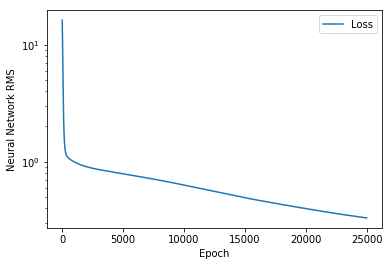

In [21]:
plt.plot(history.history["loss"], label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Neural Network RMS')
plt.yscale("log")
plt.legend()

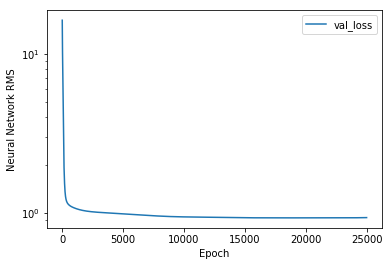

In [22]:
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel('Epoch')
plt.ylabel('Neural Network RMS')
plt.yscale("log")
plt.legend()

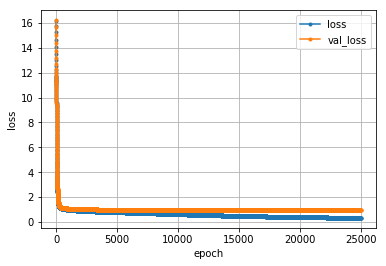

In [23]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [24]:
import pickle
file=open("/public/gkxiao/work/VP/vp_model_history.pkl","wb")
pickle.dump(history.history, file)
file.close

<function BufferedWriter.close>

<h3>5.3 保存模型</h3>

In [25]:
#save model
model.save('/public/gkxiao/work/VP/vp_model.h5')
model.save_weights('/public/gkxiao/work/VP/vp_model_weights.h5')

<h3>5.4 模型质量评估</h3>
<p>绘制训练集与测试集的预测值与观察值散点图。如果之前已经训练、保存过模型，去掉下面的注释，直接读入模型再进行模型的评估。</p>

In [26]:
#load model
from keras.models import load_model
model = load_model("/public/gkxiao/work/VP/vp_model.h5")
model.load_weights('/public/gkxiao/work/VP/vp_model_weights.h5')

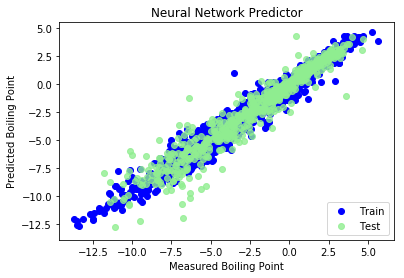

In [27]:
import matplotlib.pyplot as plt
plt.scatter(y_train,model.predict(X_train), label = 'Train', c='blue')
plt.title('Neural Network Predictor')
plt.xlabel('Measured Boiling Point')
plt.ylabel('Predicted Boiling Point')
plt.scatter(y_test,model.predict(X_test),c='lightgreen', label='Test', alpha = 0.8)
plt.legend(loc=4)
plt.show()

模型质量评估

In [28]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
y_pred=model.predict(X_train)
train_mse=mean_squared_error(y_train,y_pred)
train_mae=mean_absolute_error(y_train,y_pred)
train_r2 = r2_score(y_train,y_pred)
test_pred=model.predict(X_test)
test_mse=mean_squared_error(y_test,test_pred)
test_mae=mean_absolute_error(y_test,test_pred)
test_r2 = r2_score(y_test,test_pred)
print("Train set: MSE=",round(train_mse,2),"MAE=",round(train_mae,2),"R^2=",round(train_r2,2))
print("Test set: MSE=",round(test_mse,2),"MAE=",round(test_mae,2),"R^2=",round(test_r2,2))

Train set: MSE= 0.33 MAE= 0.39 R^2= 0.97
Test set: MSE= 0.94 MAE= 0.61 R^2= 0.93


从平均绝对误差(MAE)来看，模型质量相当好。

<h2>6. 预测新化合物的蒸汽压</h2>
<h3>6.1 建立预测集</h3>
<p>待预测化合物用SMILES编码，保存在一个预测集里(predset)，并计算描述符</p>

In [29]:
#Structure (SMILES code)  of new compound
smi = 'F/C(=C(/F)C(F)(F)F)C(F)(F)F'
#create a prediction set and calculate descriptor
predset=pd.DataFrame({'SMILES':[smi]})
predset['Mol'] = predset['SMILES'].apply(Chem.MolFromSmiles)
predset['Descriptors'] = predset['Mol'].apply(fps_plus_mw)


<h3>6.2 从硬盘加载原先保存的模型</h3>

In [30]:
#load model
from keras.models import load_model
model = load_model("/public/gkxiao/work/VP/vp_model.h5")
#model.load_weights('/public/gkxiao/work/rdkit_deeplearn/bp_keras_model_weights.h5')

<h3>6.3 读入数据预处理（归一化）参数</h3>

In [31]:
scaler_data_ = np.load("/public/gkxiao/work/VP/vp_scaler.npy")
Xmean_, Xscale_ = scaler_data_[0], scaler_data_[1]

<h3>6.4 对预测集化合物的描述符进行归一化处理</h3>

In [32]:
Xscaled = np.array(list(predset['Descriptors']))
Xscaled = (Xscaled - Xmean_)/Xscale_

<h3>6.5 预测蒸汽压</h3>

In [33]:
#predict boiling point
predset['LogVP'] = model.predict(Xscaled)[0][0]

In [34]:
#show the predset
predset

SMILES  \
0  F/C(=C(/F)C(F)(F)F)C(F)(F)F   

                                                Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f907438ec10>   

                                         Descriptors     LogVP  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  2.802145

In [37]:
#print result
print("Vapor Pressure :", round(model.predict(Xscaled)[0][0],2))

Vapor Pressure : 2.8


<h3>6.6 绘制2D结构</h3>

In [36]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(smi)
AllChem.Compute2DCoords(mol)
Draw.MolToFile(mol,"noimage.png")

![](noimage.png)